# **1. Business Problem**

## **1.1. Description**


Instacart’s data science team plays a big part in providing this delightful shopping experience. Currently they use transactional data to develop models that predict which products a user will buy again, try for the first time, or add to their cart next during a session. Recently, Instacart open sourced this data - see their blog post on 3 Million Instacart Orders, Open Sourced.italicized text
> Credits: Kaggle

__Problem Statement__
Use Instacart's anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order.

## **1.2. Source/Useful links**

- **Source** : https://www.kaggle.com/competitions/instacart-market-basket-analysis/overview
<br><br>
- **Links**
  * https://www.kaggle.com/code/uomislab/instacart-xgboost-gridsearch-notebook
  * https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded
  * https://www.kaggle.com/competitions/instacart-market-basket-analysis/discussion/35048
  




# **2. Machine Learning problem**

## **2.1. Mapping the real-world problem to a Machine Learning Problem**

### **2.1.1. Type of Machine Learning Problem**
It's a binary classification problem in which the goal is to predict whether for all the products previously ordered by user, will it be in user's last order

### **2.1.1. Performance Metrics**
Mean F1 Score is used as performance metric for this classification problem

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>
where 
precision = TP/(TP+FP)
recall = TP/(TP+FN)

> Reference - https://en.wikipedia.org/wiki/F-score


## **2.2. Data**


### **2.2.1. Data Overview**

There are 6 datasets provided and the relationship between the datasets are as showing below
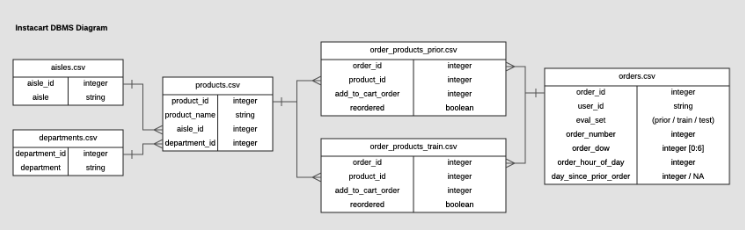





> Reference - https://www.kaggle.com/competitions/instacart-market-basket-analysis

In [ ]:
import pandas as pd     
import numpy as np
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from scipy.stats import randint as sp_randint
from scipy.stats import uniform

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool 
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import log_loss,f1_score

from operator import itemgetter
import time
import multiprocessing as mp
from f1Optimizer import get_best_prediction

from google.colab import drive
import gc
import warnings

pio.renderers.default = "png"
gc.enable()
warnings.filterwarnings("ignore")
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
orders = pd.read_csv('/content/drive/MyDrive/Instacart/orders.csv' )
order_products_train = pd.read_csv('/content/drive/MyDrive/Instacart/order_products__train.csv')
order_products_prior = pd.read_csv('/content/drive/MyDrive/Instacart/order_products__prior.csv')
products = pd.read_csv('/content/drive/MyDrive/Instacart/products.csv')
aisles = pd.read_csv('/content/drive/MyDrive/Instacart/aisles.csv')
departments = pd.read_csv('/content/drive/MyDrive/Instacart/departments.csv')

### **2.2.2. Structure of Files**

In [ ]:
orders[orders['user_id']==1]

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0    2539329        1    prior             1          2                  8   
1    2398795        1    prior             2          3                  7   
2     473747        1    prior             3          3                 12   
3    2254736        1    prior             4          4                  7   
4     431534        1    prior             5          4                 15   
5    3367565        1    prior             6          2                  7   
6     550135        1    prior             7          1                  9   
7    3108588        1    prior             8          1                 14   
8    2295261        1    prior             9          1                 16   
9    2550362        1    prior            10          4                  8   
10   1187899        1    train            11          4                  8   

    days_since_prior_order  
0                      NaN  
1                     15.0  
2                     21.0  
3                     29.0  
4                     28.0  
5                     19.0  
6                     20.0  
7                     14.0  
8                      0.0  
9                     30.0  
10                    14.0

All the orders for the users and some order related info are given in this dataset <br>
> **order_id, user_id :**  
> **order_number :** Order in which the user placed the orders <br>
> **order_dow :** day of the week order was placed <br>
> **order_hour_of_day :** hour of the day order was placed <br>
> **days_since_prior_order :** how many days passed since the user placed prior order. It's Null for the first order. <br>
> **eval_set :** prior/train/test
  * prior : prior orders of users except for last order of the user
  * train/test : last order for all the users are either in train or in test
    * train is for training the machine learning models <br>
    * test is for testing the machine learning models <br>


In [ ]:
order_products_train.head(3)

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0

This dataset contains the last order by user and the products in it
> **order_id, product_id** <br>
> **add_to_cart_order :** order in which the products are placed in cart <br> 
> **reordered** : whether the product was in prior orders by users or if it's the first time the product is added by the user

In [ ]:
order_products_prior.head(3)

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0

prior dataset contains all the orders by the users expect for the last order and the products ordered in each order. structure is same as order_products_train

In [ ]:
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

product dataset contains product related data
> **product_id** <br>
> **product_name** <br>
> **aisle_id :** aisle that product belongs to <br>
> **department_id :** department that product belongs to <br>

In [ ]:
aisles.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

contains the aisle name

In [ ]:
departments.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

contains the department name

### **2.2.3. Prepare dataset**

1.   join order_products_prior with order , to get all order level details, do the same for order_products_train
2.   join the resultant order_products_prior and order_products_prior with products 
3.   join the resultant order_products_prior and order_products_prior with aisle 
4.   join the resultant order_products_prior and order_products_prior with department




<u> **Join order_products_ with orders**

In [ ]:
order_products_train = orders.merge(order_products_train, on='order_id', how='inner')
order_products_prior = orders.merge(order_products_prior, on='order_id', how='inner')

<u> **Join order_products_ with products**

In [ ]:
order_products_train = order_products_train.merge(products, on='product_id', how='inner')
order_products_prior = order_products_prior.merge(products, on='product_id', how='inner')
order_products_train.drop('product_id', inplace=True, axis=1)
order_products_prior.drop('product_id', inplace=True, axis=1)

<u> **Join order_products_ with aisles**

In [ ]:
order_products_train = order_products_train.merge(aisles, on='aisle_id', how='inner')
order_products_prior = order_products_prior.merge(aisles, on='aisle_id', how='inner')
order_products_train.drop('aisle_id', inplace=True, axis=1)
order_products_prior.drop('aisle_id', inplace=True, axis=1)

<u> **Join order_products_ with departments**

In [ ]:
order_products_train = order_products_train.merge(departments, on='department_id', how='inner')
order_products_prior = order_products_prior.merge(departments, on='department_id', how='inner')
order_products_train.drop('department_id', inplace=True, axis=1)
order_products_prior.drop('department_id', inplace=True, axis=1)

In [ ]:
order_products_prior.head(3)

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   

   days_since_prior_order  add_to_cart_order  reordered product_name  \
0                     NaN                  1          0         Soda   
1                    15.0                  1          1         Soda   
2                    21.0                  1          1         Soda   

         aisle department  
0  soft drinks  beverages  
1  soft drinks  beverages  
2  soft drinks  beverages

In [ ]:
order_products_train.head(3)

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   1187899        1    train            11          4                  8   
1   2757217       67    train            25          0                 11   
2    632715      676    train            12          0                 13   

   days_since_prior_order  add_to_cart_order  reordered product_name  \
0                    14.0                  1          1         Soda   
1                     5.0                  1          1         Soda   
2                    26.0                  2          1         Soda   

         aisle department  
0  soft drinks  beverages  
1  soft drinks  beverages  
2  soft drinks  beverages

<u> **Storing the preprocessed files as pickle files**


In [ ]:
order_products_train.to_pickle('/content/drive/MyDrive/Instacart/order_products_train_merged.pickle')
order_products_prior.to_pickle('/content/drive/MyDrive/Instacart/order_products_prior_merged.pickle')

# **3. EDA**

<u> **User Defined Functions**


In [ ]:
def dual_axis_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle) :
  '''This function creates a dual axis chart in plotly'''
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Bar(name='Total', x=x, y=y1,text = y1,textposition = 'outside' , texttemplate='%{text:,.2s}',textfont_size=16),secondary_y=False,)   
  fig.add_trace( go.Bar(name='Reordered = 1', x=x, y=y2,text = y2,textposition = 'inside' , texttemplate='%{text:,.2s}',base = 0,textfont_size=16),secondary_y=False,)  
  fig.add_trace( go.Scatter(name='Reodered %', x=x, y=y3, text = y3, textposition='top center',mode='lines+markers+text', texttemplate='%{text:,.1%}',textfont_size=16),secondary_y=True,)
  fig.update_traces(textfont_color='green', selector=dict(type='scatter'))
  fig.update_layout(title_text=charttitle,title_x=0.5, barmode='stack',width=2000, height=600)
  fig.update_xaxes(title_text=xtitle,tickmode='linear', type = 'category')
  fig.update_yaxes(title_text=y1title , secondary_y=False)
  fig.update_yaxes(title_text=y2title , secondary_y=True)
  fig.show()


In [ ]:
def stacked_horizontal_chart(y,x1,x2,x1name,x2name,charttitle) :
  '''This function creates a stacked horizontal chart in plotly'''
  fig = go.Figure()
  fig.add_trace(go.Bar(name = x1name,y=y,x=x1,orientation='h',text = x1,textposition = 'outside' , texttemplate='%{text:,.0f}',textfont_size=16))
  fig.add_trace(go.Bar(name = x2name,y=y,x=x2,orientation='h',text = x2,textposition = 'auto' , texttemplate='%{text:,.0f}',textfont_size=16,base = 0))
  fig.update_layout( title_text=charttitle,title_x=0.5, barmode='stack',width=1800, height=800)
  fig.show()

In [ ]:
def dual_axis_clustered_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle,y1name,y2name,y3name) :
  '''This function creates a dual axis clustered chart in plotly'''
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Bar(name=y1name , x=x, y=y1, text = y1, textposition = 'inside' , texttemplate='%{text:,.0f}',textfont_size=16),secondary_y=False,)
  fig.add_trace(go.Bar(name=y2name, x=x, y=y2, text = y2, textposition = 'inside', texttemplate='%{text:,.0f}',textfont_size=16),secondary_y=False,)
  fig.add_trace(go.Scatter(name=y3name, x=x, y=y3, text = y3, textposition='top left',mode='lines+markers+text', texttemplate='%{text:,.1f}',textfont_size=16,textfont_color="green"),secondary_y=True,)
  fig.update_layout(title_text=charttitle,title_x=0.5,width=2000, height=600)
  fig.update_xaxes(title_text=xtitle, tickmode='linear', type = 'category')
  fig.update_yaxes(title_text=y1title, secondary_y=False)
  fig.update_yaxes(title_text=y2title, secondary_y=True)
  fig.show()

<u> **Reading the preprocessed pickle files**


In [ ]:
order_products_prior_merged = pd.read_pickle('/content/drive/MyDrive/Instacart/order_products_prior_merged.pickle')
order_products_train_merged = pd.read_pickle('/content/drive/MyDrive/Instacart/order_products_train_merged.pickle')
order_products_all = order_products_prior_merged.append(order_products_train_merged)

In [ ]:
order_products_prior_merged = pd.read_pickle('/content/drive/MyDrive/Instacart/order_products_prior_merged.pickle')
order_products_train_merged = pd.read_pickle('/content/drive/MyDrive/Instacart/order_products_train_merged.pickle')

In [ ]:
del order_products_all
gc.collect()

190

## **3.1.  Number of Orders & Orders with reorders per user**











In [ ]:
users_all_products = order_products_all.groupby('user_id').agg(orders = ('order_id' ,'nunique')).sort_values(by='orders' ,ascending=False)

### **3.1.1. Histogram - Orders per user**

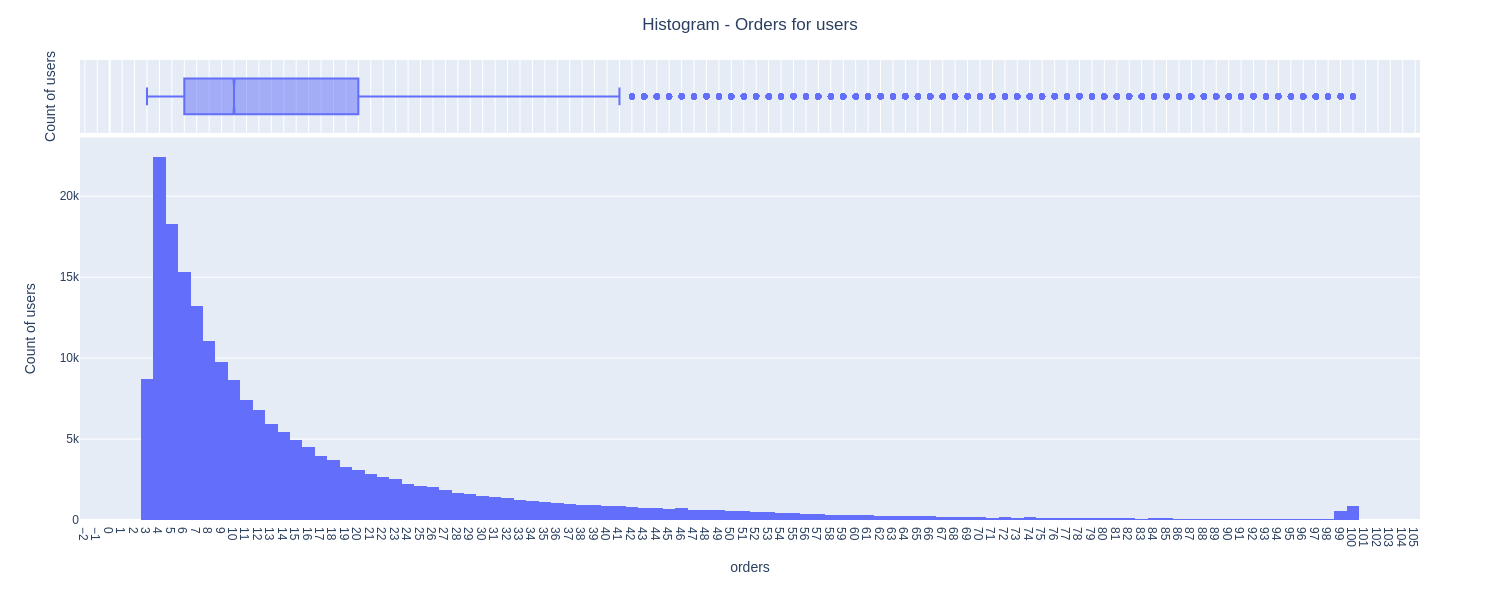

In [ ]:
fig = px.histogram(users_all_products, x="orders",width=1500, height=600,marginal="box")
fig.update_layout(title_text='Histogram - Orders for users', title_x=0.5)
fig.update_yaxes(title_text="Count of users")
fig.update_xaxes(tickmode = 'linear',dtick = 1)
fig.show()

In [ ]:
print('Most Common order per user :', users_all_products.value_counts().idxmax()[0])
print('Number of users with 4 orders :', users_all_products.value_counts().max())

Most Common order per user : 4
Number of users with 4 orders : 22451


In [ ]:
users_all_products.orders.describe()

count    206209.000000
mean         16.226658
std          16.662238
min           3.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: orders, dtype: float64

In [ ]:
print("Min order per person in the dataset :", users_all_products.orders.describe()[3])
print("Min order per person in the dataset :", users_all_products.orders.describe()[7])
print("Median order per person in the dataset :", users_all_products.orders.describe()[5])

Min order per person in the dataset : 3.0
Min order per person in the dataset : 100.0
Median order per person in the dataset : 10.0


<u> **Percentile - Order per User**

In [ ]:
quantiles = users_all_products.quantile(np.arange(0,1.01,0.01), interpolation='higher')
df = pd.DataFrame()
df['x']=quantiles.index[::2] 
df['y']=quantiles.values[::2]

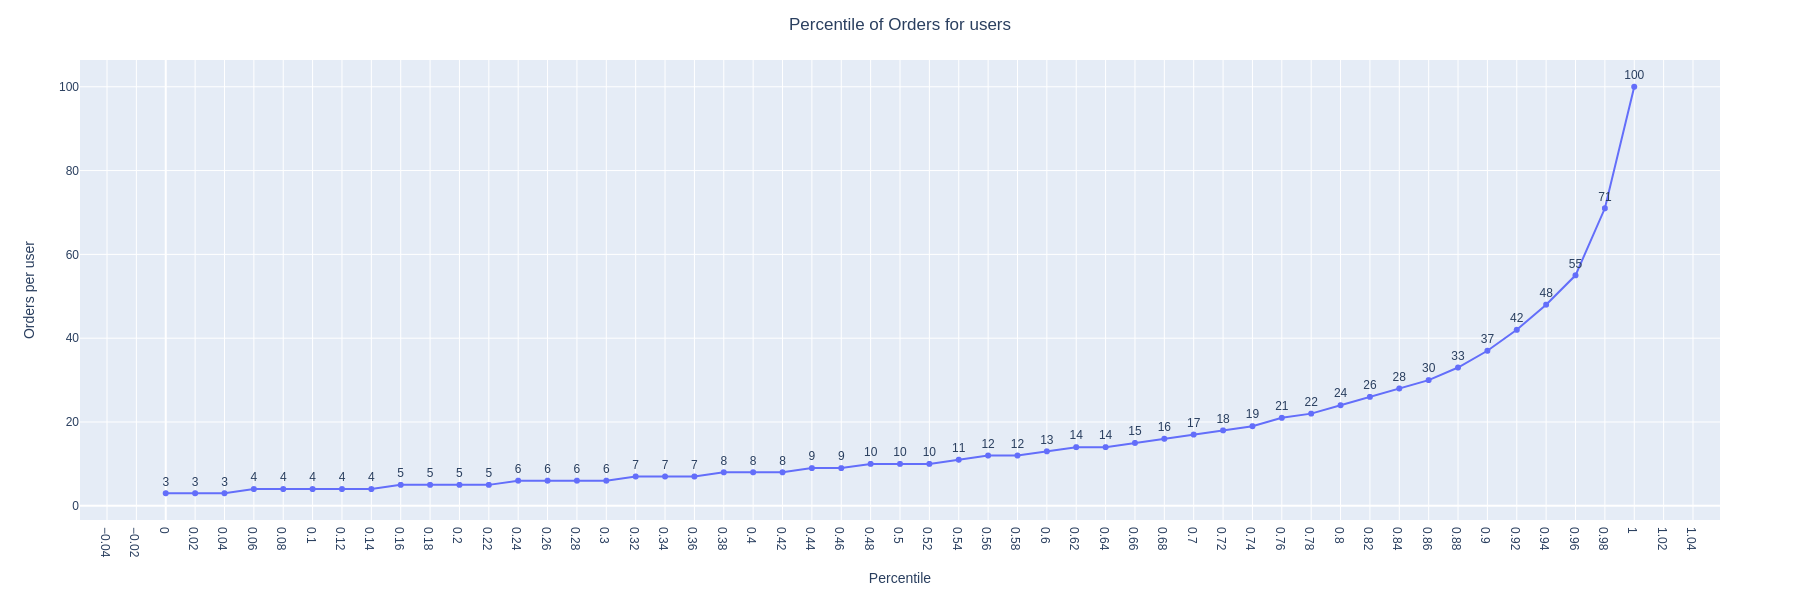

In [ ]:
fig = px.line(df, x=df.x.to_list(), y=df.y.to_list() ,markers = True, text = df.y.to_list())
fig.update_layout(title_text='Percentile of Orders for users', title_x=0.5,width=1800, height=600)
fig.update_traces(textposition='top center')
fig.update_yaxes(title_text="Orders per user")
fig.update_xaxes(title_text="Percentile",tickmode='linear',dtick = 0.02)
fig.show()

In [ ]:
ct = users_all_products.value_counts().reset_index()
print("Total count of users who had more than 42 orders :",ct[ct['orders']>42][0].sum())

Total count of users who had more than 42 orders : 15940


<u> **Observation : Histogram - Orders for users**</u>

>* Majority of ***users(22,451)*** users had ***ordered 4 times***
>* Median order per user is 10, minimum is 3 and maximum is 100
>* There are fewer users(total 15,940) with more than 42 orders.


### **3.1.2. Histogram - Reorders of users**

In [ ]:
users_all_products = order_products_all[order_products_all['reordered']== 1].groupby('user_id').agg(orders_with_reorders = ('order_id' ,'nunique'))

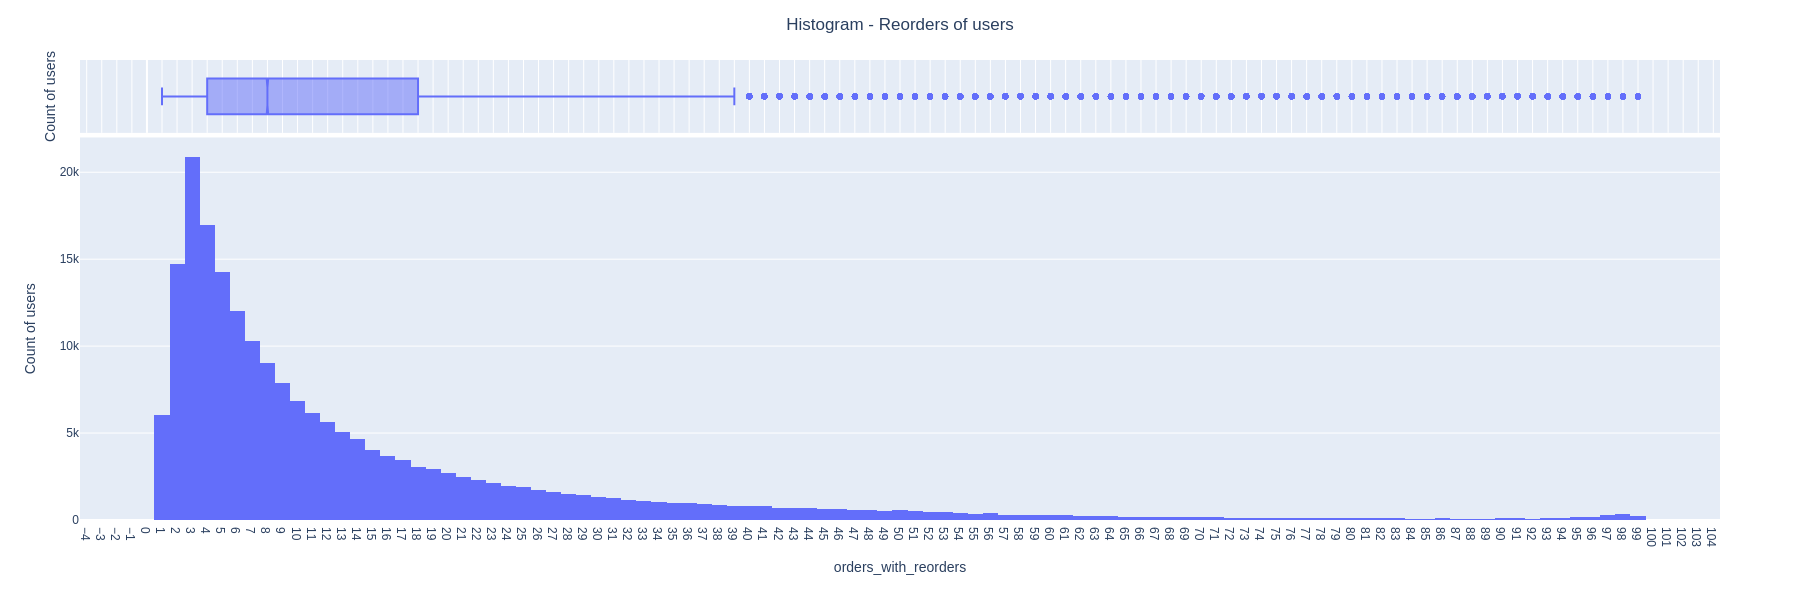

In [ ]:
fig = px.histogram(users_all_products, x="orders_with_reorders",width=1800, height=600,marginal="box")
fig.update_layout(title_text='Histogram - Reorders of users', title_x=0.5)
fig.update_yaxes(title_text="Count of users")
fig.update_xaxes(tickmode = 'linear',dtick = 1)
fig.show( )

In [ ]:
print('Most Common order per user with reorders :', users_all_products.value_counts().idxmax()[0])
print('Number of users with 3 orders with reorders :', users_all_products.value_counts().max())

Most Common order per user with reorders : 3
Number of users with 3 orders with reorders : 20901


In [ ]:
users_all_products.orders_with_reorders.describe()

count    204309.000000
mean         14.433862
std          16.436730
min           1.000000
25%           4.000000
50%           8.000000
75%          18.000000
max          99.000000
Name: orders_with_reorders, dtype: float64

In [ ]:
print("Min order per person with reorders in the dataset :", users_all_products.orders_with_reorders.describe()[3])
print("Min order per person with reorders in the dataset :", users_all_products.orders_with_reorders.describe()[7])
print("Median order per person with reorders in the dataset :", users_all_products.orders_with_reorders.describe()[5])

Min order per person with reorders in the dataset : 1.0
Min order per person with reorders in the dataset : 99.0
Median order per person with reorders in the dataset : 8.0


<u>**Percentile - Orders with reorders per User**

In [ ]:
quantiles = users_all_products.quantile(np.arange(0,1.01,0.01), interpolation='higher')
df = pd.DataFrame()
df['x']=quantiles.index[::2] 
df['y']=quantiles.values[::2]

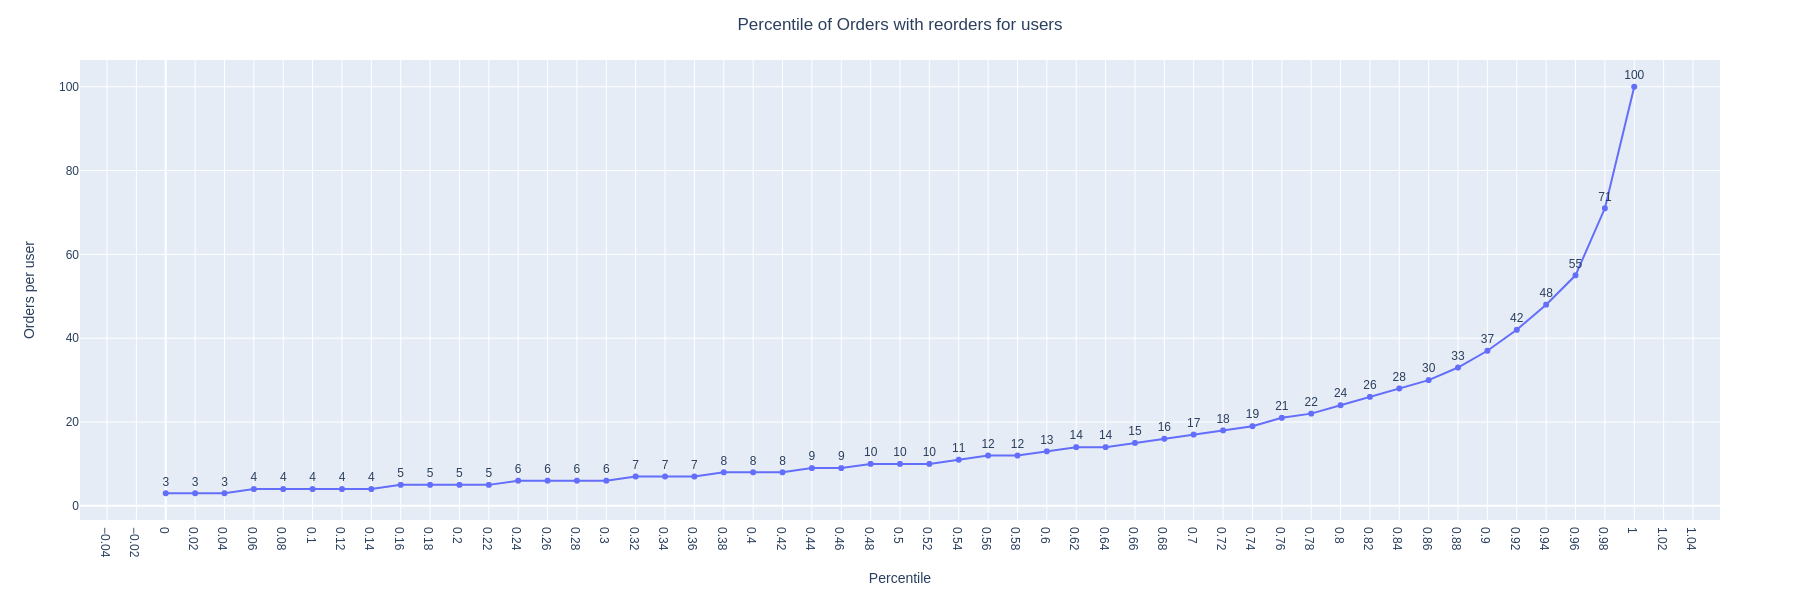

In [ ]:
fig = px.line(df, x=df.x.to_list(), y=df.y.to_list() ,markers = True, text = df.y.to_list())
fig.update_layout(title_text='Percentile of Orders with reorders for users', title_x=0.5,width=1800, height=600)
fig.update_traces(textposition='top center')
fig.update_yaxes(title_text="Orders per user")
fig.update_xaxes(title_text="Percentile",tickmode='linear',dtick = 0.02)
fig.show()

In [ ]:
ct = users_all_products.value_counts().reset_index()
print("Total count of users who had more than 40 orders :",ct[ct['orders_with_reorders']>40][0].sum())

Total count of users who had more than 40 orders : 15808


<u>**Observation : Histogram - Reorders for users**</u>

> * Majority of ***users(20.9K***) users had ***orders with reoders as 3***
* Median orders with reorder per user  is 8, minimum is 1 and maximum is 99
* There are fewer users(15808) with more than 40 orders with reorder


## **3.2. Orders & Reorders by Day of the Week**

### **3.2.1. Orders by Day of the Week**

In [ ]:
orders_dow = order_products_all.groupby('order_dow').agg(orders = ('order_id','nunique'),users = ('user_id','nunique')).reset_index()
orders_dow['orders_per_user'] = orders_dow['orders']/orders_dow['users']

<u> **Orders and users by Day of the Week**

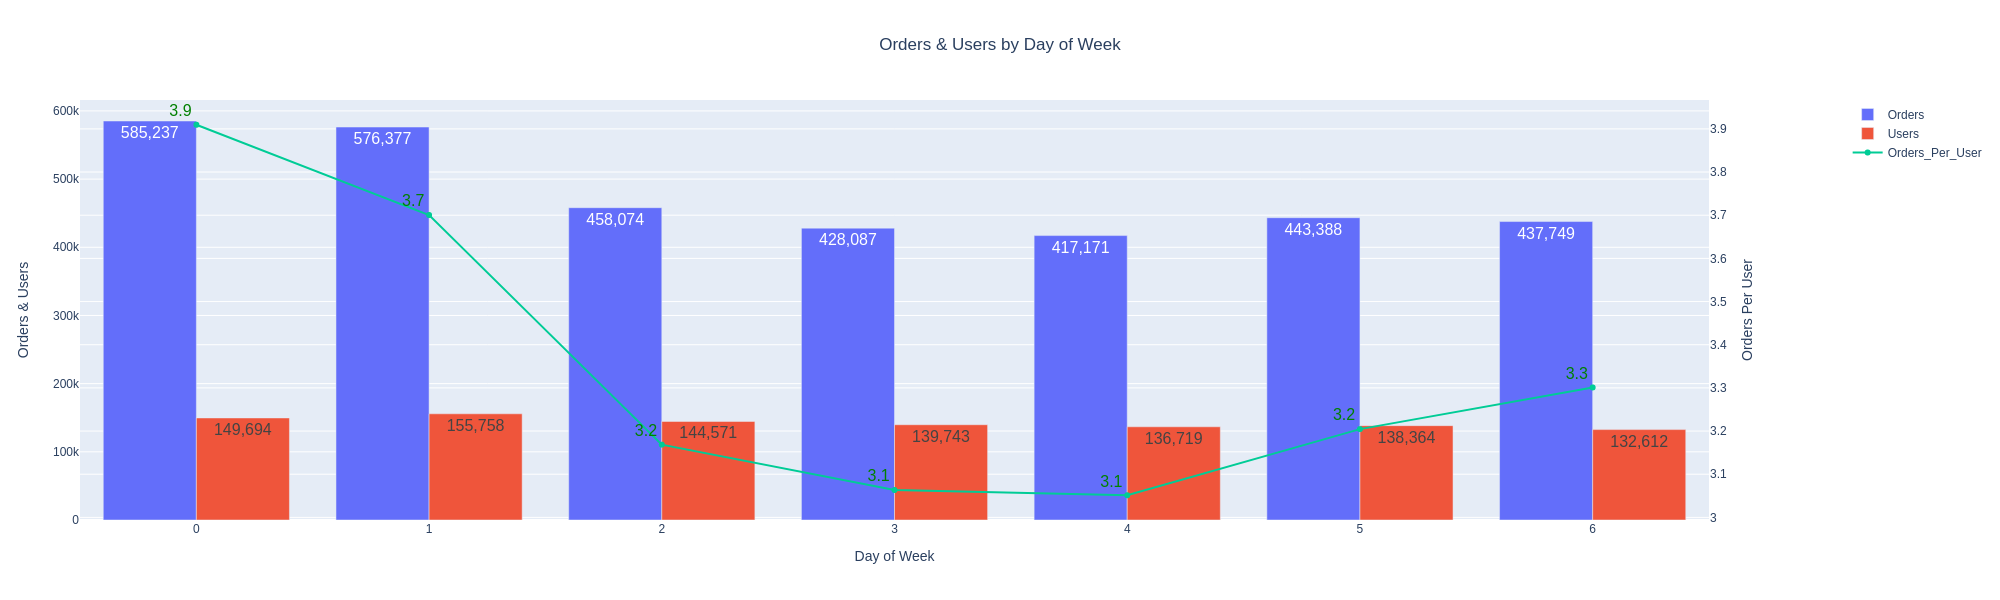

In [ ]:
x, y1, y2, y3 = orders_dow['order_dow'], orders_dow['orders'], orders_dow['users'], orders_dow['orders_per_user']
xtitle, y1title, y2title, charttitle = "Day of Week", "Orders & Users", "Orders Per User", "Orders & Users by Day of Week"
y1name, y2name, y3name = "Orders", "Users", "Orders_Per_User"
dual_axis_clustered_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle,y1name,y2name,y3name)

<u> **Observation : Orders by day of the week**

> * **Orders** is the highest on Day 0(585K) and lowest on Day4(417K)
* **Users** is the highest on Day 1(155K) and lowest on Day 6(132K)
* ***Orders per user*** is highest on Day 0(3.9), decreases until Day 4(3.04) and then increases on Day 5 and Day 6


### **3.2.2. Orders and users with reorders by Day of the Week**

In [ ]:
reorders_dow = order_products_all[order_products_all['reordered']==1].groupby('order_dow').agg(orders_with_reorders = ('order_id','nunique'),reordered_users = ('user_id','nunique')).reset_index()
reorders_dow['orderswithreorders_per_user'] = reorders_dow['orders_with_reorders']/reorders_dow['reordered_users']

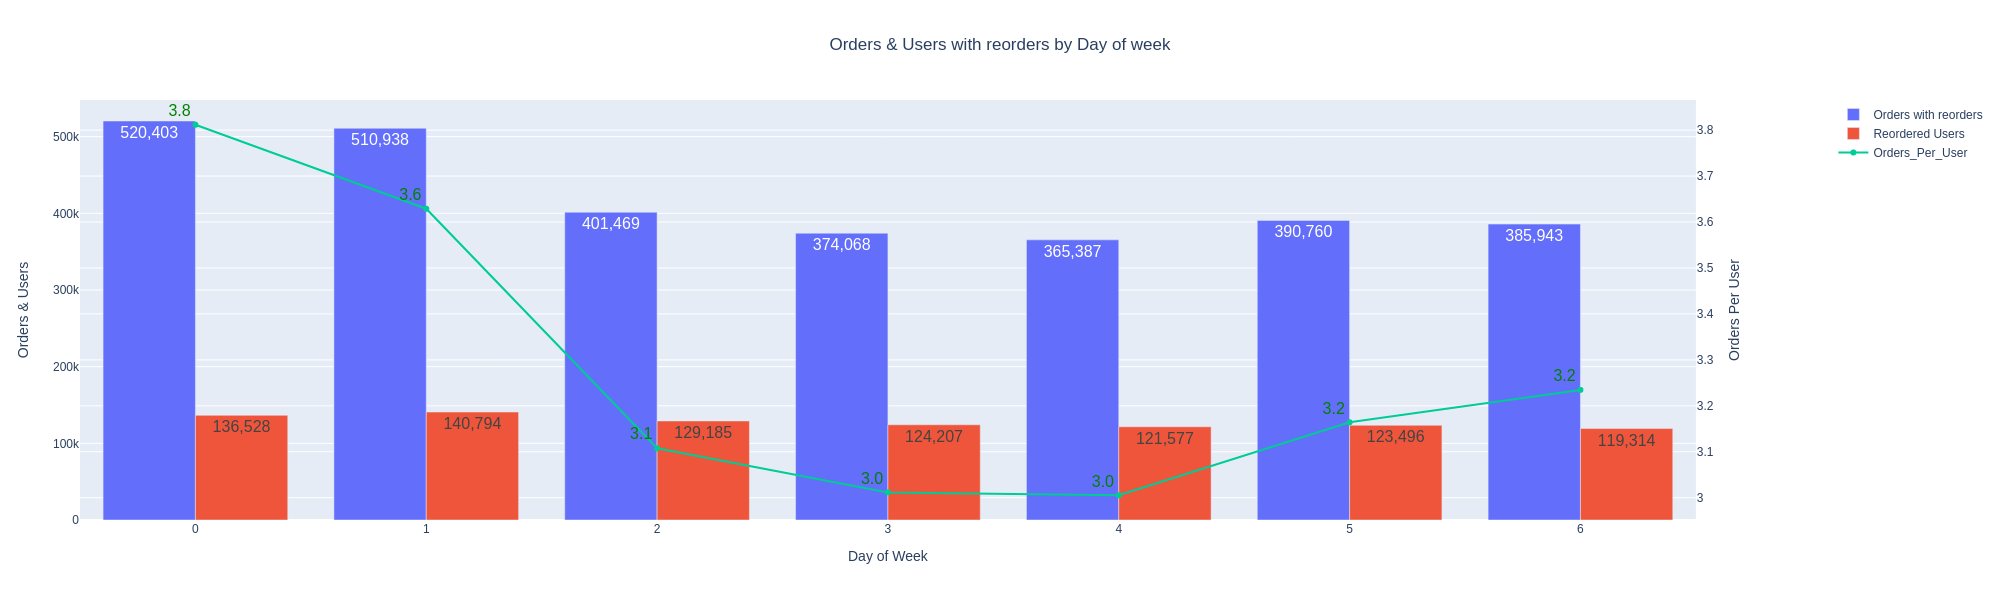

In [ ]:
x, y1, y2, y3 = reorders_dow['order_dow'], reorders_dow['orders_with_reorders'], reorders_dow['reordered_users'], reorders_dow['orderswithreorders_per_user']
xtitle, y1title, y2title, charttitle = "Day of Week", "Orders & Users", "Orders Per User", "Orders & Users with reorders by Day of week"
y1name, y2name, y3name = "Orders with reorders", "Reordered Users", "Orders_Per_User"
dual_axis_clustered_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle,y1name,y2name,y3name)

<u>**Observation : Orders with reorders by day of the week**</u>

> * **Orders** is the highest on Day 0(520) and lowest on Day4(121K)
* **Users** is the highest on Day 1(140K) and lowest on Day 6(119K)
* **Orders per user** is highest on Day 0(3.8), decreases until Day 4(3.05) and then increases on Day 5 and Day 6

## **3.3. Orders by Hour of the day**

In [ ]:
orders_hod = order_products_all.groupby('order_hour_of_day').agg(orders = ('order_id','nunique'),users = ('user_id','nunique')).reset_index()
orders_hod['orders_per_user'] = orders_hod['orders']/orders_hod['users']

### **3.3.1. Orders and users by Hour of the Day**

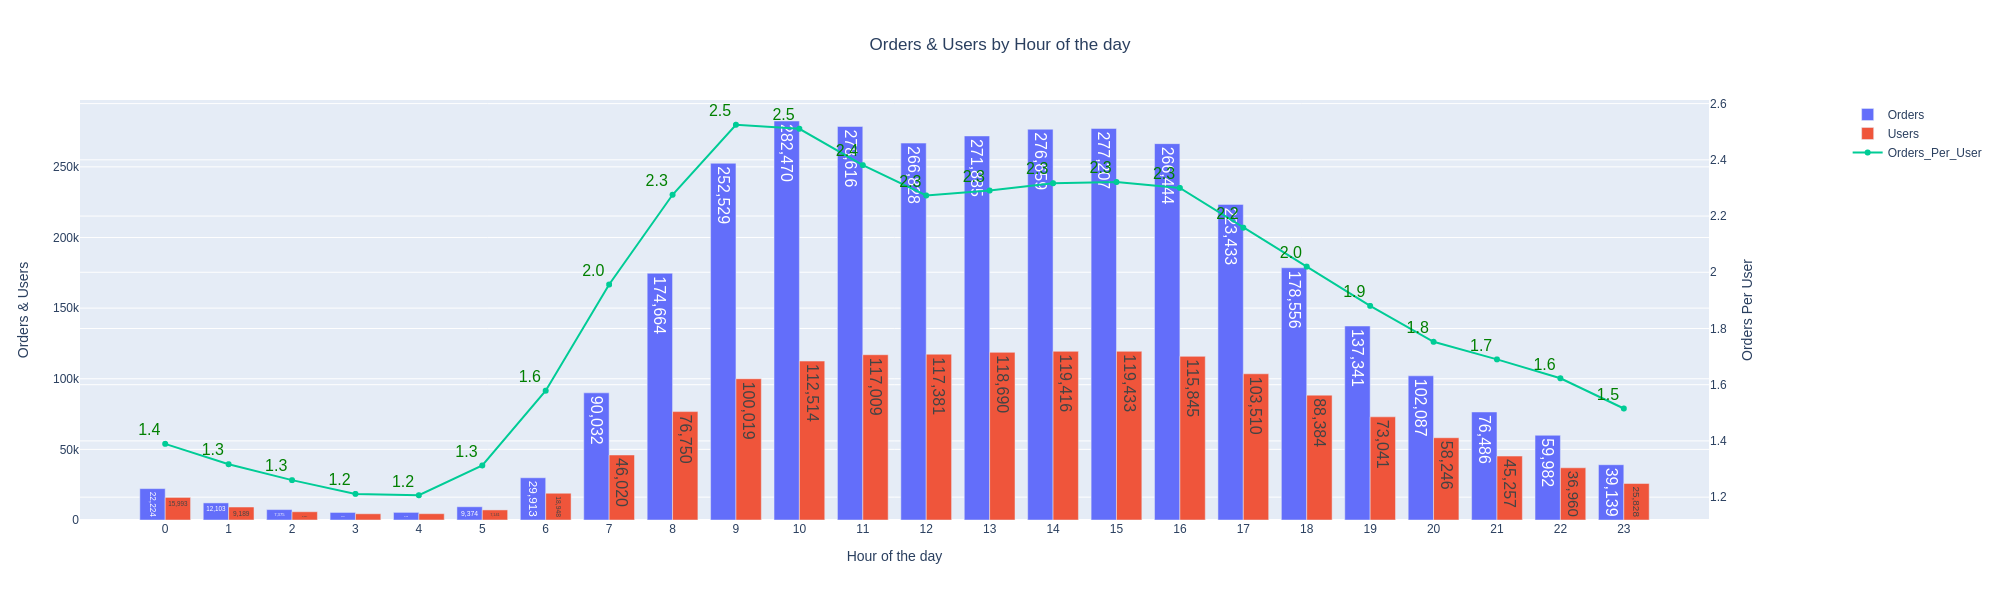

In [ ]:
x, y1, y2, y3 = orders_hod['order_hour_of_day'], orders_hod['orders'], orders_hod['users'], orders_hod['orders_per_user']
xtitle, y1title, y2title, charttitle = "Hour of the day", "Orders & Users", "Orders Per User", "Orders & Users by Hour of the day"
y1name, y2name, y3name = "Orders", "Users", "Orders_Per_User"
dual_axis_clustered_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle,y1name,y2name,y3name)

<u>**Observation : Orders by Hour of the day**</u>

> * **Orders** is the highest on Hour 10 (282K) and lowest at Hour 3(5.34K)
* **Users** is the highest on Hour 15(277K) and lowest at Hour 3(4.41K)
* **Orders per user** is highest at 9(2.5), after which it shows decreasing trend with lowest at Hour 4(1.2)

### **3.3.2. Orders and users with reorders by Hour of the day**

In [ ]:
reorders_hod = order_products_all[order_products_all['reordered']==1].groupby('order_hour_of_day').agg(orders_with_reorders = ('order_id','nunique'),reordered_users = ('user_id','nunique')).reset_index()
reorders_hod['orderswithreorders_per_user'] = reorders_hod['orders_with_reorders']/reorders_hod['reordered_users']

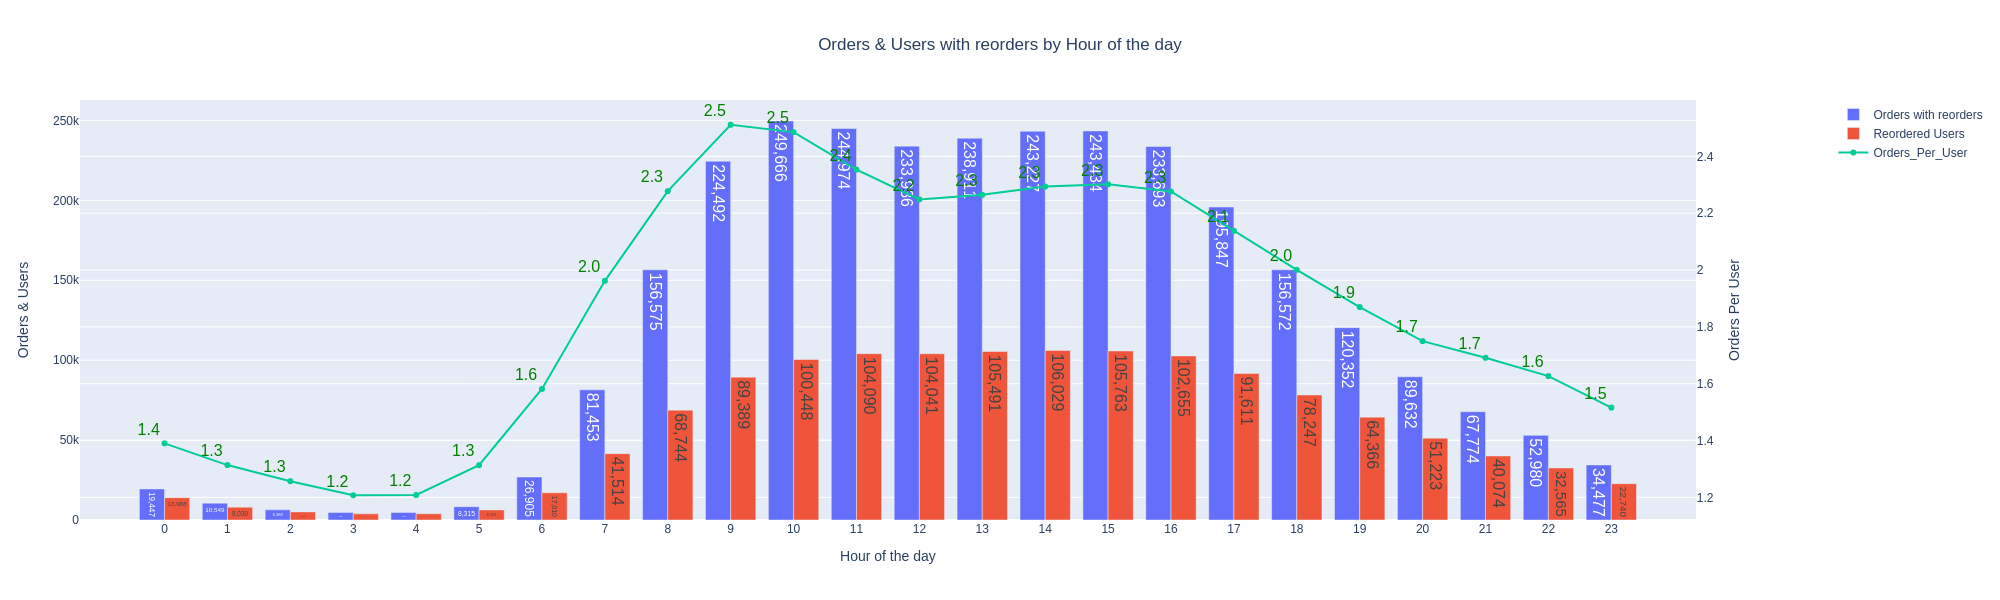

In [ ]:
x, y1, y2, y3 = reorders_hod['order_hour_of_day'], reorders_hod['orders_with_reorders'], reorders_hod['reordered_users'], reorders_hod['orderswithreorders_per_user']
xtitle, y1title, y2title, charttitle = "Hour of the day", "Orders & Users", "Orders Per User", "Orders & Users with reorders by Hour of the day"
y1name, y2name, y3name = "Orders with reorders", "Reordered Users", "Orders_Per_User"
dual_axis_clustered_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle,y1name,y2name,y3name)

<u>**Observation : Orders with reorders by Hour of the day**</u>
> *  **Orders** with reorders is the highest at Hour 10 (249K) and lowest at Hour 3(4.66K)
*   **Users** with reorders is the highest at Hour 12(106K) and lowest at Hour 3(3.85K)
*   **Orders per user** is highest at 9(2.5), after which it shows decreasing trend with lowest at Hour 4(1.2)

In [ ]:
orders_with_reorders = order_products_all[order_products_all['reordered']==1].order_id.nunique()
total_orders = order_products_all.order_id.nunique()
orders_with_reorder_percent = orders_with_reorders/total_orders
print("rerordered orders %:",orders_with_reorder_percent)

users_with_reorders = order_products_all[order_products_all['reordered']==1].user_id.nunique()
total_users= order_products_all.user_id.nunique()
users_with_reorder_percent = users_with_reorders/total_users
print("rerordered users %:",users_with_reorder_percent)

rerordered orders %: 0.8813194412690899
rerordered users %: 0.9907860471657396


> ***Both total orders and orders with reorders show very similar trend indicating most of the orders have reordered items***

*   88.1% of the total orders have reordered items.
*   99% of the total users have reordered items.








## **3.4. Day of the Week**

In [ ]:
order_products_all_dow_pivot = order_products_all.groupby('order_dow').agg(total = ('product_name','count'),reorders = ('reordered' ,'sum'), reordered_percent = ('reordered','mean')).reset_index()

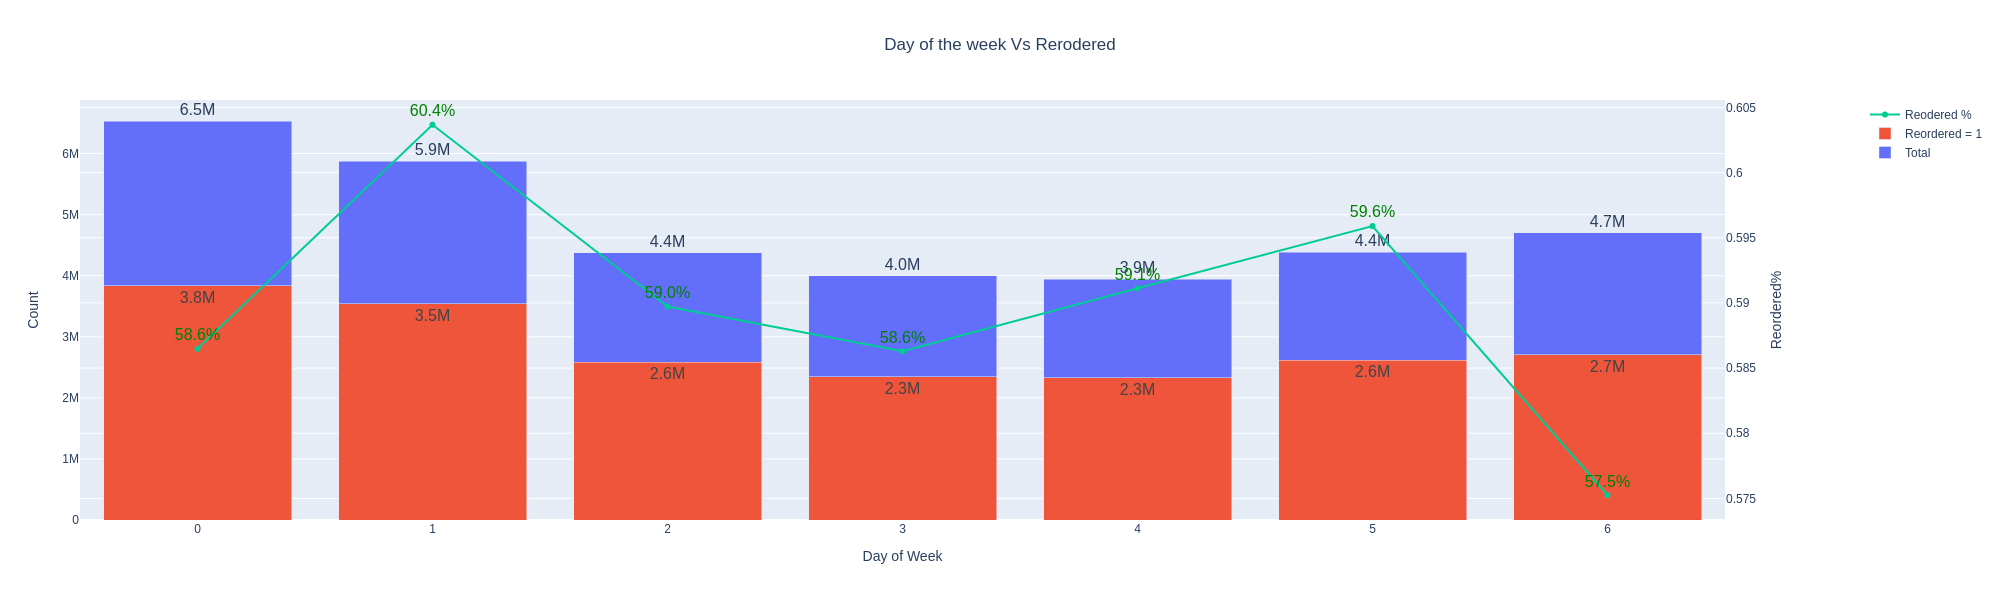

In [ ]:
x, y1, y2, y3 = order_products_all_dow_pivot['order_dow'], order_products_all_dow_pivot['total'], order_products_all_dow_pivot['reorders'], order_products_all_dow_pivot['reordered_percent']
xtitle, y1title, y2title, charttitle = "Day of Week", "Count", "Reordered%", "Day of the week Vs Rerodered"
dual_axis_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle)

<u> **Observation : Reordered% by Day of the week** </u>
> *   ***Total ordered products*** is highest on day Day 0(6.5M) and the lowest is on Day 4(3.94M)
*   ***Total reordered products*** is highest on Day 0(3.8M) and the lowest is on Day 4(2.33M)
*   ***Reordered%*** is highest on day 1(60.4%) and lowest on Day 6(57.5%) 



## **3.5. Hour of the day**

In [ ]:
order_products_all_hod_pivot = order_products_all.groupby('order_hour_of_day').agg(total = ('product_name','count'),reorders = ('reordered' ,'sum'), reordered_percent = ('reordered','mean')).reset_index()

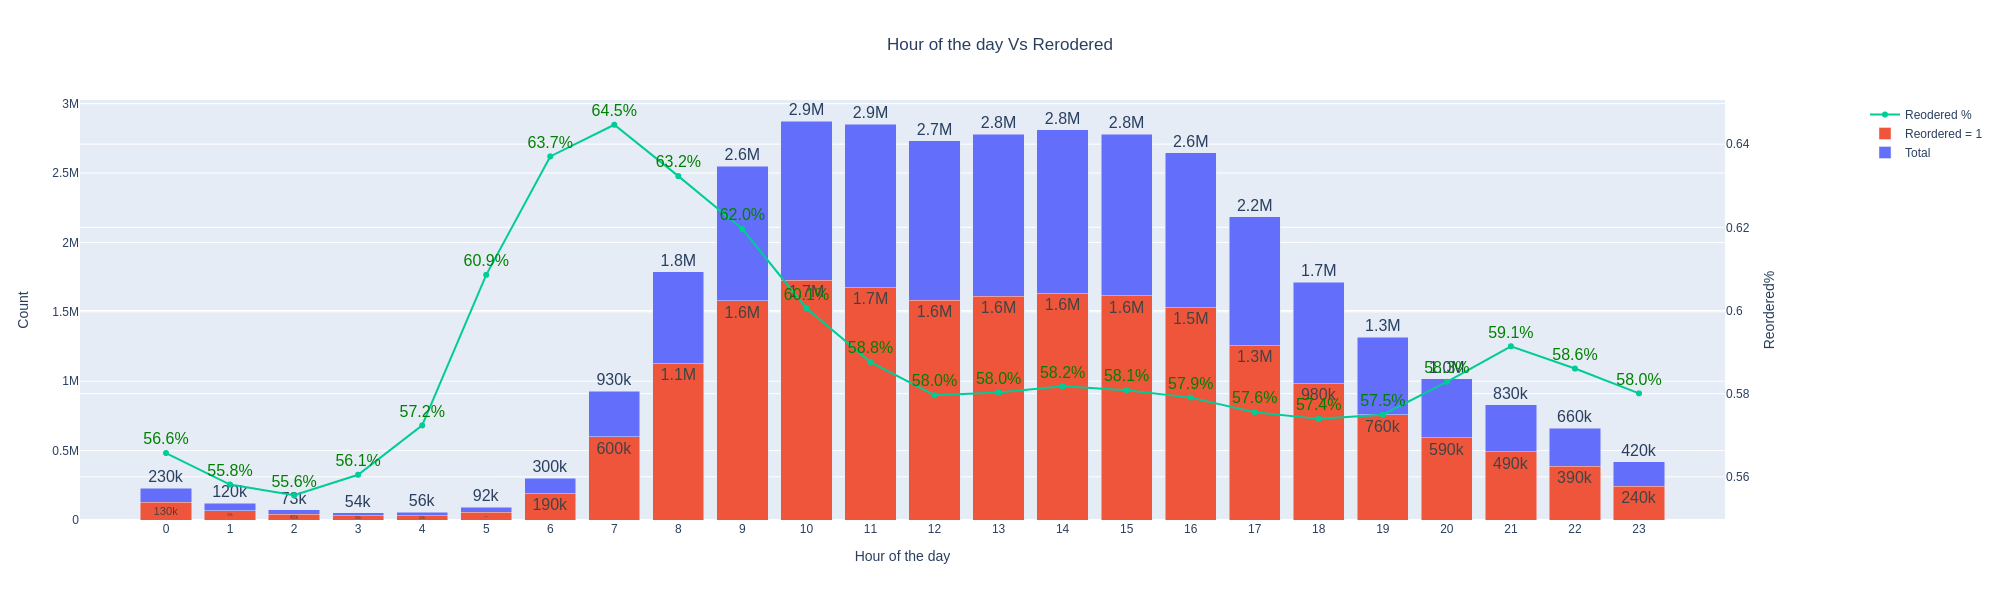

In [ ]:
x, y1, y2, y3 = order_products_all_hod_pivot['order_hour_of_day'], order_products_all_hod_pivot['total'], order_products_all_hod_pivot['reorders'], order_products_all_hod_pivot['reordered_percent']
xtitle, y1title, y2title, charttitle = "Hour of the day", "Count", "Reordered%", "Hour of the day Vs Rerodered"
dual_axis_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle)

<u>**Observation : Reordered % by Hour of the day**</u>
> *   **Total ordered products** is highest at Hour 10(2.8M) and the lowest is at Hour 3(53K)
*   **Total reordered products** is highest at Hour 10(1.7M) and the lowest is on Hour 3(30.1K)
*   **Reordered%** is highest at Hour 7(64.5%) and lowest at Hour 2(55.6%)


## **3.6. Hour of the day vs Day of the week**

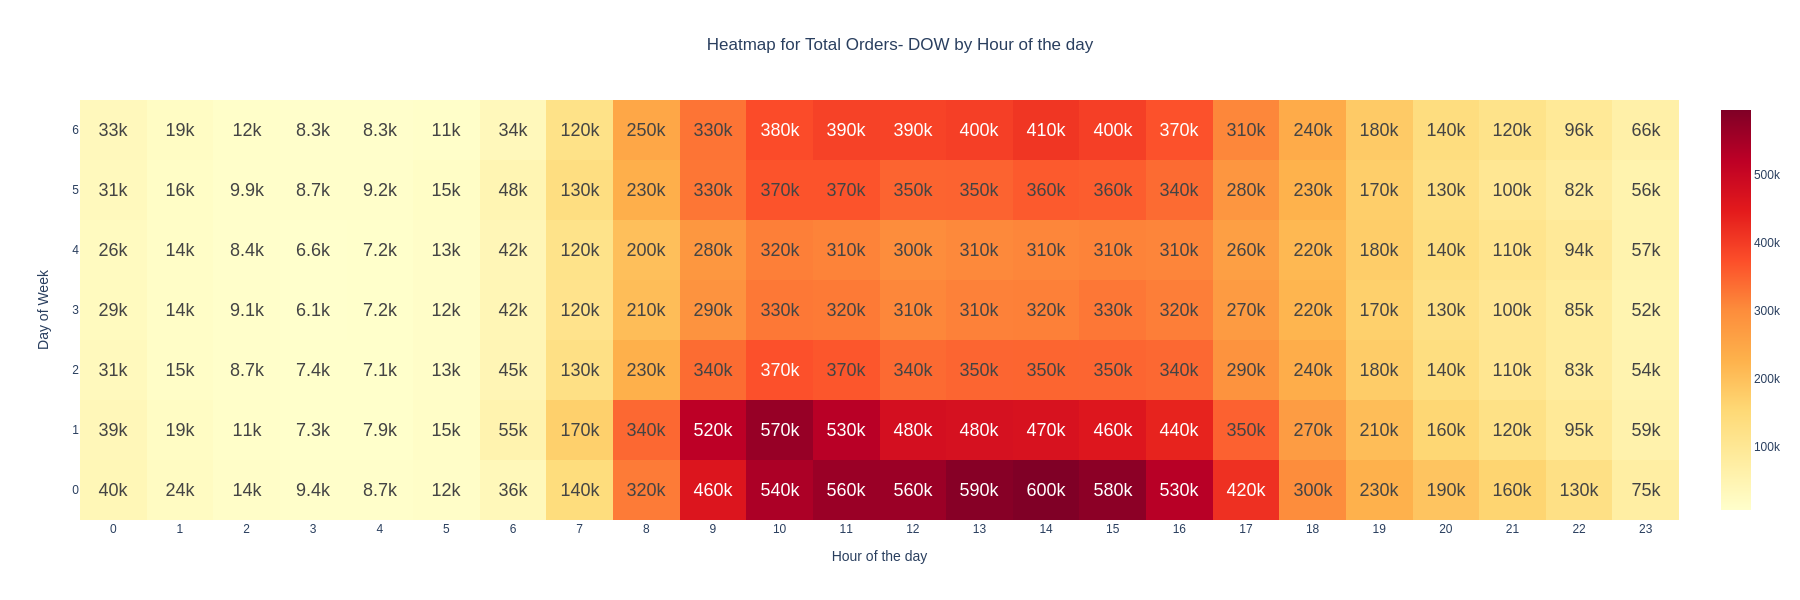

In [ ]:
order_products_reordered_hours_dow = order_products_all.groupby(['order_dow','order_hour_of_day']).agg(total = ('product_name','count'),reordered_percent = ('reordered','mean'), reorders = ('reordered','sum')).reset_index()
total_pivot = order_products_reordered_hours_dow.pivot(index= 'order_dow' , columns = 'order_hour_of_day', values = 'total')
orders_pivot_dict = {'z': total_pivot.values.tolist(), 'x': total_pivot.columns.tolist(),'y': total_pivot.index.tolist()}
fig = go.Figure(data=go.Heatmap(orders_pivot_dict, colorscale = "YlOrRd",text =orders_pivot_dict['z']  , texttemplate='%{text:.2s}'))
fig.update_xaxes(title_text="Hour of the day", tickmode='linear', type = 'category')
fig.update_traces(textfont_size=18)
fig.update_yaxes(title_text="Day of Week")
fig.update_layout(title_text="Heatmap for Total Orders- DOW by Hour of the day",title_x=0.5,width=1800, height=600)
fig.show()

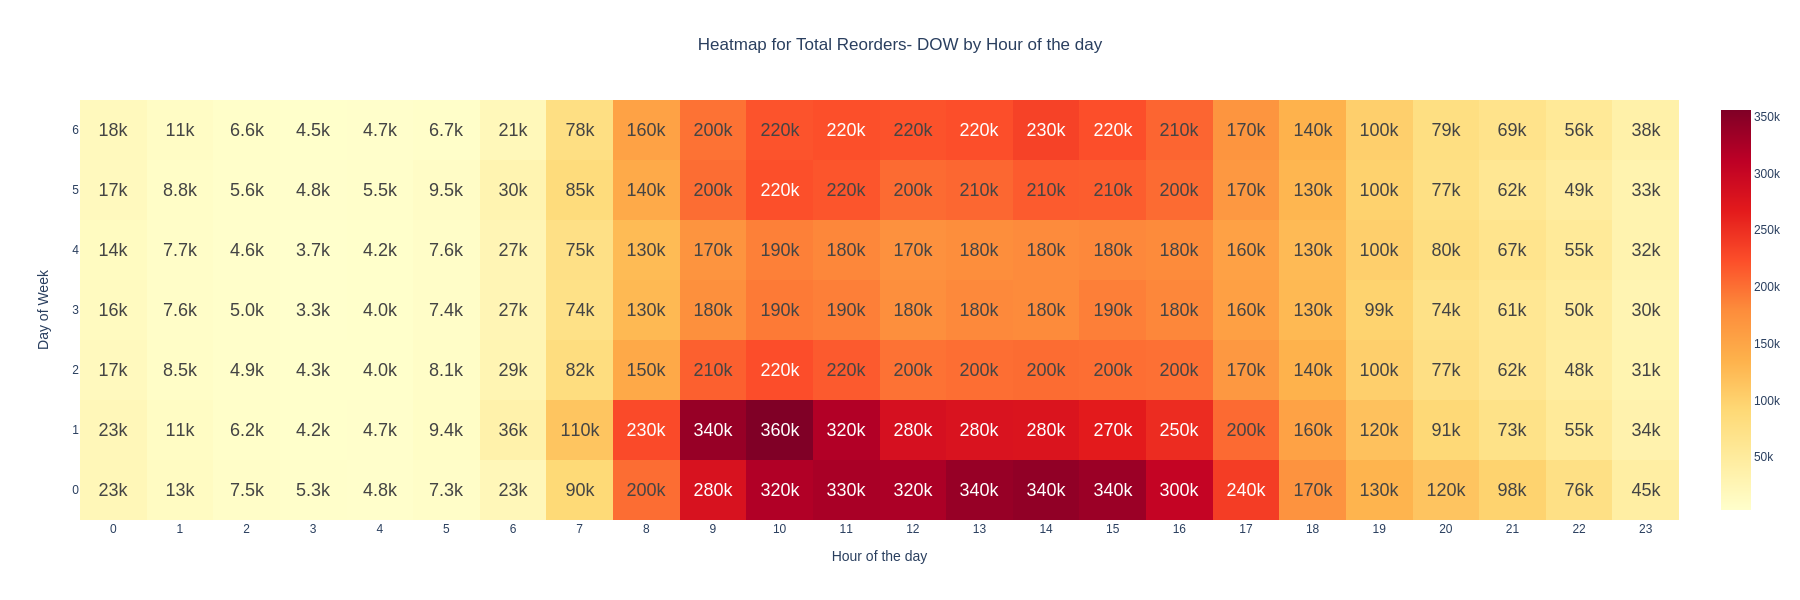

In [ ]:
reorder_pivot = order_products_reordered_hours_dow.pivot(index= 'order_dow' , columns = 'order_hour_of_day', values = 'reorders')
reorders_pivot_dict = {'z': reorder_pivot.values.tolist(), 'x': reorder_pivot.columns.tolist(),'y': reorder_pivot.index.tolist()}
fig = go.Figure(data=go.Heatmap(reorders_pivot_dict, colorscale = "YlOrRd",text =reorders_pivot_dict['z']  , texttemplate='%{text:.2s}'))
fig.update_xaxes(title_text="Hour of the day", tickmode='linear', type = 'category')
fig.update_traces(textfont_size=18)
fig.update_yaxes(title_text="Day of Week")
fig.update_layout(title_text="Heatmap for Total Reorders- DOW by Hour of the day",title_x=0.5,width=1800, height=600)
fig.show()

<u>**Observation : Hour of the day vs Day of the Week Total orders & Reorders**</u>
*   Total orders and reordered products are highest on Day 0 between 9 to 16
*   On all days Orders and reorders are highest between hours 8 and 15.
*   Total ordered products and reordered prodcuts are least in the mmorning hours between 1 and 5


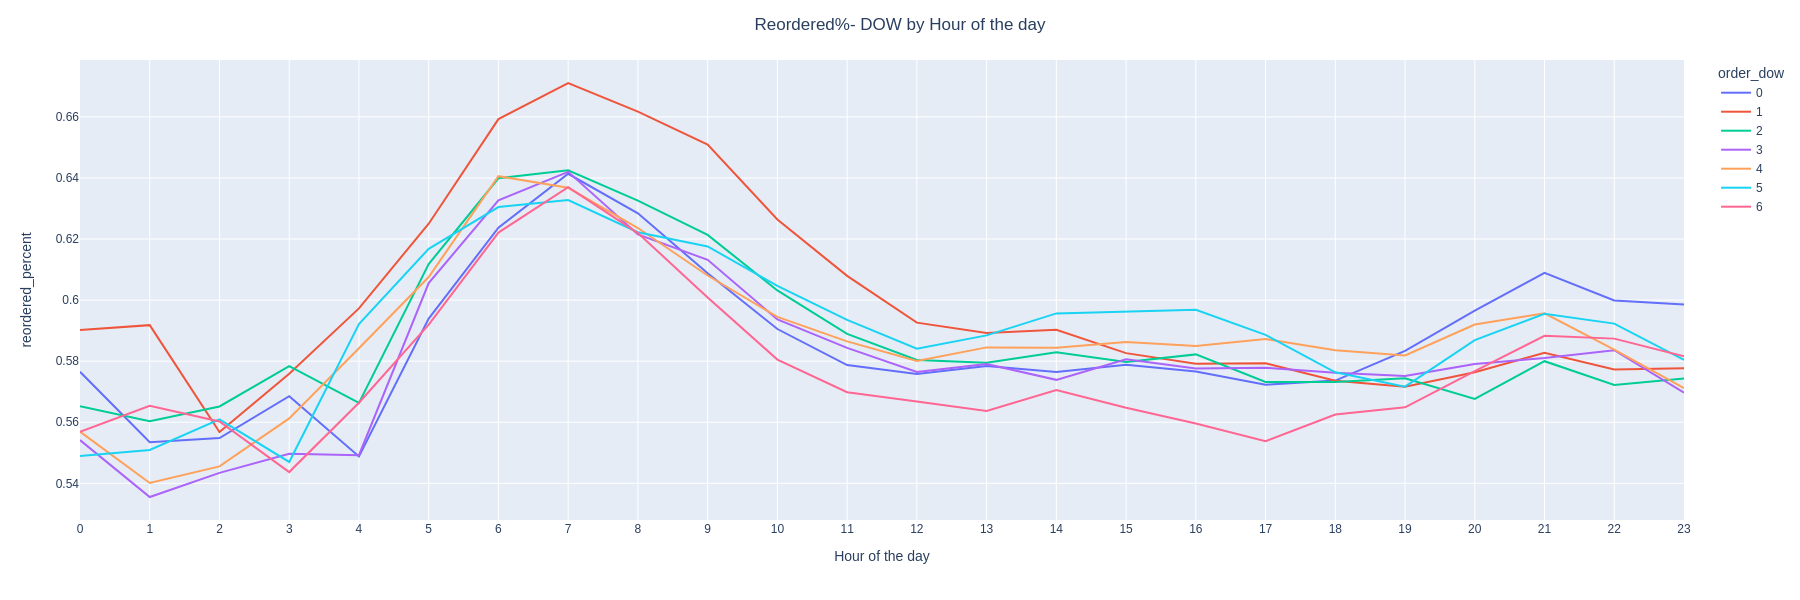

In [ ]:
fig = px.line(order_products_reordered_hours_dow, x="order_hour_of_day", y="reordered_percent", color='order_dow')
fig.update_xaxes(title_text="Hour of the day", tickmode='linear', type = 'category')
fig.update_layout(title_text="Reordered%- DOW by Hour of the day",title_x=0.5,width=1800, height=600)
fig.show()

<u>**Observation : Hour of the day vs Day of the Week - Reordered%**</u>

> *   Reordered% is the highest on Day 1 between hours of 5 and 10 
*   Day 0 has slightly higher reorder% between hours 20 and 23 than on all other days
*   On all days reordered % is highest between hours 4 and 9 and lowest is at hour 1 (except day 1)


## **3.7. Days Since Prior Order**

In [ ]:
order_days_since_prior = order_products_all[order_products_all['days_since_prior_order'].notnull()].groupby('days_since_prior_order').agg(total = ('product_name','count'),reorders = ('reordered','sum'),reordered_percent = ('reordered','mean')).reset_index()

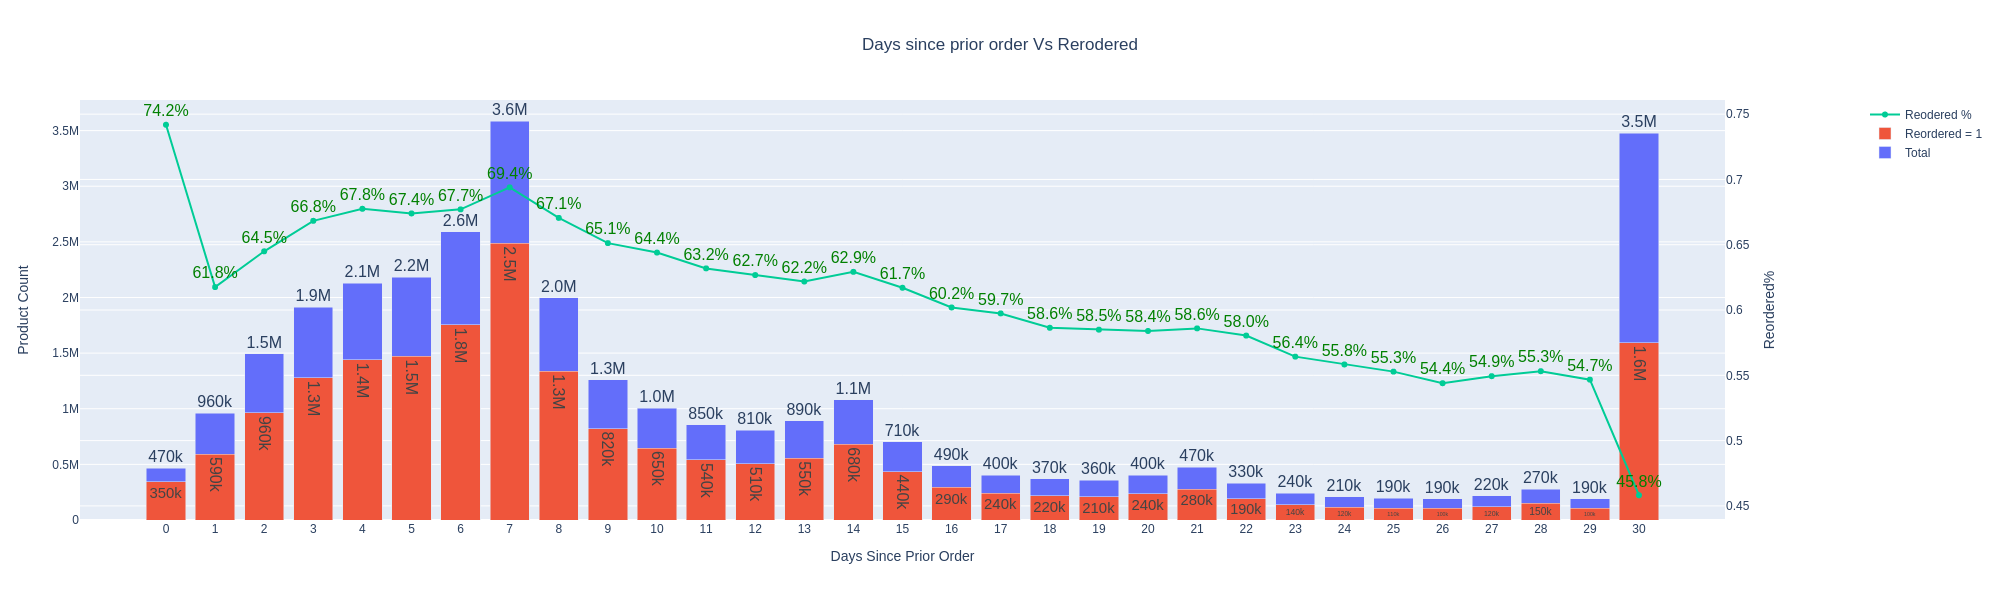

In [ ]:
x, y1, y2, y3 = order_days_since_prior['days_since_prior_order'], order_days_since_prior['total'], order_days_since_prior['reorders'], order_days_since_prior['reordered_percent']
xtitle, y1title, y2title, charttitle = "Days Since Prior Order", "Product Count", "Reordered%", "Days since prior order Vs Rerodered"
dual_axis_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle)

<u>**Observation : Days Since Prior Order**</u>
> *   Reorder% is the highest for orders with days since prior order = 0(74.2%) , ie products purchased on the same day mostly are reordered items
*   Reordered items are more days_since_prior order 7(69.4%) , indicating many reorders items on day 7. It's also higher on days 14 (bi-weekly) and 21(tri-weekly).
*   There are many items ordered after 30 days , but reordered%(45.8) is least for such orders

## **3.8. Add to Cart Order**

In [ ]:
products_per_order = order_products_all.groupby('order_id').agg(products = ('product_name','nunique')).reset_index()

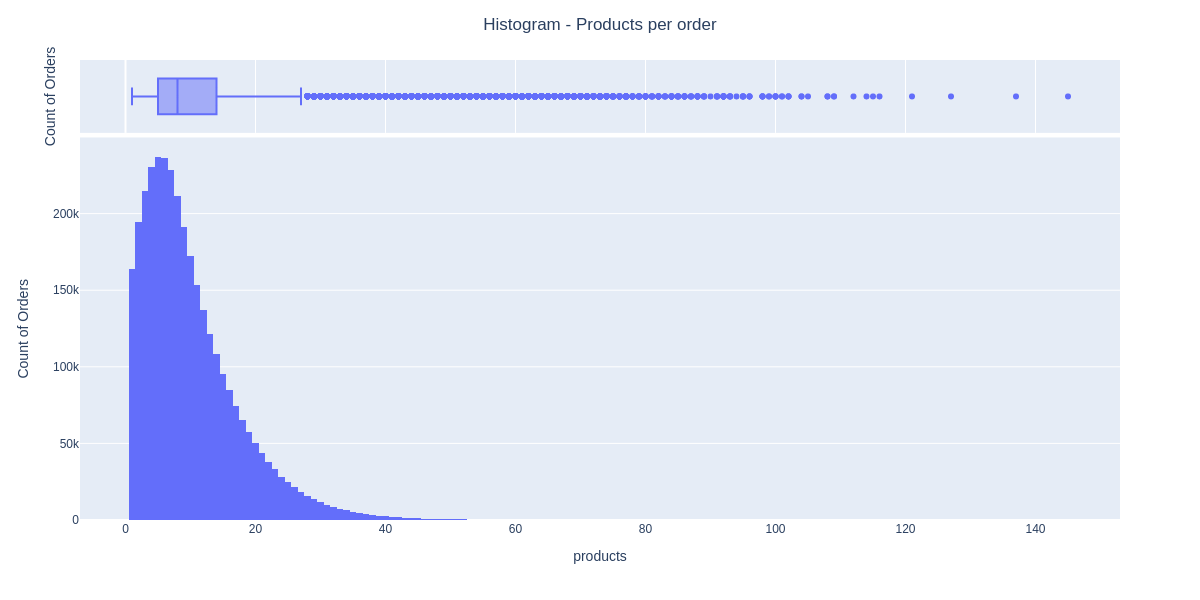

In [ ]:
fig = px.histogram(products_per_order, x="products",width=1200, height=600,marginal="box")
fig.update_layout(title_text='Histogram - Products per order', title_x=0.5)
fig.update_yaxes(title_text="Count of Orders")
fig.show()

In [ ]:
quantiles = products_per_order.products.quantile(np.arange(0,1.01,0.01), interpolation='higher')

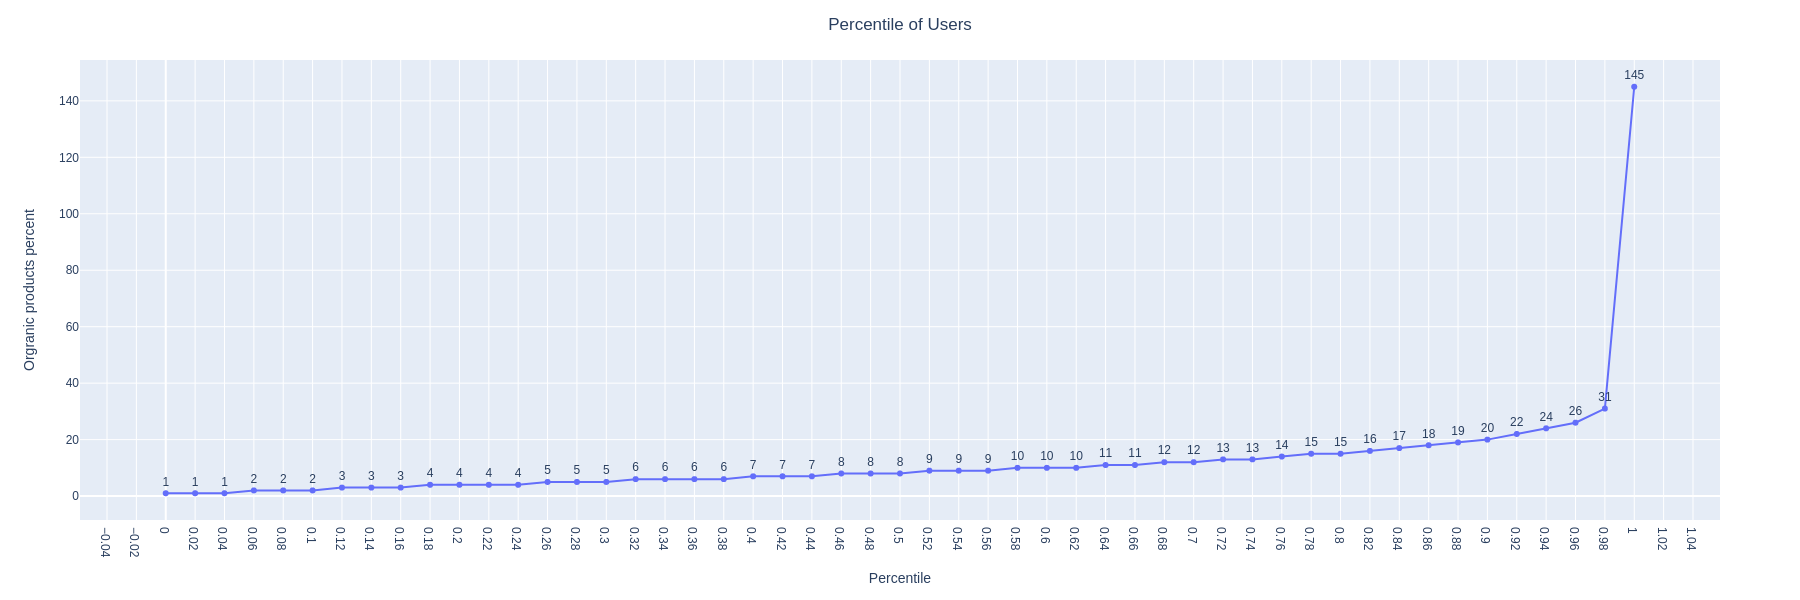

In [ ]:
df = pd.DataFrame()
df['x1']=quantiles.index[::2] 
df['y1']=quantiles.values[::2]
fig = px.line(df, x=df.x1.to_list(), y=df.y1.to_list() ,markers = True, text = df.y1.to_list(),hover_data = ['x1','y1'])
fig.data[0].texttemplate = '%{customdata[1]:.0f}'
fig.update_layout(title_text='Percentile of Users', title_x=0.5,width=1800, height=600)
fig.update_traces(textposition='top center')
fig.update_yaxes(title_text="Orgranic products percent")
fig.update_xaxes(title_text="Percentile",tickmode='linear',dtick = 0.02)
fig.show()

<u>**Observation : Number of products per order**</u>
> *   90th percetile is 31 products, so 90% of orders have <= 31 products.

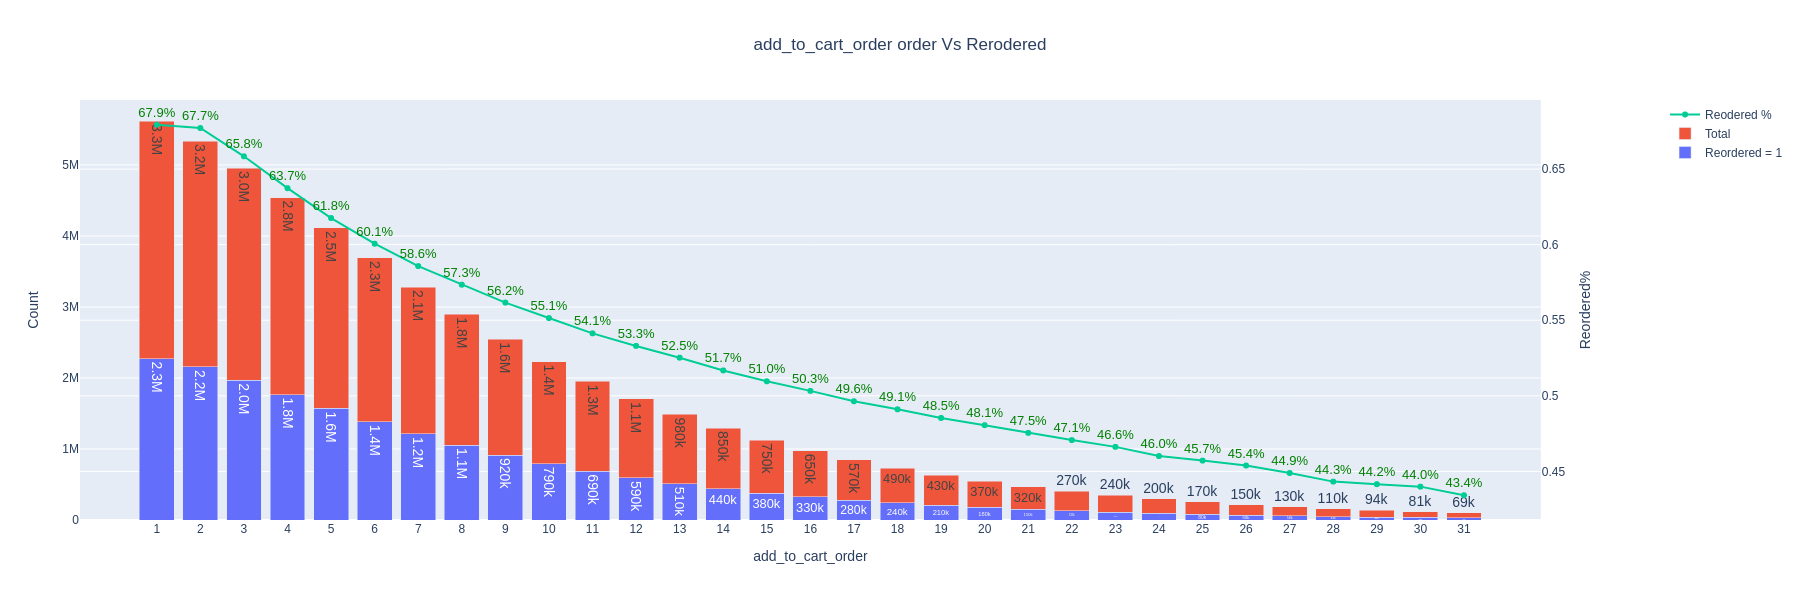

In [ ]:
#only orders with upto 31 orders considered
add_to_cart_order_all = order_products_all[order_products_all['add_to_cart_order']<=31].groupby('add_to_cart_order').agg(total = ('product_name','count'),reordered_percent = ('reordered','mean'), reorders = ('reordered','sum')).reset_index()
x= add_to_cart_order_all['add_to_cart_order']
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace( go.Bar(name='Reordered = 1', x=x, y=add_to_cart_order_all['reorders'],text = add_to_cart_order_all['reorders'],textposition = 'outside' , texttemplate='%{text:,.2s}',textfont_size = 14),secondary_y=False,)
fig.add_trace(go.Bar(name='Total', x=x, y=add_to_cart_order_all['total'],text = add_to_cart_order_all['total'],textposition = 'auto' , texttemplate='%{text:,.2s}',textfont_size = 14),secondary_y=False,)   
fig.add_trace( go.Scatter(name='Reodered %', x=x, y=add_to_cart_order_all['reordered_percent'], text = add_to_cart_order_all['reordered_percent'], textposition='top center',
                          mode='lines+markers+text', texttemplate='%{text:,.1%}',textfont_size = 13),secondary_y=True,)
fig.update_traces(textfont_color='green', selector=dict(type='scatter'))
fig.update_layout( title_text="add_to_cart_order order Vs Rerodered",title_x=0.5, barmode='stack',width=1800, height=600)
fig.update_xaxes(title_text="add_to_cart_order",tickmode='linear', type = 'category')
fig.update_yaxes(title_text="Count", secondary_y=False)
fig.update_yaxes(title_text="Reordered%", secondary_y=True)
fig.show()

<u>**Observation : Add to Cart Order**</u>

> *  Reorder% decreases as the add to cart order increases, that is products that are added to cart initally has chances of being reordered more.
* Highest reordered% is for Add to cart order 1(67.9%) and 2(67.7%)

## **3.9.Products**

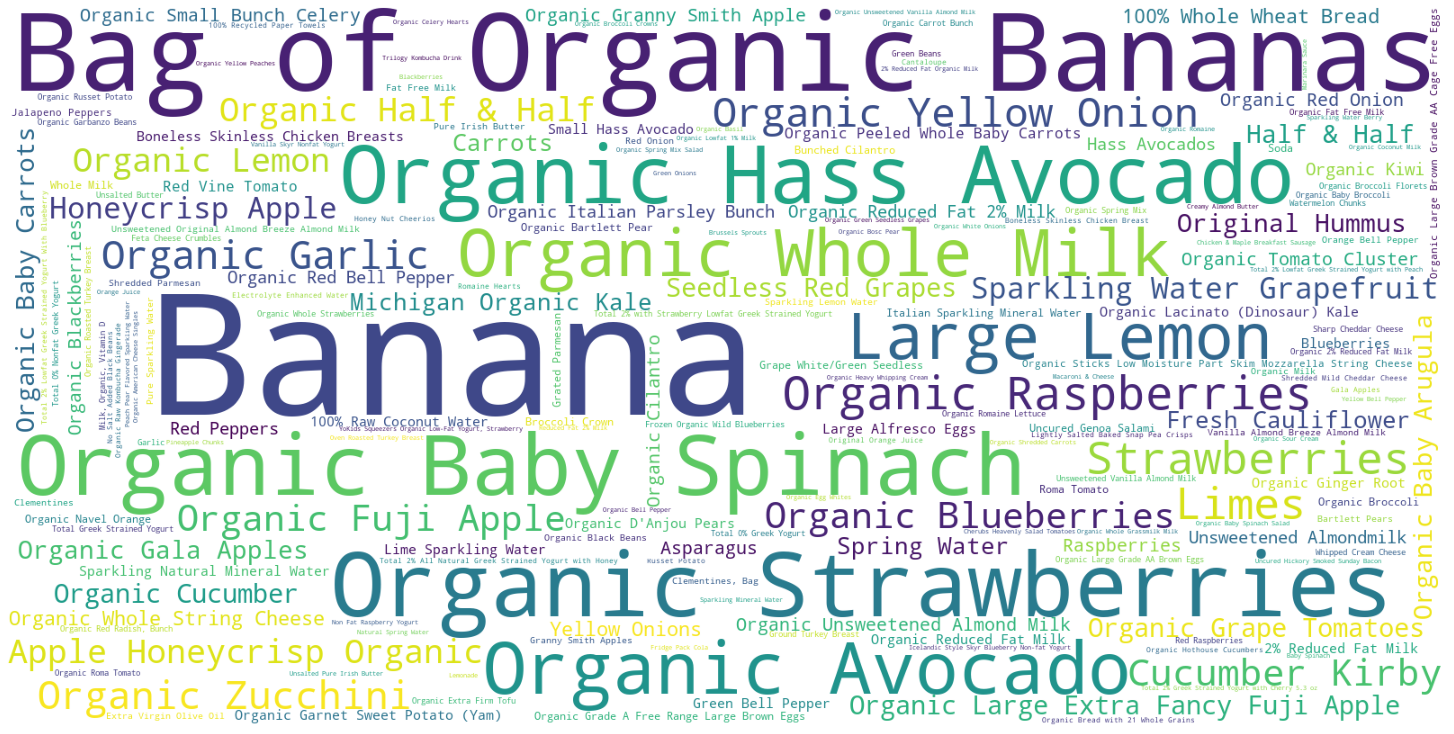

In [ ]:
product_all = order_products_all.groupby('product_name').agg(total=('product_name','count'),reorders = ('reordered','sum'),reordered_percent = ('reordered','mean')).reset_index()
order_products_all_names_dict = dict(zip(product_all.product_name, product_all.reorders))
wc = WordCloud(background_color='white', width=1600,height=800, ).generate_from_frequencies(order_products_all_names_dict)
fig = plt.figure(figsize=(20,20),facecolor = None)
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


<u>**Observation : WorldCloud for Reordered products count**</u>
> *  Highest reordered products are Banana, Bag of Orgranic Banana and many other orgranic items.

In [ ]:
product_all.total.describe()


count     49685.000000
mean        680.670343
std        4987.769425
min           1.000000
25%          18.000000
50%          63.000000
75%         272.000000
max      491291.000000
Name: total, dtype: float64

In [ ]:
product_all_filtered  = product_all[product_all['total']>680]

* *In the above step we are filtering products which has atleast 680 orders(mean) to see which products with reasonable orders have highest reorder%*

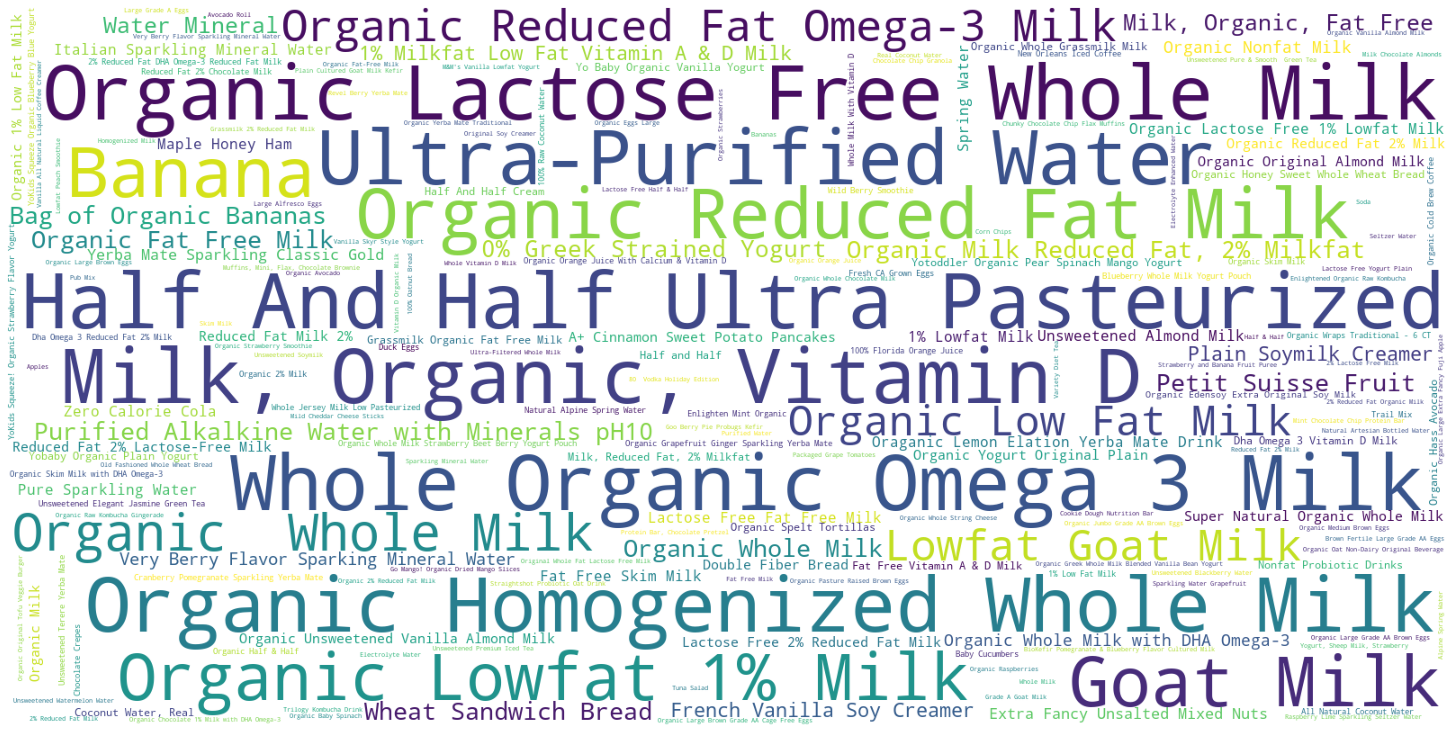

In [ ]:
order_products_all_names_dict = dict(zip(product_all_filtered.product_name, product_all_filtered.reordered_percent))
wc = WordCloud(background_color='white',width=1600,height=800,).generate_from_frequencies(order_products_all_names_dict)
fig = plt.figure(figsize=(20,20),facecolor = None)
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<u>**Observation : WorldCloud for Reordered%**</u>
> *  In a glance we can see that for products that have a threshold amount of orders(680), highest reordered % is mainly for Dairy products.

Top 25 milk products 

In [ ]:
product_all['product_name'] = product_all['product_name'].map(lambda x: x.lower())
product_all_dairy = product_all[(product_all['product_name'].str.contains("milk"))]
top_25_milk = product_all_dairy.nlargest(n=25, columns=['reordered_percent'])

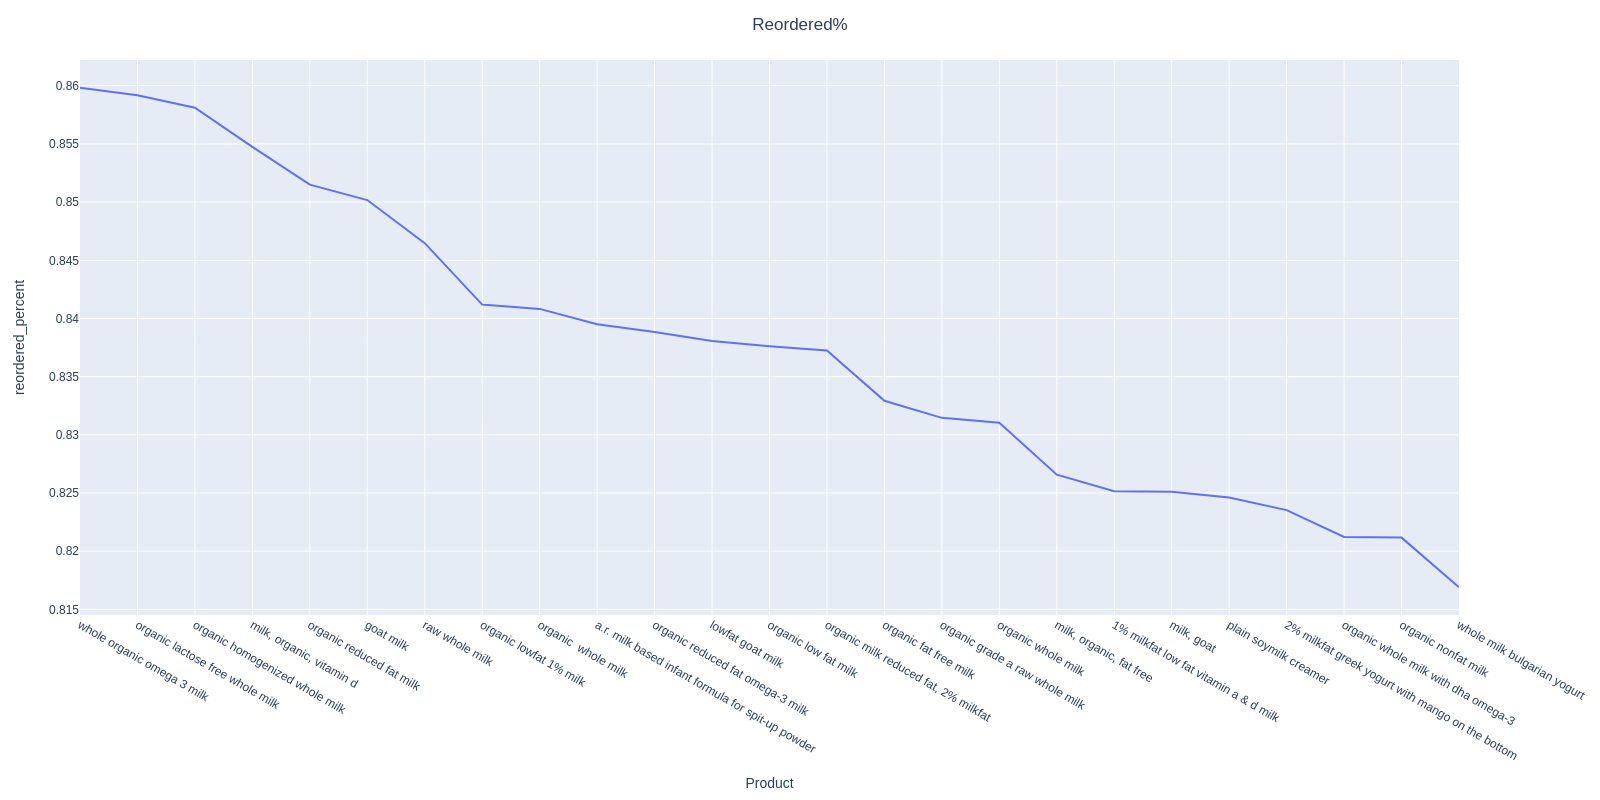

In [ ]:
fig = px.line(top_25_milk, x="product_name", y="reordered_percent")
fig.update_xaxes(title_text="Product", tickmode='linear', type = 'category')
fig.update_layout(title_text="Reordered%",title_x=0.5,width=1600, height=800)
fig.show()

<u>**Observation : WorldCloud for Milk Products%**</u>
> *   Top 25 milk products by reordered% have values between 81% to 86%
*   Product with highest reordered % is whole organic omega 3 milk

## **3.10.Departments**

In [ ]:
dept_all = order_products_all.groupby('department').agg(total=('product_name','count'),reorders = ('reordered','sum'),reordered_percent = ('reordered','mean')).reset_index()
dept_all = dept_all.sort_values(by='reordered_percent', ascending=False)

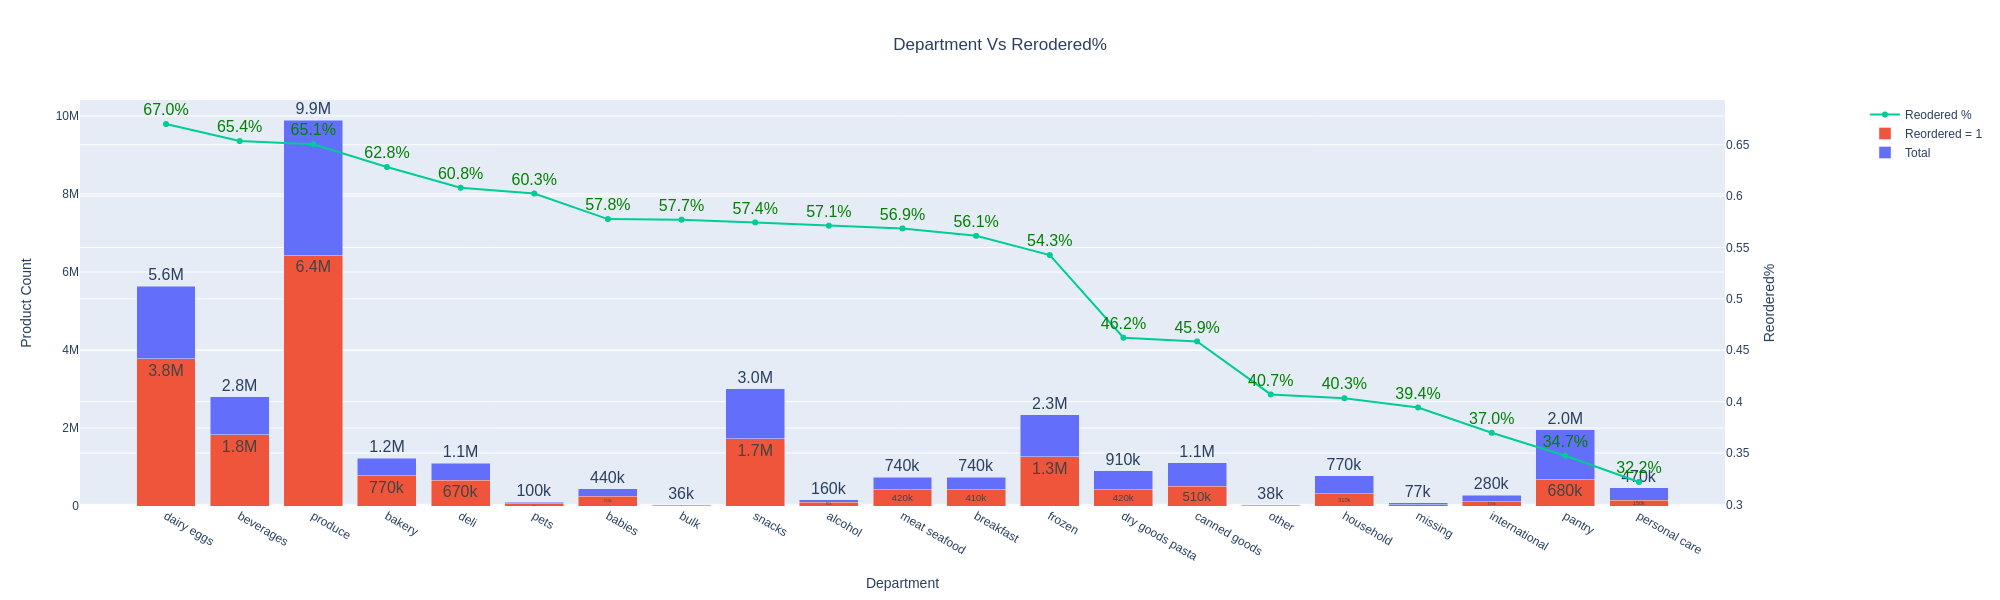

In [ ]:
x, y1, y2, y3 = dept_all['department'], dept_all['total'], dept_all['reorders'], dept_all['reordered_percent']
xtitle, y1title, y2title, charttitle = "Department", "Product Count", "Reordered%", "Department Vs Rerodered%"
dual_axis_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle)

<u>**Observation : Department**</u>
> * Higest Orderered prodcuts is for department Produce(9.8M) and minimum ordered product is for deparment bulk
* Higest reordered% is for dairy,eggs(67%) and the lowest reordered% is for department personal care(32.2%)

## **3.11. Aisles**

In [ ]:
aisle_all = order_products_all.groupby('aisle').agg(total=('product_name','count'),reorders = ('reordered','sum'),reordered_percent = ('reordered','mean')).reset_index()
top_20_aisle = aisle_all.nlargest(n=20, columns=['reordered_percent'])

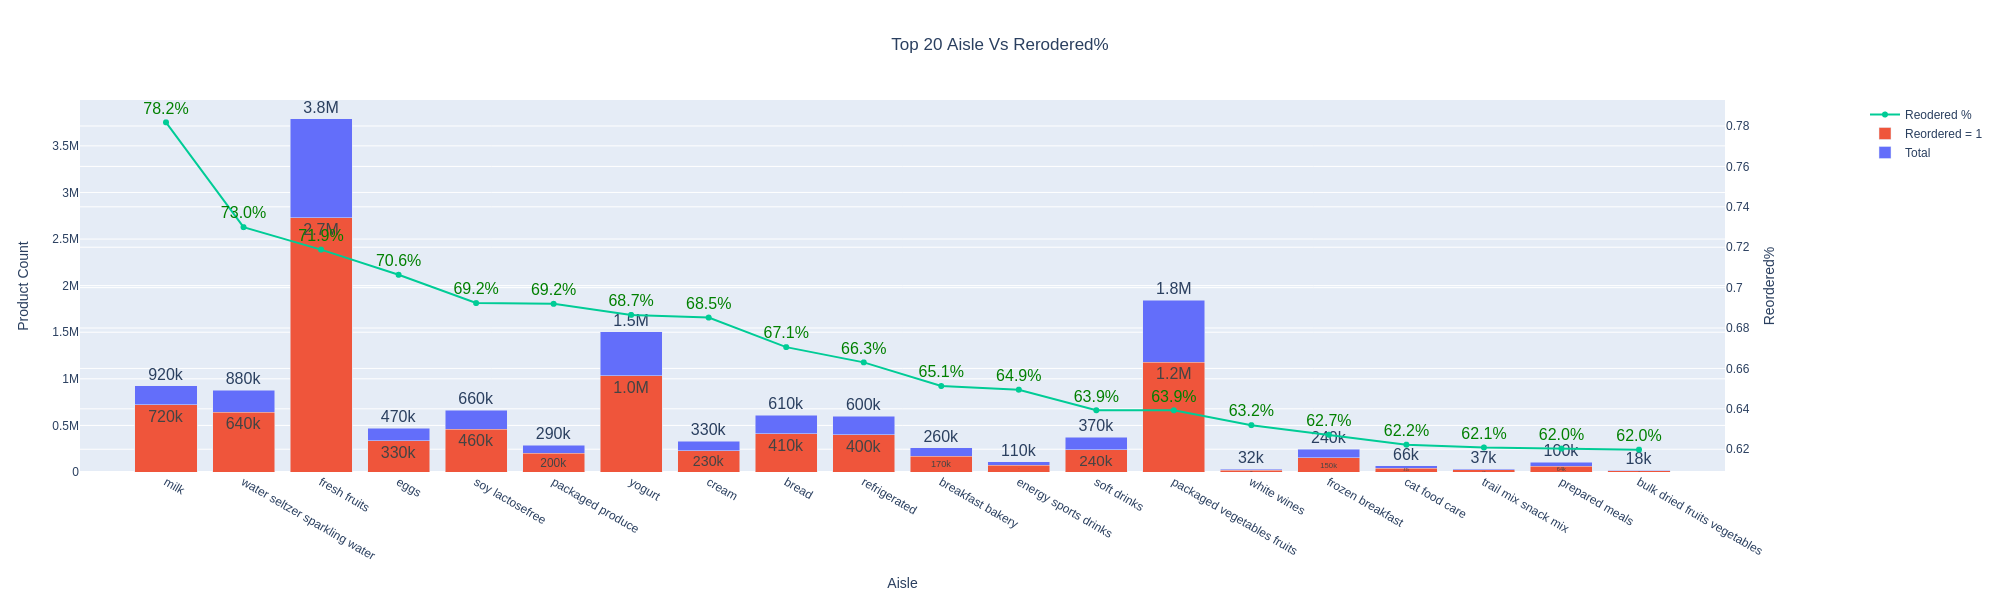

In [ ]:
x, y1, y2, y3 = top_20_aisle['aisle'], top_20_aisle['total'], top_20_aisle['reorders'], top_20_aisle['reordered_percent']
xtitle, y1title, y2title, charttitle = "Aisle", "Product Count", "Reordered%", "Top 20 Aisle Vs Rerodered%"
dual_axis_chart(x,y1,y2,y3,xtitle, y1title,y2title,charttitle)

<u> **Observation : Aisles**</u>
> * Top 20 aisles according to reordered % have values between 78.2%(Milk) and 62%(bulk dried fruits vegetables)

## **3.12. Aisles by Department**

Top 5 Department and corresponsing isles

In [ ]:
top_5_dept = dept_all.head(5)
dept_aisle = order_products_all.groupby(['department','aisle']).agg(reordered_percent=('reordered','mean')).reset_index()
dept_aisle = dept_aisle.merge(top_5_dept,on = 'department' ,how = 'inner' )

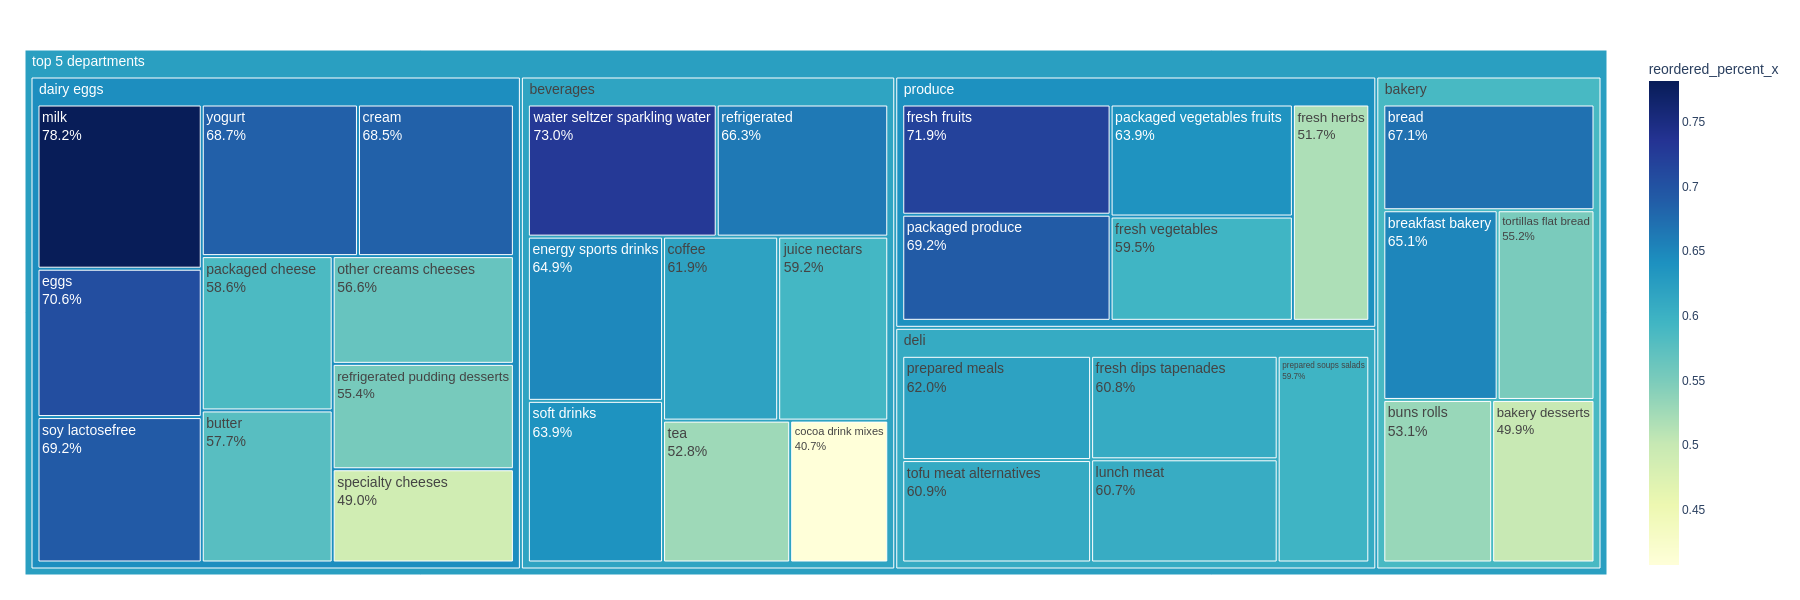

In [ ]:
df = dept_aisle
fig = px.treemap(df, path=[px.Constant("top 5 departments"), 'department', 'aisle'], values='reordered_percent_x', color='reordered_percent_x',color_continuous_scale='YlGnBu', hover_data=["department","aisle","reordered_percent_x"])
fig.data[0].textinfo = 'label+text+value'
fig.data[0].texttemplate = '%{label}<br>%{customdata[2]:.1%}'
fig.update_traces(textfont_size=14)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25),width=1800, height=600)
fig.show()

<u> **Observation : Aisles by department**</u>
> * Top 5 departments with highest reorder% are dairy eggs, beverages, produce, deli, and bakery

* In Dairy eggs - ***milk(78.2)%*** has the highest reordered% <br>
  In Beverages  - ***water seltzer sparkling water(73%)*** has the highest reordered% <br>
  In produce    - ***fresh fruits(71.9%)*** has the highest reordered% <br>
  In deli - ***prepared meals(62%)*** has the highest reordered% <br>
  In bakery - ***bread(67.1%)*** has the highest reordered% 

## **3.13. Products by Aisle**

Top 5 products in top 5 aisles

In [ ]:
top_aisle5 = dept_aisle.sort_values(['department', 'reordered_percent_x'], ascending=False).groupby('department').head(1)['aisle']
aisle_product = order_products_all[order_products_all.aisle.isin(top_aisle5)]
aisle_product = aisle_product.groupby(['aisle','product_name']).agg(reordered_percent=('reordered','mean')).reset_index()
aisle_product = aisle_product.sort_values(['aisle', 'reordered_percent'], ascending=False).groupby('aisle').head(5)

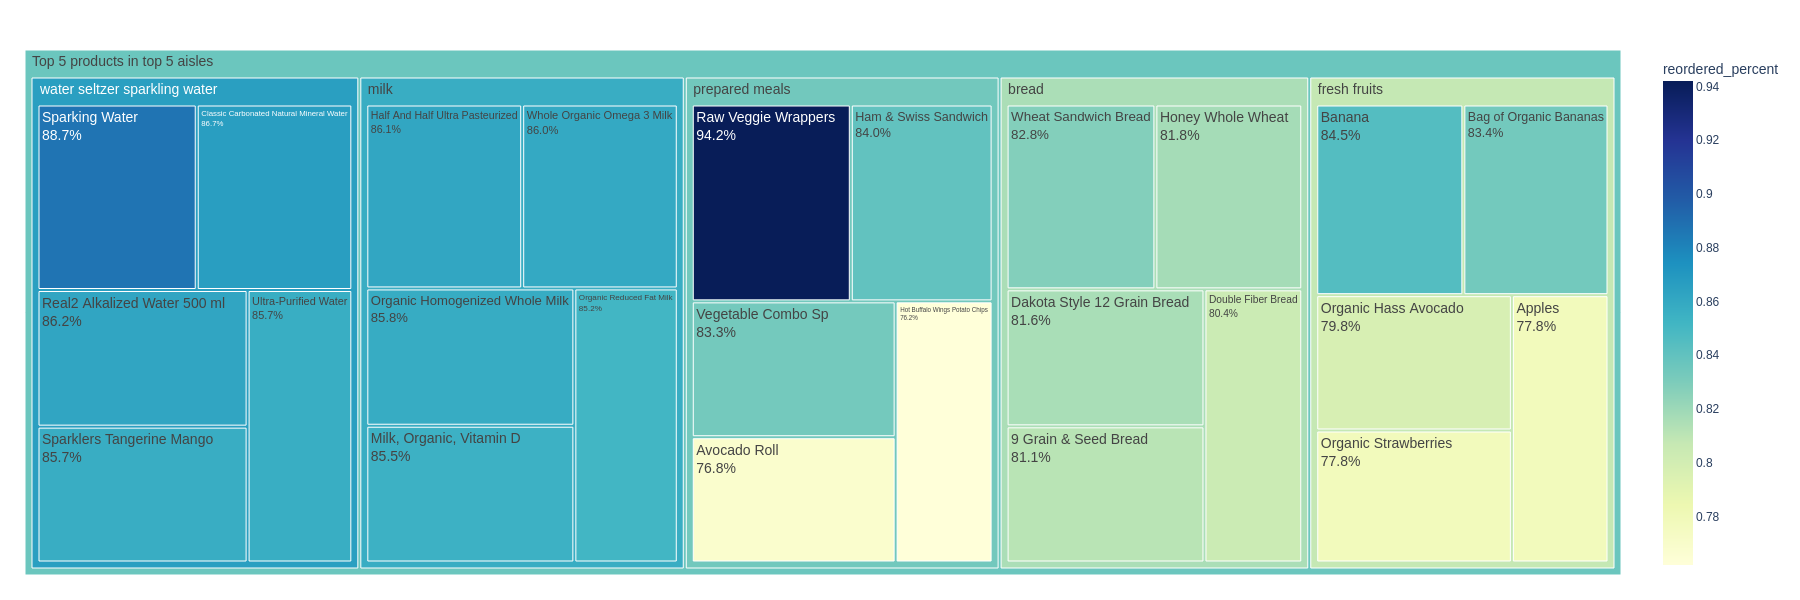

In [ ]:
df = aisle_product
fig = px.treemap(df, path=[px.Constant("Top 5 products in top 5 aisles"), 'aisle', 'product_name'], values='reordered_percent', color='reordered_percent', hover_data=["aisle","product_name","reordered_percent"],
                 color_continuous_scale='YlGnBu')
fig.data[0].textinfo = 'label+text+value'
fig.data[0].texttemplate = '%{label}<br>%{customdata[2]:.1%}'
fig.update_traces(textfont_size=14)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25),width=1800, height=600)
fig.show()

<u>**Observation : Products in Top 5 Aisles**</u>
> * Product with highest reorder% in ***water seltzer sparking water*** aisle is ***sparking water(88.7%)***
* Product with highest reorder% in ***milk*** aisle is ***Half And Half Ultra Pasteurized(86.1)***
* Product with highest reorder% in ***prepared meals*** aisle is ***Raw Veggie Wrapper(94.2%)***
* Product with highest reorder% in ***bread*** aisle is ***Wheat Sandwich Bread(85.9%)***
* Product with highest reorder% in ***fresh fruits*** aisle is ***Banana(82.8%)***

## **3.14. Organics Products**

In [ ]:
order_products_all['organic'] = np.where(order_products_all['product_name'].str.contains("organic",case = False), 1, 0)
organic_counts = order_products_all.groupby('user_id').agg(total=('organic','count'),organic = ('organic','sum'),organic_percent = ('organic','mean')).reset_index()
#organics percent -->> ratio of orgranic products count/total products ordered by user
quantiles = organic_counts.organic_percent.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [ ]:
organic_reordered = order_products_all.groupby('organic').agg(organic_reorder_pct = ('reordered','mean')).reset_index()

In [ ]:
organic_reordered

organic  organic_reorder_pct
0        0             0.569209
1        1             0.635387

> * Reordered% of organic product is significantly higher(6.6%) , ie organic products have higher probability of getting reordered.

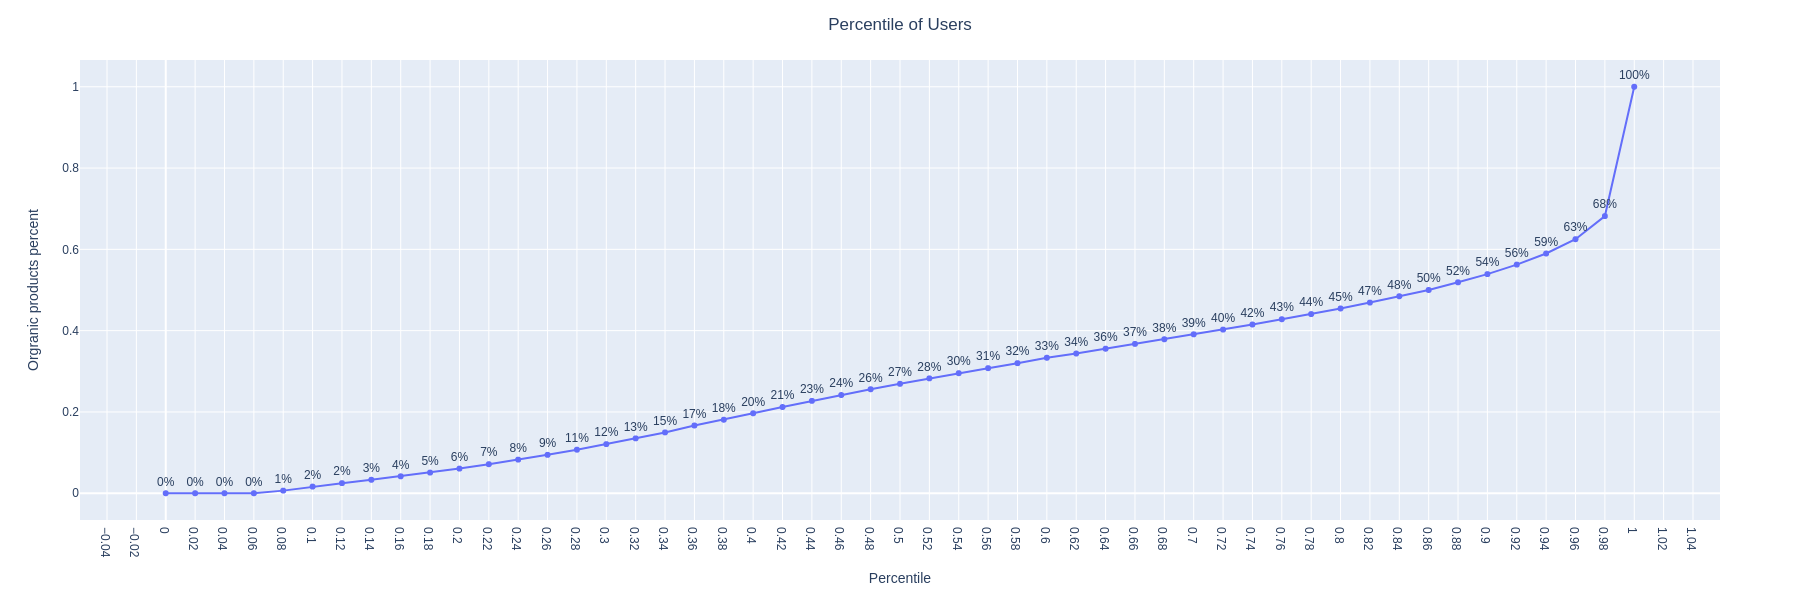

In [ ]:
df = pd.DataFrame()
df['x1']=quantiles.index[::2] 
df['y1']=quantiles.values[::2]
fig = px.line(df, x=df.x1.to_list(), y=df.y1.to_list() ,markers = True, text = df.y1.to_list(),hover_data = ['x1','y1'])
fig.data[0].texttemplate = '%{customdata[1]:.0%}'
fig.update_layout(title_text='Percentile of Users', title_x=0.5,width=1800, height=600)
fig.update_traces(textposition='top center')
fig.update_yaxes(title_text="Orgranic products percent")
fig.update_xaxes(title_text="Percentile",tickmode='linear',dtick = 0.02)
fig.show()

In [ ]:
organic_counts[organic_counts['organic_percent'] > .50].user_id.count()

28297

> *   86th percentile is 50% , ie 14% of users(28,297) ordered more more ogranics products than other other prodcuts.





In [ ]:
#users who ordered more than 50% organic products
mostly_organic_users = organic_counts[organic_counts['organic_percent'] > .50].user_id
#products ordered by users who orders mostly organic products
mostly_organic = order_products_all[order_products_all['user_id'].isin(mostly_organic_users)]
mostly_organic_products = mostly_organic.groupby('product_name').agg(total = ('product_name','count'), reorders  = ('reordered','sum'), reorder_percent = ('reordered','mean')).reset_index()
mostly_organic_products_20 = mostly_organic_products.sort_values(by = 'total',ascending = False).head(20)
mostly_organic_products_20.sort_values(by = 'total',inplace = True)

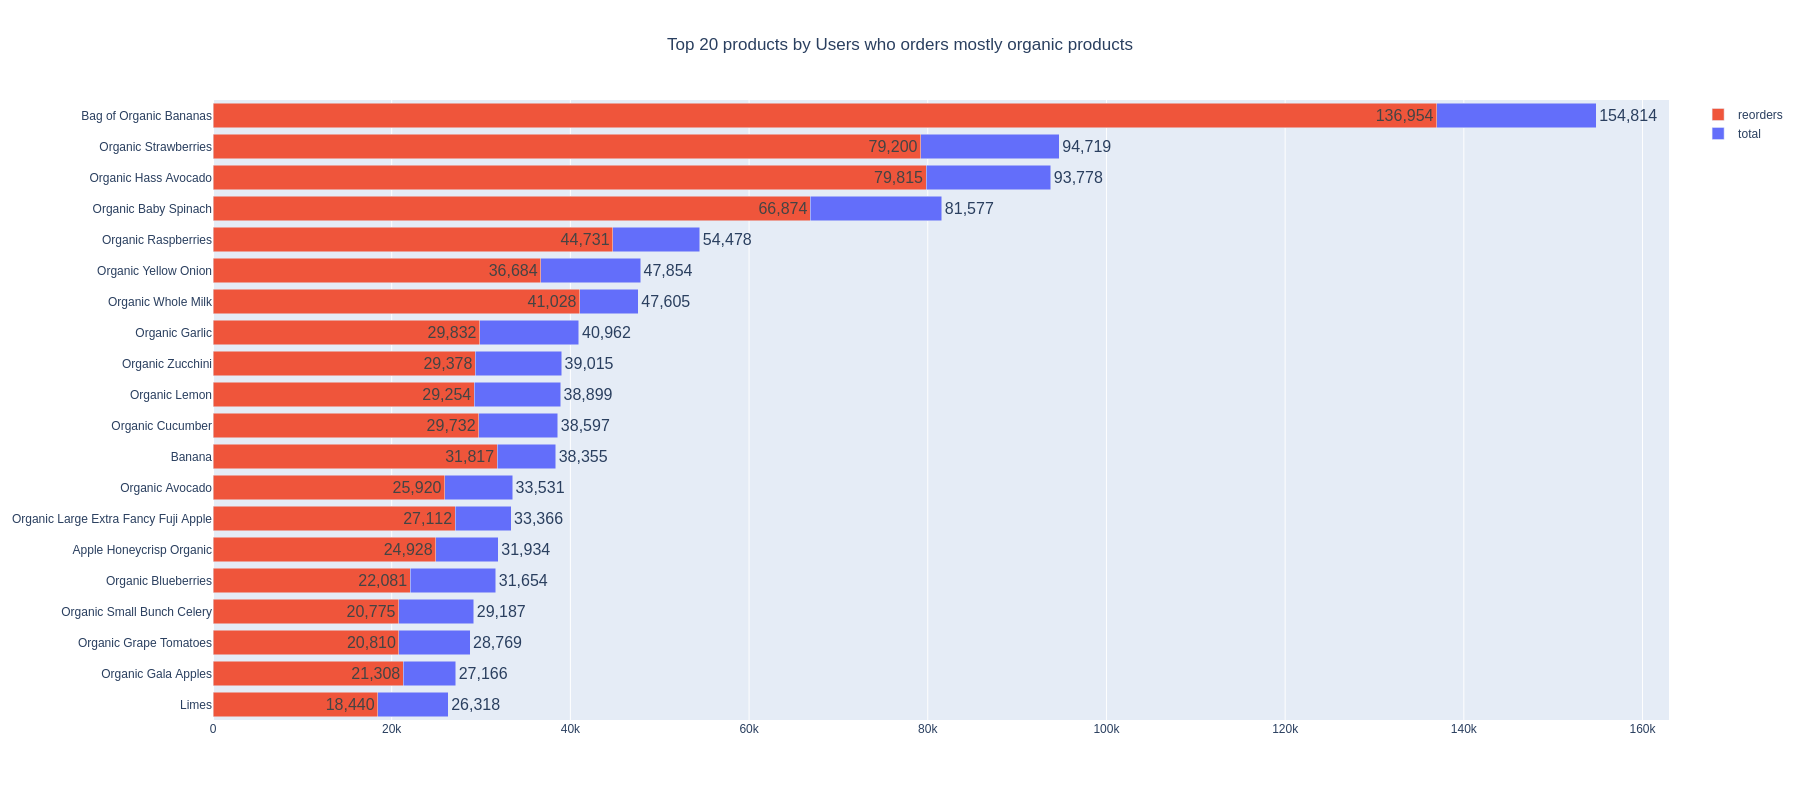

In [ ]:
y,x1,x2,=mostly_organic_products_20['product_name'], mostly_organic_products_20['total'], mostly_organic_products_20['reorders']
x1name, x2name,charttitle = "total" ,"reorders","Top 20 products by Users who orders mostly organic products"
stacked_horizontal_chart(y,x1,x2,x1name,x2name,charttitle)

<u>**Observation : Organic products**</u>
> *   86th percentile is 50%, ie ***14% of users(28,297)*** ordered more ogranic products than other other prodcuts.
*  Top 3 popular products ordered by users who orders mostly organic items are ***Bag of Organic Bananas, Organics Strawberries, Organic Hass Avocado***

## **3.15. Vegetarian Vs Non-Vegetarian**

In [ ]:
#classifying non vegetarians , logic inspired from #https://neo4j.com/videos/neo4j-online-meetup-24-kaggle-instacart-market-basket-analysis-with-neo4j/
order_products_all['vegetarian_prod'] = np.select([
(order_products_all.department.str.contains('meat|seafood') == True) | 
((order_products_all.aisle.str.contains('meat|seafood|jerky') == True ) & (order_products_all.aisle.str.contains('marinades|alternatives') == False ) & (order_products_all.product_name.str.contains('popcorn',case = False) == False ))
], [0], default = 1)

#grouping vegetarian user as users who never ordered non-vegetarian items 
users_by_veg = order_products_all.groupby('user_id').agg(veg_count = ('vegetarian_prod','nunique')).reset_index()
user_veg_df = order_products_all[['user_id','vegetarian_prod']].drop_duplicates()
#veg_count == 1 will give exclusive non-veg and veg users
final_user_veg = users_by_veg[users_by_veg['veg_count'] == 1 ].merge(user_veg_df, on = 'user_id',how = 'inner')
#['vegetarian_prod']==1 , for grouping vegetatian users
final_user_veg = final_user_veg[final_user_veg['vegetarian_prod']==1][['user_id','vegetarian_prod']]
final_user_veg.rename(columns = {'vegetarian_prod':'vegetarian_user'},inplace = True)
order_products_all = order_products_all.merge(final_user_veg, on = 'user_id',how = 'left')
#users that are not exclusively vegetarians are flagged as 0, indicating non-vegetarian users
order_products_all.vegetarian_user.fillna(0,inplace = True)


In [ ]:
#classifying non vegetarians , logic inspired from #https://neo4j.com/videos/neo4j-online-meetup-24-kaggle-instacart-market-basket-analysis-with-neo4j/
order_products_all['vegetarian_prod'] = np.select([
(order_products_all.department.str.contains('meat|seafood') == True) | 
((order_products_all.aisle.str.contains('meat|seafood|jerky') == True ) & (order_products_all.aisle.str.contains('marinades|alternatives') == False ) & (order_products_all.product_name.str.contains('popcorn',case = False) == False ))
], [0], default = 1)

In [ ]:
order_products_all.groupby('vegetarian_prod').agg(veg_prod_reord_pct = ('reordered','mean')).reset_index()

vegetarian_prod  veg_prod_reord_pct
0                0            0.574968
1                1            0.590695

> * Reordered% of vegetarian products are slightly highrer than non vegetarian products. 

In [ ]:
#grouping vegetarian user as users who never ordered non-vegetarian items 
users_by_veg = order_products_all.groupby('user_id').agg(veg_count = ('vegetarian_prod','nunique')).reset_index()
user_veg_df = order_products_all[['user_id','vegetarian_prod']].drop_duplicates()
#veg_count == 1 will give exclusive non-veg and veg users
final_user_veg = users_by_veg[users_by_veg['veg_count'] == 1 ].merge(user_veg_df, on = 'user_id',how = 'inner')
#['vegetarian_prod']==1 , for grouping vegetatian users
final_user_veg = final_user_veg[final_user_veg['vegetarian_prod']==1][['user_id','vegetarian_prod']]
final_user_veg.rename(columns = {'vegetarian_prod':'vegetarian_user'},inplace = True)
order_products_all = order_products_all.merge(final_user_veg, on = 'user_id',how = 'left')
#users that are not exclusively vegetarians are flagged as 0, indicating non-vegetarian users
order_products_all.vegetarian_user.fillna(0,inplace = True)


In [ ]:
order_products_all.groupby('vegetarian_user').agg(veg_prod_reord_pct = ('reordered','mean')).reset_index()

vegetarian_user  veg_prod_reord_pct
0              0.0            0.593508
1              1.0            0.569134

> * Reordered% of non vegetarian users are slightly highrer than vegetarian products. 

In [ ]:
#vegetarian product and vegetarian user fields are added
order_products_all.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  add_to_cart_order  reordered product_name  \
0                     NaN                  1          0         Soda   
1                    15.0                  1          1         Soda   
2                    21.0                  1          1         Soda   
3                    29.0                  1          1         Soda   
4                    28.0                  1          1         Soda   

         aisle department  organic  vegetarian_prod  vegetarian_user  
0  soft drinks  beverages        0                1              0.0  
1  soft drinks  beverages        0                1              0.0  
2  soft drinks  beverages        0                1              0.0  
3  soft drinks  beverages        0                1              0.0  
4  soft drinks  beverages        0                1              0.0

In [ ]:
prods_total = order_products_all.groupby('vegetarian_prod').agg(count = ('product_name','nunique')).reset_index()
user_total = order_products_all.groupby('vegetarian_user').agg(count = ('user_id','nunique')).reset_index()

In [ ]:
print("Total Products" ,order_products_all.product_name.nunique())
print("Total Users" ,order_products_all.user_id.nunique())

Total Products 49685
Total Users 206209


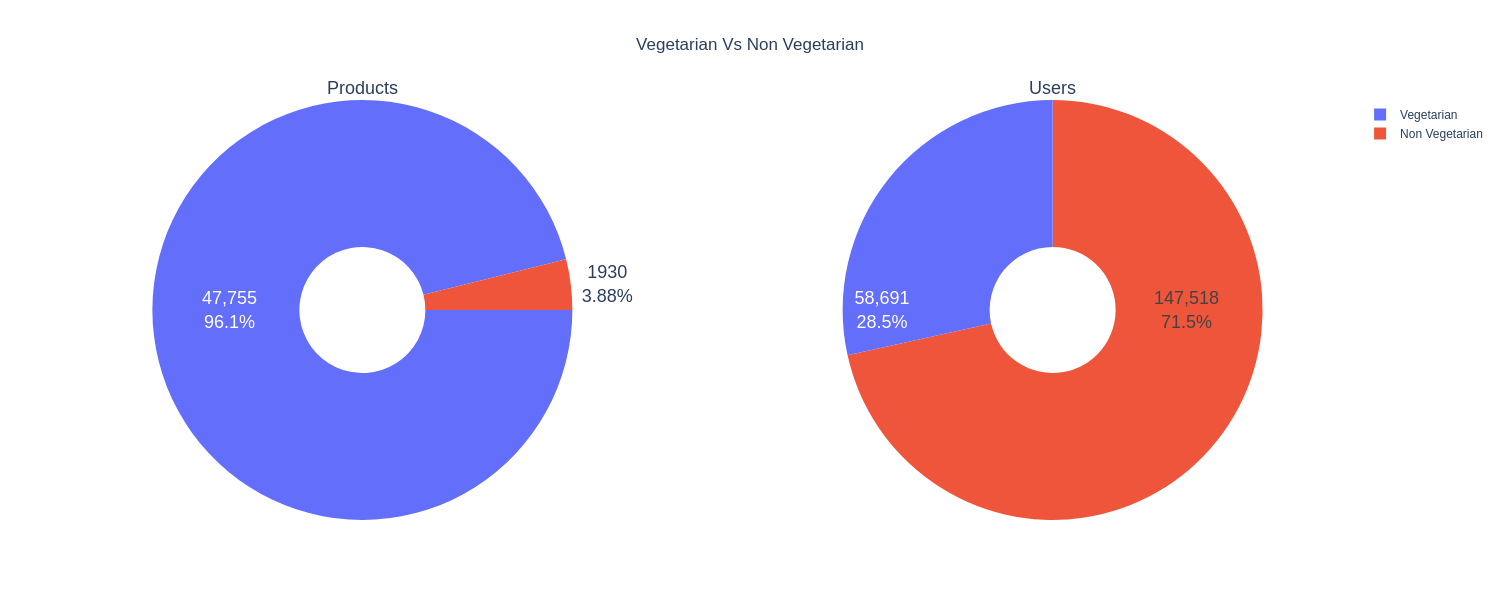

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]],subplot_titles=("Products", "Users"))
fig.add_trace(go.Pie(labels= ["Non Vegetarian","Vegetarian"], values=prods_total['count'], textinfo='value+percent',insidetextorientation='radial',hole=.3 ,rotation = 90),row=1, col=1)
fig.add_trace(go.Pie(labels= ["Non Vegetarian","Vegetarian"], values=user_total['count'], textinfo='value+percent',insidetextorientation='radial',hole=.3 ),row=1, col=2)
fig.update_traces( textfont_size=18)
fig.update_annotations(font_size=18)
fig.update_layout( title_text="Vegetarian Vs Non Vegetarian",title_x=0.5,height=600, width=1500)
fig.show()

In [ ]:
non_veg_products = order_products_all[order_products_all['vegetarian_prod']== 0].groupby('product_name').agg(total = ('vegetarian_prod','count'), reorders  = ('reordered','sum'), reorder_percent = ('reordered','mean')).reset_index()
non_veg_products.sort_values(by = 'total',inplace = True,ascending = False)
non_veg_products_20= non_veg_products.head(20)
non_veg_products_20.sort_values(by = 'total',inplace = True )

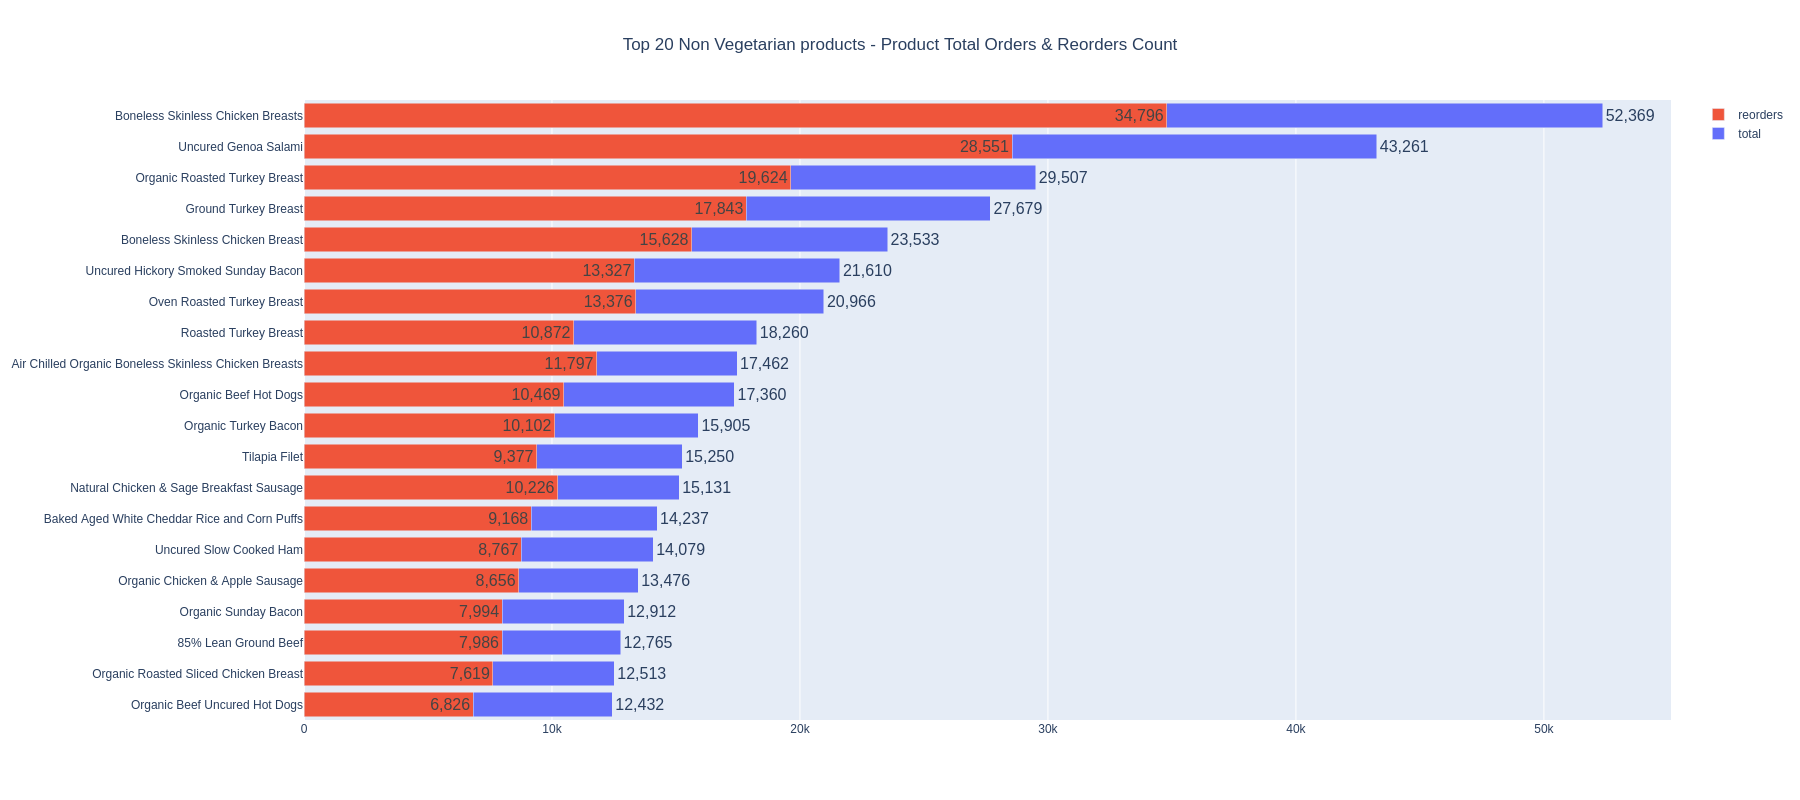

In [ ]:
y,x1,x2,=non_veg_products_20['product_name'], non_veg_products_20['total'], non_veg_products_20['reorders']
x1name, x2name,charttitle = "total" ,"reorders","Top 20 Non Vegetarian products - Product Total Orders & Reorders Count"
stacked_horizontal_chart(y,x1,x2,x1name,x2name,charttitle)

<u>**Observation : Vegetarian Vs Non-Vegetarian**</u>
> *   Only 3.8%(1,930) products are non vegetarians products out of 49,685 products
*   28.5%(58,691) products are vegetarian users out of total 206209 users
*   3 Most popular Non Veg items are Boneless Skinless Chicken Breasts, Uncured Genoa Salami	, Uncured Genoa Salami	

## **3.16. Add to Cart Order Vs Products**

In [ ]:
add_to_order_products = order_products_all.groupby(['product_name','add_to_cart_order']).agg(total = ('product_name','count'),reorders = ('reordered','sum')).reset_index()
add_to_order_products1 = add_to_order_products[add_to_order_products['add_to_cart_order']==1].sort_values(by = 'total', ascending = False)
top20add_to_order_products1 = add_to_order_products1.head(20).sort_values(by = 'total', ascending = True)

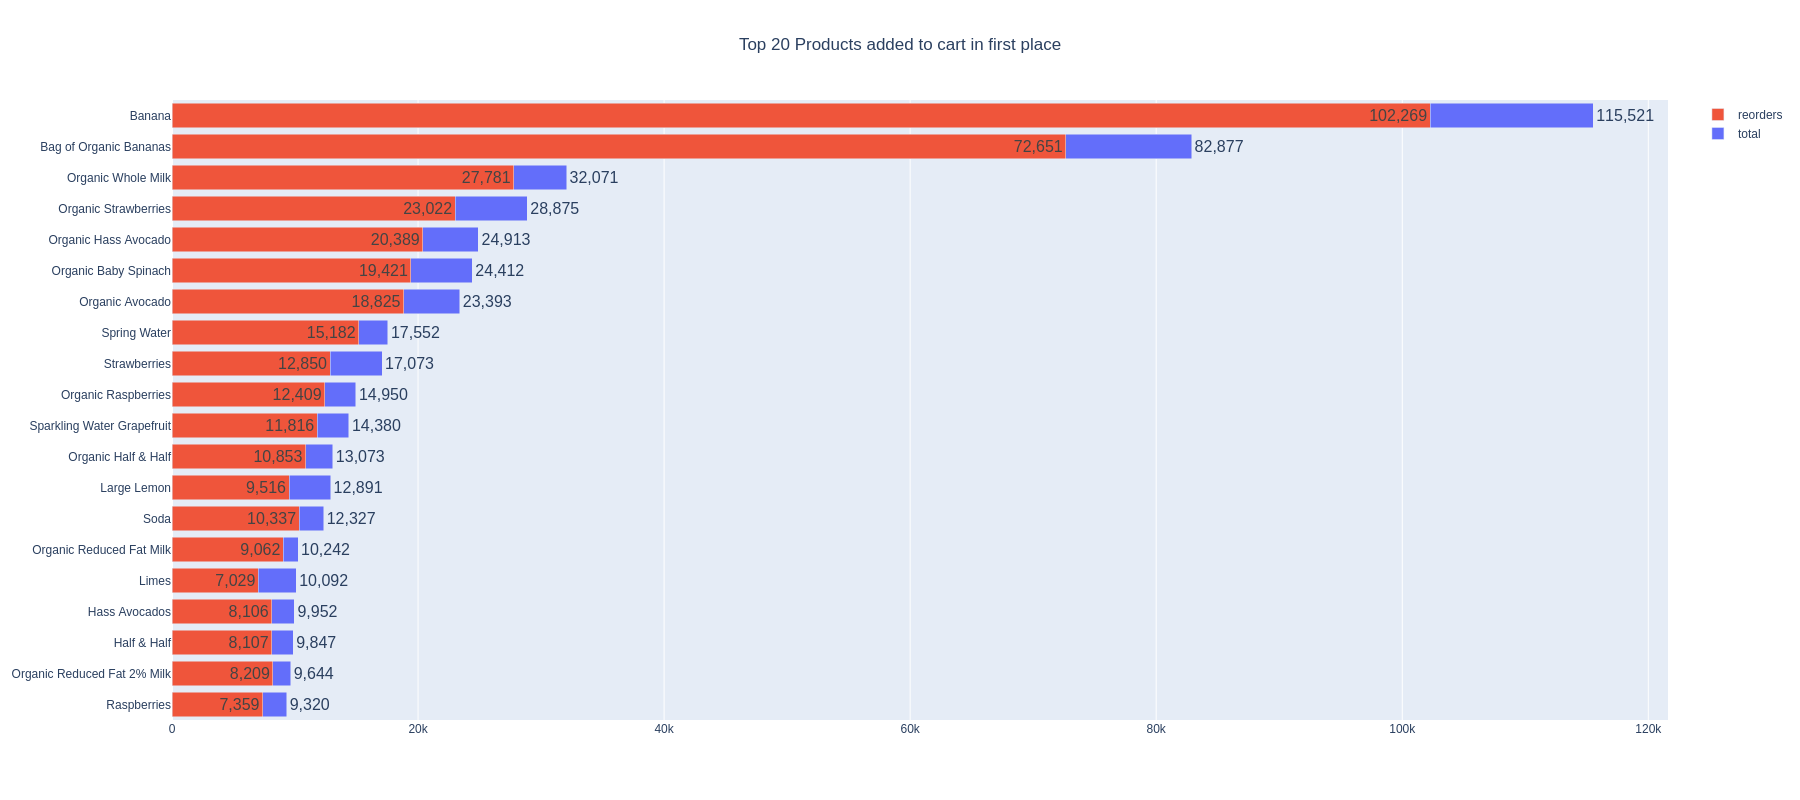

In [ ]:
y,x1,x2,=top20add_to_order_products1['product_name'], top20add_to_order_products1['total'], top20add_to_order_products1['reorders']
x1name, x2name,charttitle = "total" ,"reorders","Top 20 Products added to cart in first place"
stacked_horizontal_chart(y,x1,x2,x1name,x2name,charttitle)

In [ ]:
total_orders = order_products_all.order_id.nunique()
banana1 = int(top20add_to_order_products1[top20add_to_order_products1['product_name']=='Banana'].total)
print("Percentage of orders with Banana added to cart first {:.1%}".format(banana1/total_orders))

Percentage of orders with Banana added to cart first 3.5%


In [ ]:
#finding products added to cart order = 1 , 2 for all all orders and concatenating first 2 products to find the common products ordered at second place
orders2 = order_products_all[(order_products_all['add_to_cart_order']<3) ][['order_id','add_to_cart_order','product_name']]
first2_prods = orders2.pivot(index="order_id", columns=["add_to_cart_order"],values="product_name").reset_index()
first2_prods = first2_prods.dropna()
first2_prods['products'] = first2_prods[[1,2]].agg('-->'.join, axis=1)

In [ ]:
first2_prods.head()

add_to_cart_order  order_id  \
0                         1   
1                         2   
2                         3   
3                         4   
4                         5   

add_to_cart_order                                                  1  \
0                                                   Bulgarian Yogurt   
1                                                 Organic Egg Whites   
2                  Total 2% with Strawberry Lowfat Greek Strained...   
3                                            Plain Pre-Sliced Bagels   
4                                             Bag of Organic Bananas   

add_to_cart_order                                              2  \
0                  Organic 4% Milk Fat Whole Milk Cottage Cheese   
1                                          Michigan Organic Kale   
2                                         Unsweetened Almondmilk   
3                                        Honey/Lemon Cough Drops   
4                                           Just Crisp, Parmesan   

add_to_cart_order                                           products  
0                  Bulgarian Yogurt-->Organic 4% Milk Fat Whole M...  
1                         Organic Egg Whites-->Michigan Organic Kale  
2                  Total 2% with Strawberry Lowfat Greek Strained...  
3                  Plain Pre-Sliced Bagels-->Honey/Lemon Cough Drops  
4                      Bag of Organic Bananas-->Just Crisp, Parmesan

In [ ]:
first2_prod_ct = first2_prods[['order_id','products']].groupby('products').agg(count = ('order_id','count')).reset_index()
first2_prod_ct.sort_values(by='count',ascending = False, inplace = True)
#top 25 products added at add to cart order = 2 when Banana/Bag of Organic Bananas/Organic Whole milk is added first to cart
banana_orders = first2_prod_ct[first2_prod_ct.products.str.startswith('Banana-->')].head(25)
#Total count of orders for a product where it's added to cart first
banana1_ct = order_products_all[(order_products_all.add_to_cart_order ==1 ) & (order_products_all.product_name == 'Banana')].order_id.count()
# ratio between # times product was added second at cart with banana at first place and total number of times banana was added to cart first
banana_orders['percent'] = banana_orders['count']/banana1_ct

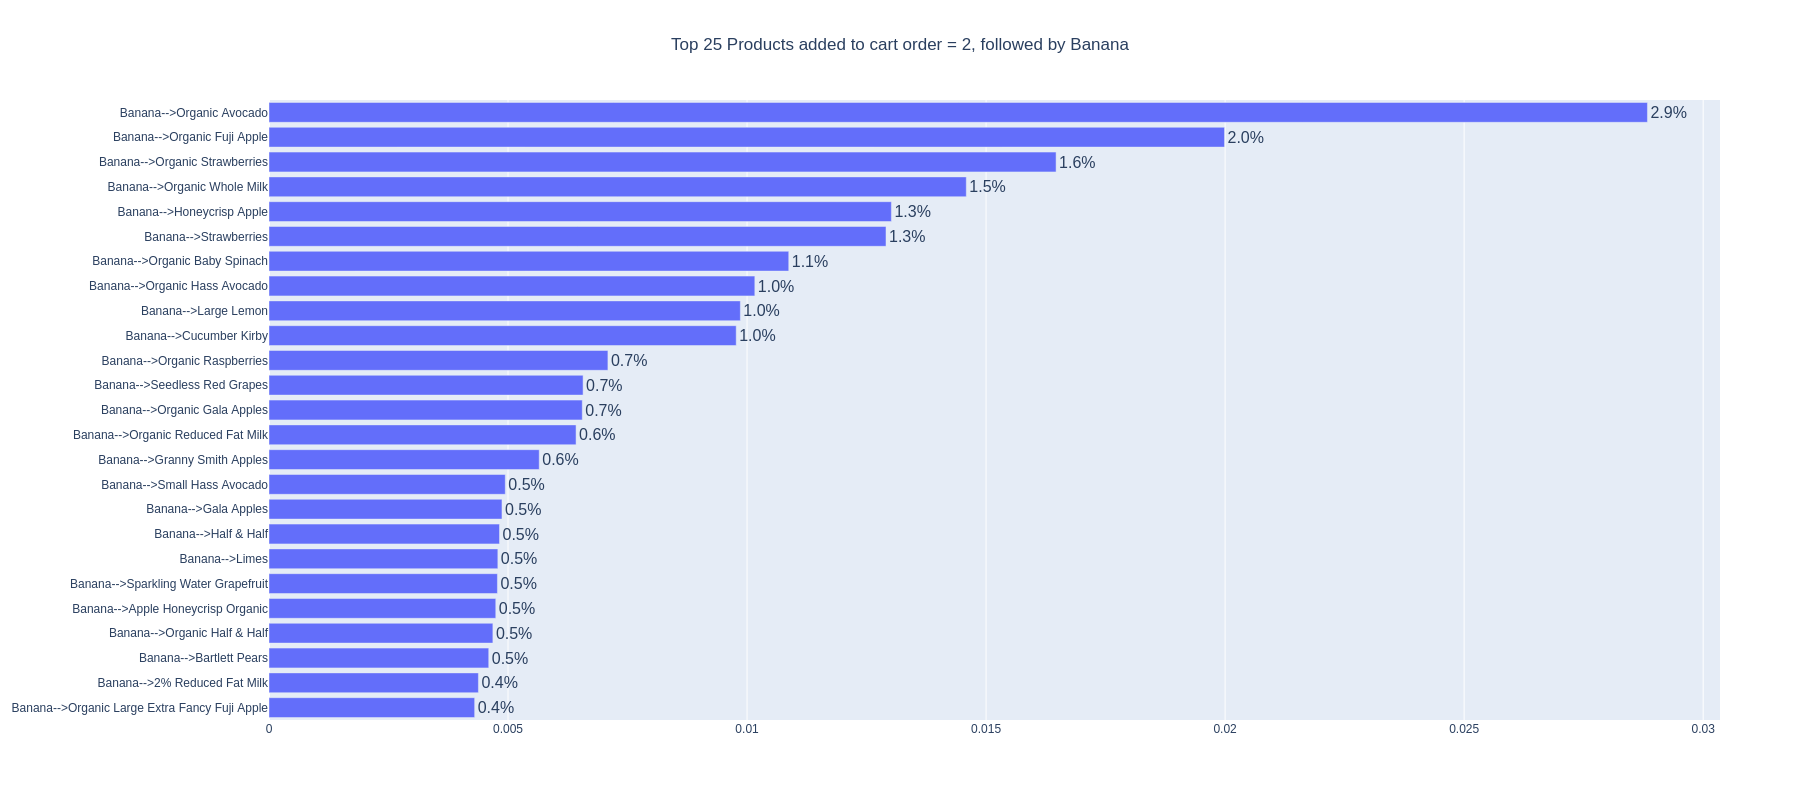

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(name = 'reorders',y=banana_orders['products'],x=banana_orders['percent'],orientation='h',text = banana_orders['percent'],textposition = 'outside' , texttemplate='%{text:,.1%}',textfont_size = 16))
fig.update_layout( title_text="Top 25 Products added to cart order = 2, followed by Banana",title_x=0.5, barmode='stack',width=1800, height=800)
fig.update_yaxes({'categoryorder':'total ascending'})
fig.show()

<u>**Observation : Add to Cart Order Vs Product**</u>
> *   Topmost product that's added to cart first by user is Banana(3.5% - 115,521)
*   With Banana Added to Cart first, most common prooducts added to cart following Banana is Organic Avocado(2.9% times) , Organic Fuji Apple(2%). Many Fruits and Dairy are added following Banana in first place

## **<u>EDA - Summary</u>**

> * Median order per user is 10, majority of users had between 3 and 42 orders(92%)
* Median orders with reorders per user is 8, majority of users had between 1 and 40 orders with reorders(90%)
* Order per user is highest on Day 0 and lowest on Day 4
* Order per user is highest during Hour 9 and lowest duing Hour 4
* Reordered% is highest on Day 1 and lowest on Day 6
* Reordered% is highest at Hour 7 and lowest at Hour 2
* Total orders and reordered products are highest on Day 0 between 9 to 16
* On all days reordered % is highest between hours 4 and 9 and lowest is at hour 1 (except day 1)
* Reorder% is the highest for orders with days since prior order = 0 , ie products purchased on the same day mostly are reordered items
* Reordered items are more days_since_prior order 7, indicating many reorders items on day 7. It's also higher on days 14 (bi-weekly) and 21(tri-weekly).
* Add to cart order and Reordered% are directly related, the products added to cart is the first positions have higher probability of getting reordered.
* Highest reordered% is for the department dairy&eggs, and milk aisle has highest reordered% in all the aisles.
* Organic products have significantly higher reodered% than non-organic products
* Non Vegetarian products have slightlt lesses reordered% than vegetarian products.
* Some products have higher chances of being added followed by a another product, so the add_to_cart_order for user can give insights into such behaviours.

Since there is a pattern between these features and reordered%, it will be useful in identifying which products will be reordered by user. We will create more features from these existing feature in the next steps.

# **4. Feature Engineering**

## <u> Read preprocessed files </u>

In [ ]:
order_products_prior_merged = pd.read_pickle('/content/drive/MyDrive/Instacart/order_products_prior_merged.pickle')
orders = pd.read_csv('/content/drive/MyDrive/Instacart/orders.csv' )
products = pd.read_csv('/content/drive/MyDrive/Instacart/products.csv' )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [ ]:
print("No:of unique users: {:,d}".format(orders.user_id.nunique()))
print("No:of unique orders: {:,d}".format(orders.order_id.nunique()))

No:of unique users: 206,209
No:of unique orders: 3,421,083


In [ ]:
print("Total Orders in Prior : {:,d}".format(orders.eval_set.value_counts().loc['prior']))
print("Total Orders in Train : {:,d}".format(orders.eval_set.value_counts().loc['train']))
print("Total Orders in Test : {:,d}".format(orders.eval_set.value_counts().loc['test']))
print("Total Orders in Train & Test : {:,d}".format(orders.eval_set.value_counts().loc['train']+orders.eval_set.value_counts().loc['test']))

Total Orders in Prior : 3,214,874
Total Orders in Train : 131,209
Total Orders in Test : 75,000
Total Orders in Train & Test : 206,209


* There are total 3,421,083 orders.
* 3,214,874 orders in prior and the last order of each user is split between train and test (206,209 orders corresponding to 206,209 users)


**Verifying last order for users**

In [ ]:
orders[orders.user_id == 1]

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0    2539329        1    prior             1          2                  8   
1    2398795        1    prior             2          3                  7   
2     473747        1    prior             3          3                 12   
3    2254736        1    prior             4          4                  7   
4     431534        1    prior             5          4                 15   
5    3367565        1    prior             6          2                  7   
6     550135        1    prior             7          1                  9   
7    3108588        1    prior             8          1                 14   
8    2295261        1    prior             9          1                 16   
9    2550362        1    prior            10          4                  8   
10   1187899        1    train            11          4                  8   

    days_since_prior_order  
0                      NaN  
1                     15.0  
2                     21.0  
3                     29.0  
4                     28.0  
5                     19.0  
6                     20.0  
7                     14.0  
8                      0.0  
9                     30.0  
10                    14.0

> Last order_number for user 1 is 11, which is in the train set

In [ ]:
orders[orders.user_id == 3]

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
26   1374495        3    prior             1          1                 14   
27    444309        3    prior             2          3                 19   
28   3002854        3    prior             3          3                 16   
29   2037211        3    prior             4          2                 18   
30   2710558        3    prior             5          0                 17   
31   1972919        3    prior             6          0                 16   
32   1839752        3    prior             7          0                 15   
33   3225766        3    prior             8          0                 17   
34   3160850        3    prior             9          0                 16   
35    676467        3    prior            10          3                 16   
36    521107        3    prior            11          0                 18   
37   1402502        3    prior            12          1                 15   
38   2774568        3     test            13          5                 15   

    days_since_prior_order  
26                     NaN  
27                     9.0  
28                    21.0  
29                    20.0  
30                    12.0  
31                     7.0  
32                     7.0  
33                     7.0  
34                     7.0  
35                    17.0  
36                    11.0  
37                    15.0  
38                    11.0

> last order_number for user 3 is 13, which is in the test set

## <u> Creating Train & Test Datasets </u>

Order table contains eval_set with
* prior - prior order of users, for feature engineering
* train - for training the model
* test  - for testing the model (for kaggle submission, we do not have labels for this 75K records)



Now we have to generate train and test datasets for training the maching learning model.

<u> **Process** </u>  <br> 
1. For each user, get the products purchased by users in prior order dataset (order_products_prior_merged)
2. Create features from the prior orders, we can have 4 types of features
    *   User Related Features
    *   Order Related Featues
    *   Product Related Featues
    *   User & Product related Features
3. Create the predicted variable **in_last_order** , merge the dataset with order_products_train. if there product is reordered in this dataset for the user --> in_last_order = 1 else 0 in our final dataset.

<u> **Format of train & test dataset** </u>
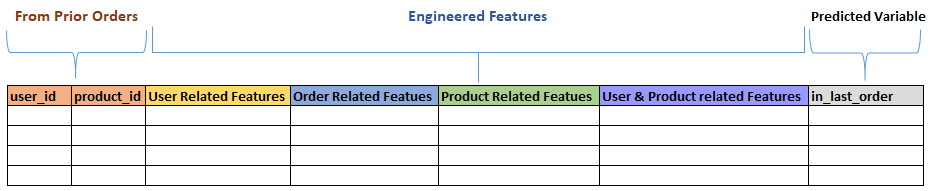



### <u> Prior orders for users

In [ ]:
#generates dataframe with prior ordered items by users along with other features specific to user-product
order_products_prior_merged = order_products_prior_merged.merge(products[['product_id','product_name']],on = 'product_name', how = 'inner')
prior_data = order_products_prior_merged.groupby(['user_id','product_name','product_id','department','aisle']).agg(mean_add_to_cart = ('add_to_cart_order','mean')).reset_index()
prior_data['mean_add_to_cart'] = prior_data['mean_add_to_cart'].astype(int)   
prior_data.head()                                                

user_id                product_name  product_id  department          aisle  \
0        1    0% Greek Strained Yogurt       38928  dairy eggs         yogurt   
1        1  Aged White Cheddar Popcorn       26088      snacks  popcorn jerky   
2        1      Bag of Organic Bananas       13176     produce   fresh fruits   
3        1              Bartlett Pears       41787     produce   fresh fruits   
4        1       Cinnamon Toast Crunch       13032   breakfast         cereal   

   mean_add_to_cart  
0                 4  
1                 4  
2                 6  
3                 7  
4                 6

> **user_id, product_name, department, aisle** from prior orders <br>
> **mean_add_to_cart_order** - mean position of the product in user's cart

### <u> Order Related Features

In [ ]:
def order_features(orders, prior_data,prior_preprocessed ) :
  #merge with orders table to get last order number and order details for the user
  data = prior_data.merge(orders, on ='user_id', how = 'inner')
  #reordered percentage for day of week
  dow_reord = prior_preprocessed.groupby('order_dow').agg(dow_reord_pct = ('reordered','mean')).reset_index()
  data= data.merge(dow_reord, on ='order_dow',how = 'inner')
  #reordered percentage for hour of day
  hod_reord = prior_preprocessed.groupby('order_hour_of_day').agg(hod_reord_pct = ('reordered','mean')).reset_index()
  data= data.merge(hod_reord, on ='order_hour_of_day',how = 'inner')
  #reordered percentage for days since prior order
  dsp_reord = prior_preprocessed.groupby('days_since_prior_order').agg(dsp_reord_pct = ('reordered','mean')).reset_index()
  data= data.merge(dsp_reord, on ='days_since_prior_order',how = 'inner')
  #reordered percentage for day of week and hour of day combined
  dow_hod_reord = prior_preprocessed.groupby(['order_dow','order_hour_of_day']).agg(dow_hod_reord_pct = ('reordered','mean')).reset_index()
  data= data.merge(dow_hod_reord, on =['order_dow','order_hour_of_day'],how = 'inner')
  #reordered percentage for add to cart order
  atc_reord = prior_preprocessed.groupby('add_to_cart_order').agg(atc_reord_pct = ('reordered','mean')).reset_index()
  data= data.merge(atc_reord, left_on ='mean_add_to_cart',right_on = 'add_to_cart_order',how = 'inner')
  data.drop(columns = ['add_to_cart_order'],inplace = True)

  return data

In [ ]:
train_data = order_features(train_orders, prior_data,order_products_prior_merged )
test_data = order_features(test_orders, prior_data,order_products_prior_merged )
train_data.head()

user_id                              product_name  product_id  department  \
0        1                  0% Greek Strained Yogurt       38928  dairy eggs   
1        1                Aged White Cheddar Popcorn       26088      snacks   
2        1                     Organic String Cheese       25133  dairy eggs   
3       76  Clean Day Fabric Softener Lavender Scent       11984   household   
4       76                         Homestyle Popcorn       25613      snacks   

             aisle  mean_add_to_cart  order_id eval_set  order_number  \
0           yogurt                 4   1187899    train            11   
1    popcorn jerky                 4   1187899    train            11   
2  packaged cheese                 4   1187899    train            11   
3          laundry                 4   3294399    train            10   
4    popcorn jerky                 4   3294399    train            10   

   order_dow  order_hour_of_day  days_since_prior_order  dow_reord_pct  \
0          4                  8                    14.0       0.590979   
1          4                  8                    14.0       0.590979   
2          4                  8                    14.0       0.590979   
3          4                  8                    14.0       0.590979   
4          4                  8                    14.0       0.590979   

   hod_reord_pct  dsp_reord_pct  dow_hod_reord_pct  atc_reord_pct  
0       0.631883       0.628323           0.623302       0.636958  
1       0.631883       0.628323           0.623302       0.636958  
2       0.631883       0.628323           0.623302       0.636958  
3       0.631883       0.628323           0.623302       0.636958  
4       0.631883       0.628323           0.623302       0.636958

> **order_id,	eval_set,	order_number,	order_dow,	order_hour_of_day,	days_since_prior_order** : From orders dataset, last order for user and order details <br>
> <u> For the last order of the user, calculate below reorder % </u> <br>
> **dow_reord_pct** : reordered % for the order dow <br>
>	**hod_reord_pct**	: reordered % for the hour of day <br>
> **dsp_reord_pct**	: reordered % for the days since prior order  of user<br>
> **dow_hod_reord_pct**	: reordered % for the hour of day & day of week  combined <br>
> **atc_reord_pct** : reordered % for add to cart order <br>


### <u> User-Product Related Features

In [ ]:
def user_product_features(data,prior_preprocessed,prior_order) :
  # orders, reorders  - count of orders/reorders by users with the product, reordered% of product by user, stats of add to cart order of product by user
  #last and first orders by user with the product
  prior = prior_preprocessed.groupby(['user_id','product_name']).agg(
    orders = ('product_name','count'),reorders = ('reordered','sum'),user_prod_reord_pct = ('reordered','mean'),median_add_to_cart = ('add_to_cart_order','median'),
    min_add_to_cart = ('add_to_cart_order','min'),max_add_to_cart = ('add_to_cart_order','max'),last_order_number = ('order_number','max'),
    first_order_number = ('order_number','min'),
    ).reset_index()
  data = data.merge(prior,on=['user_id','product_name'],how = 'inner')

  #number of orders since the product was last ordered by the user
  data['orders_since_last_ordered'] = data['order_number'] - data['last_order_number'] - 1
  #number of days since the product was last ordered by the user
  last_order_since = data[['user_id','last_order_number','order_number']].drop_duplicates()
  last_order_since_prod = orders.merge(last_order_since,on= 'user_id',how ='inner')
  last_order_since_prod = last_order_since_prod[(last_order_since_prod.order_number_x > last_order_since_prod.last_order_number) & (last_order_since_prod.order_number_x <= last_order_since_prod.order_number_y)]
  last_order_since_prod= last_order_since_prod.groupby(['user_id','last_order_number']).agg(days_since_prior_ord_prod = ('days_since_prior_order','sum')).reset_index()
  data = data.merge(last_order_since_prod,on=['user_id','last_order_number'],how = 'inner')

  #number of times product ordered by user in last 10 orders 
  last10orders = prior_order.groupby('user_id')['order_number'].nlargest(10).reset_index()
  last10orders1 = last10orders.merge(prior_order,on=['user_id','order_number'],how = 'inner')
  last_10_orders1 =last10orders1[['order_id']]
  order_products_last10 = prior_preprocessed[prior_preprocessed.order_id.isin(last_10_orders1.order_id)]
  # number of time the product was ordered by user in their last x orders(x = 2 to 10)
  for i in range(2,11):
    idx = order_products_last10.groupby('user_id')['order_number'].transform(max) -i   < order_products_last10['order_number'] 
    last_i_prods = order_products_last10[idx]
    if i == 3 :
      order_products_last3 = last_i_prods
    last_i_prods = last_i_prods.groupby(['user_id','product_name']).agg(count_last = ('product_name','count')).reset_index()
    last_i_prods.rename(columns={"count_last": "last"+str(i)+"_count"},inplace = True)
    data = data.merge(last_i_prods,on=['user_id','product_name'],how = 'left')
    data.fillna(0,inplace = True)
  #whether the product was ordered by user in last order, last - 1 order, last - 2 order
  for i in range(3):
    idx = order_products_last3.groupby('user_id')['order_number'].transform(max) - i  == order_products_last3['order_number'] 
    lasti = order_products_last3[idx]
    lasti = lasti.groupby(['user_id','product_name']).agg(last = ('product_name','count')).reset_index()
    lasti.rename(columns={"last": "last"+str(i+1)},inplace = True)
    data = data.merge(lasti,on = ['user_id','product_name'],how = 'left')
    data.fillna(0,inplace = True)
  return data


In [ ]:
prior_order = orders[orders['eval_set']== 'prior']
train_data = user_product_features(train_data,order_products_prior_merged,prior_order)
test_data = user_product_features(test_data,order_products_prior_merged,prior_order)
train_data.head()

user_id                     product_name  product_id  department  \
0        1         0% Greek Strained Yogurt       38928  dairy eggs   
1        1            Organic String Cheese       25133  dairy eggs   
2        1            Cinnamon Toast Crunch       13032   breakfast   
3        1  Organic Unsweetened Almond Milk       35951  dairy eggs   
4        1           Milk Chocolate Almonds       39657      snacks   

             aisle  mean_add_to_cart  order_id eval_set  order_number  \
0           yogurt                 4   1187899    train            11   
1  packaged cheese                 4   1187899    train            11   
2           cereal                 6   1187899    train            11   
3  soy lactosefree                 7   1187899    train            11   
4  candy chocolate                 3   1187899    train            11   

   order_dow  ...  last4_count  last5_count  last6_count  last7_count  \
0          4  ...          1.0          1.0          1.0          1.0   
1          4  ...          4.0          5.0          6.0          7.0   
2          4  ...          2.0          2.0          2.0          2.0   
3          4  ...          1.0          1.0          1.0          1.0   
4          4  ...          1.0          1.0          1.0          1.0   

   last8_count  last9_count  last10_count  last1  last2  last3  
0          1.0          1.0           1.0    1.0    0.0    0.0  
1          8.0          8.0           8.0    1.0    1.0    1.0  
2          2.0          3.0           3.0    1.0    0.0    0.0  
3          1.0          1.0           1.0    1.0    0.0    0.0  
4          1.0          1.0           1.0    1.0    0.0    0.0  

[5 rows x 39 columns]

In [ ]:
train_data.columns

Index(['user_id', 'product_name', 'product_id', 'department', 'aisle',
       'mean_add_to_cart', 'order_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'dow_reord_pct',
       'hod_reord_pct', 'dsp_reord_pct', 'dow_hod_reord_pct', 'atc_reord_pct',
       'orders', 'reorders', 'user_prod_reord_pct', 'median_add_to_cart',
       'min_add_to_cart', 'max_add_to_cart', 'last_order_number',
       'first_order_number', 'orders_since_last_ordered',
       'days_since_prior_ord_prod', 'last2_count', 'last3_count',
       'last4_count', 'last5_count', 'last6_count', 'last7_count',
       'last8_count', 'last9_count', 'last10_count', 'last1', 'last2',
       'last3'],
      dtype='object')

> **orders, reorders**	: Number of the time the product was ordered/reordered by the user <br>
> **user_prod_reord_pct** : reordered% of the product by the user<br>
> **median_add_to_cart,min_add_to_cart,max_add_to_cart** : stats of add to cart of product by the user(including min, max and median) <br>
> **orders_since_last_ordered**	: Number of orders since the product was last ordered by the user <br>
> **days_since_prior_ord_prod** : Number of days since the product was last ordered by the user <br>
> **lastx_count** : number of time products was ordered in last x orders( x = 2 to 10) <br>
> **lastx** : flag indicating whether the product was ordered by the user in ther lastx order (x = 1,2,3)


### <u> Product Related Features

In [ ]:
def product_features(data,prior_preprocessed):
  # Total orders, reorders and reordered% of the product
  prod_reord = prior_preprocessed.groupby('product_name').agg(total_orders_p = ('reordered','count'),total_reorders_p = ('reordered','sum'),
                                                              prod_reord_pct = ('reordered','mean')).reset_index()
  data = data.merge(prod_reord, on ='product_name',how = 'inner')

  # reordered % for department
  dept_reord = prior_preprocessed.groupby('department').agg(dept_reord_pct = ('reordered','mean')).reset_index()
  data = data.merge(dept_reord, on ='department',how = 'inner')

  # reordered % for aisle
  aisl_reord = prior_preprocessed.groupby('aisle').agg(aisl_reord_pct = ('reordered','mean')).reset_index()
  data = data.merge(aisl_reord, on ='aisle',how = 'inner')

  # whether product is organic
  data['organic'] = np.where(data['product_name'].str.contains("organic",case = False), 1, 0)
  prior_preprocessed['organic'] = np.where(prior_preprocessed['product_name'].str.contains("organic",case = False), 1, 0)

  # organic product reordered %
  org_reord = prior_preprocessed.groupby('organic').agg(reord = ('reordered','mean')).reset_index()
  data['organic_reord'] = np.where(data['organic'] == 1 , org_reord[org_reord['organic']==1].reord, org_reord[org_reord['organic']==0].reord)

  # whether product is non vegetarian 
  data['vegetarian_prod'] = np.select([
  (data.department.str.contains('meat|seafood') == True) | 
  ((data.aisle.str.contains('meat|seafood|jerky') == True ) & (data.aisle.str.contains('marinades|alternatives') == False ) &
  (data.product_name.str.contains('popcorn',case = False) == False ))
  ], [0], default = 1)
  prior_preprocessed['vegetarian_prod'] = np.select([
  (prior_preprocessed.department.str.contains('meat|seafood') == True) | 
  ((prior_preprocessed.aisle.str.contains('meat|seafood|jerky') == True ) & (prior_preprocessed.aisle.str.contains('marinades|alternatives') == False ) &
  (prior_preprocessed.product_name.str.contains('popcorn',case = False) == False ))
  ], [0], default = 1)

  # reordered % for veg/non veg products
  veg_reord = prior_preprocessed.groupby('vegetarian_prod').agg(reord = ('reordered','mean')).reset_index()
  data['vegetarian_reord'] = np.where(data['vegetarian_prod'] == 1 , veg_reord[veg_reord['vegetarian_prod']==1].reord , veg_reord[veg_reord['vegetarian_prod']==0].reord)

  #most ordered day for the product
  most_oredered_day_p = prior_preprocessed.groupby(['product_name','order_dow']).agg(most_ord_day_count_p = ('order_dow','count')).reset_index()
  idx= most_oredered_day_p.groupby(['product_name'])['most_ord_day_count_p'].transform(max) == most_oredered_day_p['most_ord_day_count_p']
  most_oredered_day_p = most_oredered_day_p[idx]
  most_oredered_day_p = most_oredered_day_p.groupby('product_name').min().reset_index()
  most_oredered_day_p.rename(columns = {'order_dow':'most_ordered_day_p'}, inplace = True)
  data = data.merge(most_oredered_day_p,on='product_name',how = 'inner')

  #most ordered hour for product
  most_oredered_hour_p = prior_preprocessed.groupby(['product_name','order_hour_of_day']).agg(most_ord_hour_count_p = ('order_hour_of_day','count')).reset_index()
  idx= most_oredered_hour_p.groupby(['product_name'])['most_ord_hour_count_p'].transform(max) == most_oredered_hour_p['most_ord_hour_count_p']
  most_oredered_hour_p = most_oredered_hour_p[idx]
  most_oredered_hour_p = most_oredered_hour_p.groupby('product_name').min().reset_index()
  most_oredered_hour_p.rename(columns = {'order_hour_of_day':'most_ordered_hour_p'}, inplace = True)
  data = data.merge(most_oredered_hour_p,on='product_name',how = 'inner')

  #stats for orders since the product was last ordered by user(mean, median, min, max)
  orders_since_last_ordered_p = data[['product_name','orders_since_last_ordered']].groupby('product_name').agg(
         orders_since_last_ordered_p_mean = ('orders_since_last_ordered','mean'),orders_since_last_ordered_p_median = ('orders_since_last_ordered','median'),
         orders_since_last_ordered_p_max = ('orders_since_last_ordered','max')).reset_index()
  data = data.merge(orders_since_last_ordered_p, on = 'product_name',how = 'inner')

  #stats for days since the product was last ordered user(mean, median, min, max)
  days_since_prior_ord_prod_p = data[['product_name','days_since_prior_ord_prod']].groupby('product_name').agg(
         days_since_prior_ord_prod_p_mean = ('days_since_prior_ord_prod','mean'),days_since_prior_ord_prod_p_median = ('days_since_prior_ord_prod','median'),
         days_since_prior_ord_prod_p_min = ('days_since_prior_ord_prod','min'),days_since_prior_ord_prod_p_max = ('days_since_prior_ord_prod','max')).reset_index()
  data = data.merge(days_since_prior_ord_prod_p, on = 'product_name',how = 'inner')

  return data

In [ ]:
train_data = product_features(train_data,order_products_prior_merged)
test_data = product_features(test_data,order_products_prior_merged)
train_data.head()

user_id              product_name  product_id  department   aisle  \
0        1  0% Greek Strained Yogurt       38928  dairy eggs  yogurt   
1   126208  0% Greek Strained Yogurt       38928  dairy eggs  yogurt   
2   166607  0% Greek Strained Yogurt       38928  dairy eggs  yogurt   
3    52341  0% Greek Strained Yogurt       38928  dairy eggs  yogurt   
4   107764  0% Greek Strained Yogurt       38928  dairy eggs  yogurt   

   mean_add_to_cart  order_id eval_set  order_number  order_dow  ...  \
0                 4   1187899    train            11          4  ...   
1                 2    493810    train             5          4  ...   
2                 3    976232    train            10          4  ...   
3                 7   1653513    train             4          4  ...   
4                 1   1856433    train             8          4  ...   

   most_ord_day_count_p  most_ordered_hour_p  most_ord_hour_count_p  \
0                  3377                   10                   1999   
1                  3377                   10                   1999   
2                  3377                   10                   1999   
3                  3377                   10                   1999   
4                  3377                   10                   1999   

   orders_since_last_ordered_p_mean  orders_since_last_ordered_p_median  \
0                          6.611034                                 2.0   
1                          6.611034                                 2.0   
2                          6.611034                                 2.0   
3                          6.611034                                 2.0   
4                          6.611034                                 2.0   

   orders_since_last_ordered_p_max  days_since_prior_ord_prod_p_mean  \
0                               87                         80.408966   
1                               87                         80.408966   
2                               87                         80.408966   
3                               87                         80.408966   
4                               87                         80.408966   

   days_since_prior_ord_prod_p_median  days_since_prior_ord_prod_p_min  \
0                                50.0                              0.0   
1                                50.0                              0.0   
2                                50.0                              0.0   
3                                50.0                              0.0   
4                                50.0                              0.0   

   days_since_prior_ord_prod_p_max  
0                            364.0  
1                            364.0  
2                            364.0  
3                            364.0  
4                            364.0  

[5 rows x 59 columns]

In [ ]:
train_data.columns

Index(['user_id', 'product_name', 'product_id', 'department', 'aisle',
       'mean_add_to_cart', 'order_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'dow_reord_pct',
       'hod_reord_pct', 'dsp_reord_pct', 'dow_hod_reord_pct', 'atc_reord_pct',
       'orders', 'reorders', 'user_prod_reord_pct', 'median_add_to_cart',
       'min_add_to_cart', 'max_add_to_cart', 'last_order_number',
       'first_order_number', 'orders_since_last_ordered',
       'days_since_prior_ord_prod', 'last2_count', 'last3_count',
       'last4_count', 'last5_count', 'last6_count', 'last7_count',
       'last8_count', 'last9_count', 'last10_count', 'last1', 'last2', 'last3',
       'total_orders_p', 'total_reorders_p', 'prod_reord_pct',
       'dept_reord_pct', 'aisl_reord_pct', 'organic', 'organic_reord',
       'vegetarian_prod', 'vegetarian_reord', 'most_ordered_day_p',
       'most_ord_day_count_p', 'most_ordered_hour_p', 'most_ord_hour_count_p',
       

For Products in prior order, create following fields
> **total_orders_p,total_reorders_p, prod_reord_pct** : total orders, total reorders and reordered % for the product <br>
> **dept_reord_pct**	: Reordered % of department to which product belongs to <br>
> **aisl_reord_pct** : Reordered % of aisle to which product belongs to <br>
> **organic** : Whether product is organic or not, this is a flag <br>
> **organic_reord** : Reordered % for organic/non organic product <br>
> **vegetarian_prod** : Whether product is vegetarian or not, this is a flag <br>
> **vegetarian_reord** : Reordered% for vegetarian/non vegetarian product <br>
> **most_ordered_day_p** : Day which the product gets ordered the most 	 	
> **most_ord_day_count_p** : Count of times the product was ordered on the most ordered day of the week <br>
> **most_ordered_hour_p** : Day which the product gets ordered the most <br>
> **most_ord_hour_count_p** : Count of times the product was ordered on the most ordered day of the week <br>
> **stats on orders_since_last_ordered** : stats on the orders since the product was last ordered by user (mean , median , max) <br>
> **stats on days_since_last_ordered** : stats on the days since the product was last ordered by user (mean , median , max, min) <br>



### <u> User Related Features

In [ ]:
def user_features(data,prior_preprocessed):
  #average products per order
  user_order_prod = prior_preprocessed.groupby(['user_id','order_id']).agg(product_count = ('product_name','count')).reset_index()
  user_order_prod = user_order_prod.groupby('user_id').agg(prod_per_order = ('product_count','mean')).reset_index().astype(int)
  data = data.merge(user_order_prod, on =  'user_id',how = 'inner')
  #most ordered day for user
  user_orders = prior_preprocessed[['user_id','order_id','order_dow','order_hour_of_day','days_since_prior_order']].drop_duplicates()
  most_oredered_day_u = user_orders.groupby(['user_id','order_dow']).agg(most_ord_day_count_u = ('order_dow','count')).reset_index()
  idx= most_oredered_day_u.groupby(['user_id'])['most_ord_day_count_u'].transform(max) == most_oredered_day_u['most_ord_day_count_u']
  most_oredered_day_u = most_oredered_day_u[idx]
  most_oredered_day_u = most_oredered_day_u.groupby('user_id').min().reset_index()
  most_oredered_day_u.rename(columns = {'order_dow':'most_ordered_day_u'}, inplace = True)
  data = data.merge(most_oredered_day_u,on='user_id',how = 'inner')
  #most ordered hour for user
  most_oredered_hour_u = user_orders.groupby(['user_id','order_hour_of_day']).agg(most_ord_hour_count_u = ('order_hour_of_day','count')).reset_index()
  idx= most_oredered_hour_u.groupby(['user_id'])['most_ord_hour_count_u'].transform(max) == most_oredered_hour_u['most_ord_hour_count_u']
  most_oredered_hour_u = most_oredered_hour_u[idx]
  most_oredered_hour_u = most_oredered_hour_u.groupby('user_id').min().reset_index()
  most_oredered_hour_u.rename(columns = {'order_hour_of_day':'most_ordered_hour_u'}, inplace = True)
  data = data.merge(most_oredered_hour_u,on='user_id',how = 'inner')
  #total products and distinct products ordered by user
  user_products = prior_preprocessed.groupby('user_id').agg(total_products_u = ('product_name','count'),
                                                            reordered_products_u = ('reordered','sum'), distinct_products =                                                            ('product_name','nunique'),user_reord_pct = ('reordered','mean')).reset_index()
  data = data.merge(user_products,on='user_id',how = 'inner')
  # Average days between order for a user and corresponding reorder %
  dsp_reord = prior_preprocessed.groupby('days_since_prior_order').agg(days_btwn_order_reord_pct = ('reordered','mean')).reset_index()
  mean_days_between_orders = prior_order.groupby('user_id').agg(mean_days_between_orders = ('days_since_prior_order','mean')).reset_index()
  data = data.merge(mean_days_between_orders,on='user_id',how = 'inner')
  data['mean_days_between_orders'] = data['mean_days_between_orders'].astype(int)
  data = data.merge(dsp_reord, left_on ='mean_days_between_orders', right_on ='days_since_prior_order',how = 'inner')
  data.rename(columns = {'days_since_prior_order_x': 'days_since_prior_order'},inplace = True)
  data.drop(columns = ['days_since_prior_order_y'],inplace = True)
  #basket_size stats
  basket_= prior_order.groupby(['user_id','order_id']).agg(basket_size_total = ('reordered','count'), 
                                                                           basket_size_reordered = ('reordered','sum')).reset_index()
  basket_['isNone'] = np.where(basket_.basket_size_reordered ==0,1,0)
  basket_.groupby('user_id').agg(basket_size_total_mean = ('basket_size_total','mean'),basket_size_total_median = ('basket_size_total','median'),
                               basket_size_total_min = ('basket_size_total','max'),basket_size_total_max = ('basket_size_total','min'),
                               basket_size_reordered_mean = ('basket_size_reordered','mean'),basket_size_reordered_median = ('basket_size_reordered','median'),
                               basket_size_reordered_min = ('basket_size_reordered','max'),basket_size_reordered_max = ('basket_size_reordered','min'),
                               isNone_count = ('isNone','sum'),isNone_pctt = ('isNone','mean')                           
                               ).reset_index()
  #stats for days since the product was last ordered user(mean, median, min, max)
  orders_since_last_ordered_u = data[['user_id','orders_since_last_ordered']].groupby('user_id').agg(
         orders_since_last_ordered_u_mean = ('orders_since_last_ordered','mean'),orders_since_last_ordered_u_median = ('orders_since_last_ordered','median'),
         orders_since_last_ordered_u_max = ('orders_since_last_ordered','max')).reset_index()
  data = data.merge(orders_since_last_ordered_u, on = 'user_id',how = 'inner')
  #stats for days since the product was last ordered user(mean, median, min, max)
  days_since_prior_ord_prod_u = data[['user_id','days_since_prior_ord_prod']].groupby('user_id').agg(
         days_since_prior_ord_prod_u_mean = ('days_since_prior_ord_prod','mean'),days_since_prior_ord_prod_u_median = ('days_since_prior_ord_prod','median'),
         days_since_prior_ord_prod_u_min = ('days_since_prior_ord_prod','min'),days_since_prior_ord_prod_u_max = ('days_since_prior_ord_prod','max')).reset_index()
  data = data.merge(days_since_prior_ord_prod_u, on = 'user_id',how = 'inner')
  return data

In [ ]:
train_data = user_features(train_data,order_products_prior_merged)
test_data = user_features(test_data,order_products_prior_merged)

train_data.head()

user_id                             product_name  product_id  department  \
0        1                 0% Greek Strained Yogurt       38928  dairy eggs   
1        1                    Organic String Cheese       25133  dairy eggs   
2        1          Organic Unsweetened Almond Milk       35951  dairy eggs   
3        1  Organic Unsweetened Vanilla Almond Milk       14084  dairy eggs   
4        1                      Organic Half & Half       49235  dairy eggs   

             aisle  mean_add_to_cart  order_id eval_set  order_number  \
0           yogurt                 4   1187899    train            11   
1  packaged cheese                 4   1187899    train            11   
2  soy lactosefree                 7   1187899    train            11   
3  soy lactosefree                 2   1187899    train            11   
4            cream                 3   1187899    train            11   

   order_dow  ...  user_reord_pct  mean_days_between_orders  \
0          4  ...        0.694915                        19   
1          4  ...        0.694915                        19   
2          4  ...        0.694915                        19   
3          4  ...        0.694915                        19   
4          4  ...        0.694915                        19   

   days_btwn_order_reord_pct  orders_since_last_ordered_u_mean  \
0                   0.583781                          2.833333   
1                   0.583781                          2.833333   
2                   0.583781                          2.833333   
3                   0.583781                          2.833333   
4                   0.583781                          2.833333   

   orders_since_last_ordered_u_median  orders_since_last_ordered_u_max  \
0                                 0.5                                9   
1                                 0.5                                9   
2                                 0.5                                9   
3                                 0.5                                9   
4                                 0.5                                9   

   days_since_prior_ord_prod_u_mean  days_since_prior_ord_prod_u_median  \
0                         66.777778                                29.0   
1                         66.777778                                29.0   
2                         66.777778                                29.0   
3                         66.777778                                29.0   
4                         66.777778                                29.0   

   days_since_prior_ord_prod_u_min  days_since_prior_ord_prod_u_max  
0                             14.0                            190.0  
1                             14.0                            190.0  
2                             14.0                            190.0  
3                             14.0                            190.0  
4                             14.0                            190.0  

[5 rows x 77 columns]

In [ ]:
train_data.columns

Index(['user_id', 'product_name', 'product_id', 'department', 'aisle',
       'mean_add_to_cart', 'order_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'dow_reord_pct',
       'hod_reord_pct', 'dsp_reord_pct', 'dow_hod_reord_pct', 'atc_reord_pct',
       'orders', 'reorders', 'user_prod_reord_pct', 'median_add_to_cart',
       'min_add_to_cart', 'max_add_to_cart', 'last_order_number',
       'first_order_number', 'orders_since_last_ordered',
       'days_since_prior_ord_prod', 'last2_count', 'last3_count',
       'last4_count', 'last5_count', 'last6_count', 'last7_count',
       'last8_count', 'last9_count', 'last10_count', 'last1', 'last2', 'last3',
       'total_orders_p', 'total_reorders_p', 'prod_reord_pct',
       'dept_reord_pct', 'aisl_reord_pct', 'organic', 'organic_reord',
       'vegetarian_prod', 'vegetarian_reord', 'most_ordered_day_p',
       'most_ord_day_count_p', 'most_ordered_hour_p', 'most_ord_hour_count_p',
       

> **prod_per_order** : Average product per order for the user					
> **most_ordered_day_u** : Day which the user ordered the most number of times <br>
> **most_ord_day_count_u** : Number of times the users ordered on the most ordered day <br>
> **most_ordered_hour_u** : Hour which the user ordered the most number of times <br>
> **most_ord_hour_count_u** : Number of times the users ordered on the most ordered Hour <br>
> **total_products** : Total products ordered by the user <br>
> **user_reord_pct** : Reordered% for the user <br>
> **mean_days_between_orders,days_btwn_order_reord_pct** : means days between orders for the users , reordered% for the days between orders <br>
> **stats on orders_since_last_ordered_u** : stats on orders_since_last_ordered including mean , median, max <br>
> **stats on orders_since_last_ordered_u** : stats on orders_since_last_ordered including mean , median, max <br>
> **stats on days_since_last_ordered_u** : stats on days_since_last_ordered including mean , median, max, min

***Setting Target Variable for Train_data***

In [ ]:
def target_variable(data,order_train) :
  order_train = order_train[['order_id','product_name','reordered']]
  data = data.merge(order_train, on =['order_id','product_name'],how = 'left')
  data['reordered']= data.reordered.fillna(0)
  data.rename(columns = {'reordered':'in_last_order'},inplace = True)
  return data

In [ ]:
train_data = target_variable(train_data,order_products_train_merged)

In [ ]:
# Checking for null values
print("Null values in train_data:", train_data.isna().sum().sum())
#print("Null values in test_data_ml:", val_data.isna().sum().sum())
print("Null values in test_data:", test_data.isna().sum().sum())

Null values in train_data: 0
Null values in test_data: 0


# **5. Modeling**

<u> **User Definfed Functions**

In [ ]:
def create_submission_file_threshold(test_data,test_orders,model) :
  test_data = test_data[test_data['in_last_order'] == 1]
  test_data = test_data.groupby(['order_id'])['product_id'].apply(lambda k: " ".join(list(map(str, k.tolist())))).reset_index(name = "products")
  submission = pd.merge(test_orders,test_data, on = 'order_id', how = 'left')
  submission['order_id'] = submission['order_id'].apply(int)
  submission = submission.where(pd.notnull(submission), 'None')
  submission.to_csv("/content/drive/MyDrive/submissions/submission_threshold_{}.csv".format(model), index= False)


In [ ]:
def create_submission_f1_optimized(orders,best_products,model):
  orders['products']= best_products
  orders['order_id'] = orders['order_id'].apply(int)
  orders.drop(['product_id','y_prob'], axis = 1, inplace = True)
  orders.to_csv("/content/drive/MyDrive/submissions/submission_f1opt_{}.csv".format(model), index= False)

### *Splitting Train dataset to train and validation sets*

In [ ]:
#splitting the train dataset by users in the ratio 0.8 :0.2 for train and validation respectively.
train_users_all = train_data.user_id.drop_duplicates()
train_users = train_users_all.sample(frac = 0.8)

val_users = train_users_all.drop(train_users.index)
X_train  = train_data[train_data.user_id.isin(train_users)]
X_val = train_data[train_data.user_id.isin(val_users)]

train_data = X_train[['order_id','user_id','product_id','product_name','in_last_order']] 
val_data = X_val[['order_id','user_id','product_id','product_name','in_last_order']]
y_train = X_train['in_last_order']
y_val = X_val['in_last_order']
#removing columns that are not used in modeling step
X_train = X_train.drop(columns = [ 'product_name','department','aisle','order_id','eval_set','order_dow','order_hour_of_day','product_id','order_id','user_id','in_last_order'])
X_val = X_val.drop(columns = [ 'product_name','department','aisle','order_id','eval_set','order_dow','order_hour_of_day','product_id','order_id','user_id','in_last_order'])
features = X_train.columns

### *Scaling the data*

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

### *Preparing test dataset*

In [ ]:
X_test = test_data.copy()
test_data  =  test_data[['order_id','user_id','product_id','product_name']]
X_test= X_test.drop(columns = [ 'product_name','department','aisle','order_id','eval_set','order_dow','order_hour_of_day','product_id','order_id','user_id'])
X_test = scaler.transform(X_test)

## **5.1.Baseline Model**

* In this model we will be repeating users previous order, this will be our baseline model to which we will compare the rest of the models.


In [ ]:
order_products_prior_merged = pd.read_pickle('/content/drive/MyDrive/Instacart/order_products_prior_merged.pickle')

In [ ]:
X_val_random = val_data.copy()[['order_id','user_id','product_id','product_name']]
idx = order_products_prior_merged.groupby('user_id')['order_number'].transform(max)  == order_products_prior_merged['order_number'] 
last1 = order_products_prior_merged[idx]
last1 = last1[['user_id','product_name']]
last1['in_last_order'] = 1
X_val_random = X_val_random.merge(last1, on = ['user_id','product_name'], how = 'left')
X_val_random.in_last_order.fillna(0,inplace = True)

y_pred_val = X_val_random['in_last_order']
y_val_pred = np.select( [X_val_random['in_last_order'] == 1, X_val_random['in_last_order'] == 0], [np.random.uniform(0.5,1), np.random.uniform(0,0.49)])

print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.6980522847012645


In [ ]:
test_orders = orders[orders['eval_set']=='test'][['order_id']]

In [ ]:
#test 
test_data = X_test.merge(last1, on = ['user_id','product_name'], how = 'left')
test_data.in_last_order.fillna(0,inplace = True)
create_submission_file_threshold(test_data,test_orders, model= 'random')

kaggle score

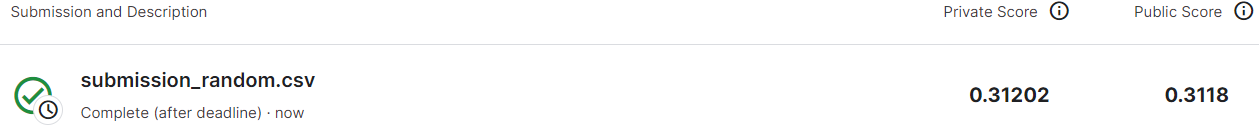

## **5.2.Logistic Regression**

***Training***

*Hyperparameter tuning*

In [ ]:
param_dist = {"C": [ 1e-4, 1e-3, 1e-2, 1e-1]}
clf = LogisticRegression()
lr_grid= GridSearchCV(clf, param_grid=param_dist,cv=2,scoring='neg_log_loss',return_train_score = True)
lr_grid.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1]},
             return_train_score=True, scoring='neg_log_loss')

In [ ]:
print(lr_grid.best_estimator_)

LogisticRegression(C=0.1)


*Training with best parameter*

In [ ]:
clf = LogisticRegression(C= 0.1)
clf.fit(X_train,y_train)

LogisticRegression(C=0.1)

***Validation***

In [ ]:
y_val_pred = clf.predict_proba(X_val)
print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.24774648334316168


*finding best threshold for classification*

In [ ]:
threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
for i in threshold :
  y_pred_val =  (y_val_pred[:,1]>= i).astype(int)
  print('Validation f1 score for ',i,f1_score(y_val,y_pred_val))

Validation f1 score for  0.1 0.3750793144753173
Validation f1 score for  0.2 0.433185510977243
Validation f1 score for  0.3 0.41486883625184523
Validation f1 score for  0.4 0.35853626710597136
Validation f1 score for  0.5 0.2837455797419222
Validation f1 score for  0.6 0.1965727322220206
Validation f1 score for  0.7 0.10974754361452002
Validation f1 score for  0.8 0.03513113492392399
Validation f1 score for  0.9 0.001824134140301284


***Feature importance - Top 20 features***

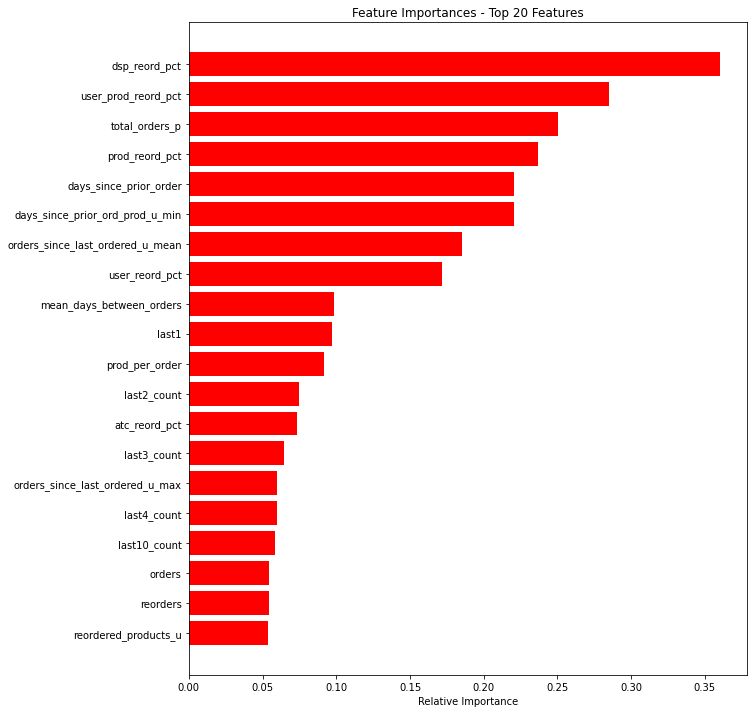

In [ ]:
importances = clf.coef_[0]
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - Top 20 Features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

***Test submission***

*Using fixed threshold of 0.2*

In [ ]:
orders = pd.read_csv('/content/drive/MyDrive/Instacart/orders.csv' )
test_orders = orders[orders['eval_set']=='test'][['order_id']]

In [ ]:
y_test_pred = clf.predict_proba(X_test)
test_data['in_last_order'] = (y_test_pred[:,1]>= 0.2).astype(int)
create_submission_file_threshold(test_data,test_orders,model= 'logistic_regression')

<u>kaggle score

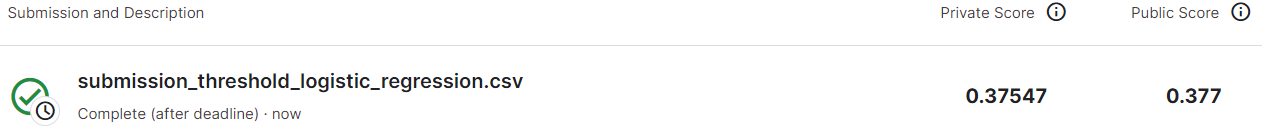

*using f1 optimization script*

In [ ]:
test_data['y_prob'] = clf.predict_proba(X_test)[:,1]
total_proc = 60
orders = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
def multi(i):
  prod = get_best_prediction(orders.iloc[i]['product_id'], orders.iloc[i]['y_prob'], None)
  return prod
pool = mp.Pool(total_proc)
best_products = pool.map(multi, range(orders.shape[0]))
create_submission_f1_optimized(orders,best_products,model = 'logistic_regression')

<u>kaggle score

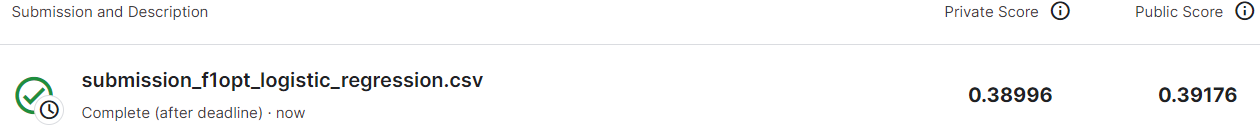

## **5.3 Decision Tree**


***Training***

*hyperparameter tuning* 

In [ ]:
max_depth = [3,5,7,9,11,13,15]
param_grid = {'max_depth': max_depth}
clf = DecisionTreeClassifier()
dt_grid= GridSearchCV(clf, param_grid=param_grid,cv=2,scoring='neg_log_loss',return_train_score = True)
dt_grid.fit(X_train,y_train)
print(dt_grid.best_estimator_)

DecisionTreeClassifier(max_depth=7)


In [ ]:
print(dt_grid.best_estimator_)

DecisionTreeClassifier(max_depth=7)


*Training with best parameter*

In [ ]:
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7)

***Validation***

In [ ]:
y_val_pred = clf.predict_proba(X_val)
print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.24769147771493566


***Feature Importance - Top 20 Features***



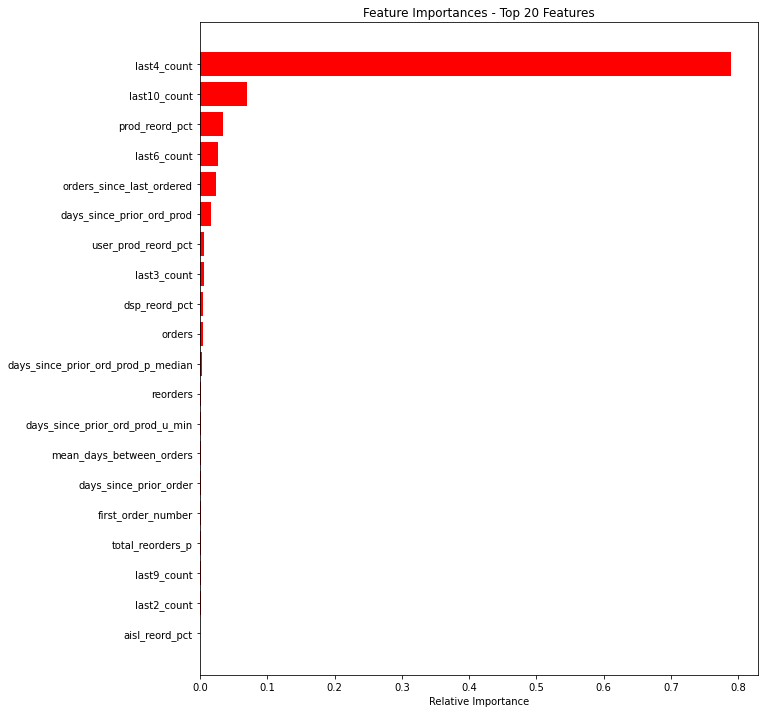

In [ ]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - Top 20 Features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

***Test Submission***

*Using fixed threshold of 0.2*

In [ ]:
y_test_pred = clf.predict_proba(X_test)
test_data['in_last_order'] = (y_test_pred[:,1]>= 0.2).astype(int)
create_submission_file_threshold(test_data,test_orders,model= 'decision_tree')

<u>kaggle score
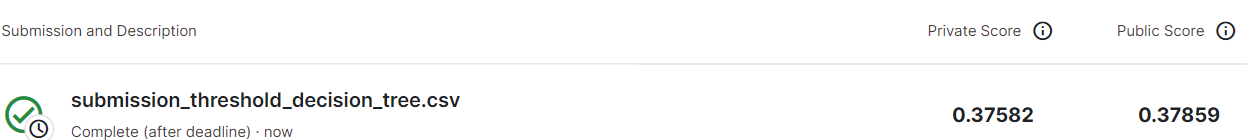

*using f1 optimization script*

In [ ]:
test_data['y_prob'] = clf.predict_proba(X_test)[:,1]
total_proc = 60
orders = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
def multi(i):
  prod = get_best_prediction(orders.iloc[i]['product_id'], orders.iloc[i]['y_prob'], None)
  return prod
pool = mp.Pool(total_proc)
best_products = pool.map(multi, range(orders.shape[0]))
create_submission_f1_optimized(orders,best_products,model = 'decision_tree')

<u>kagge score

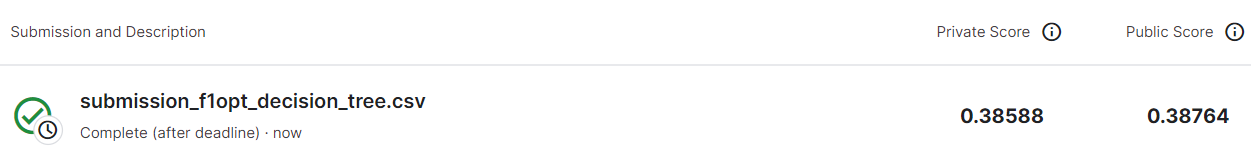

## **5.4 Random Forest**

***Training***

*Hyperparameter tuning*

In [ ]:
param_dist = {
              "n_estimators":sp_randint(20,35),
              "max_depth": sp_randint(10,20),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,45)}
clf = RandomForestClassifier(bootstrap = True)
rf_random = RandomizedSearchCV(clf, param_distributions =param_dist, n_iter = 10,cv=2,scoring='neg_log_loss',n_jobs = 2)
rf_random.fit(X_train,y_train)
print(rf_random.best_params_)

{'max_depth': 18, 'min_samples_leaf': 31, 'min_samples_split': 138, 'n_estimators': 27}


*Training with best parameter*

In [ ]:
clf = RandomForestClassifier(bootstrap = True,max_depth=18,n_estimators = 27,min_samples_split = 138,min_samples_leaf=31)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=18, min_samples_leaf=31, min_samples_split=138,
                       n_estimators=27)

***Feature Importance - Top 20 Features***

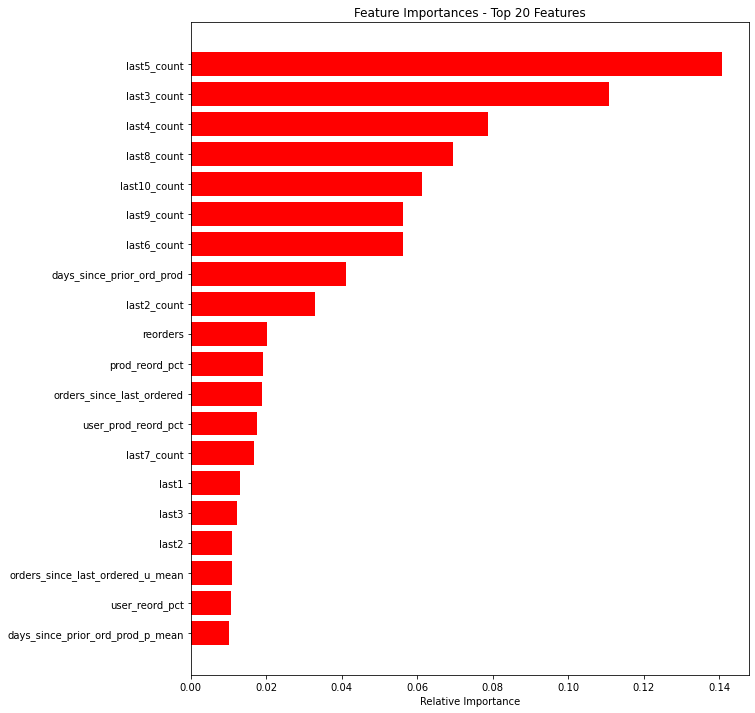

In [ ]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - Top 20 Features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

***Validation***

In [ ]:
y_val_pred = clf.predict_proba(X_val)
print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.24543084726413672


***Test Submission***

*Using fixed threshold of 0.2*

In [ ]:
y_test_pred = clf.predict_proba(X_test)
test_data['in_last_order'] = (y_test_pred[:,1]>= 0.2).astype(int)
create_submission_file_threshold(test_data,test_orders,model= 'random_forest')

<u>kaggle score

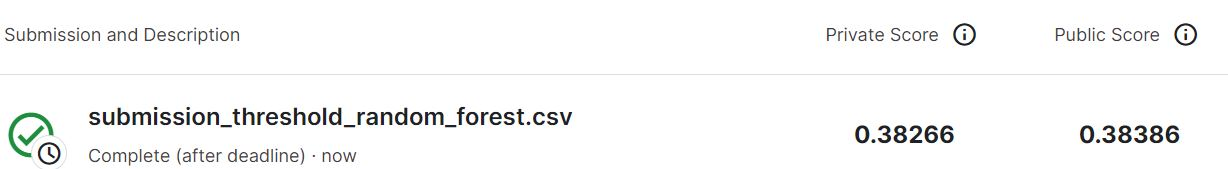

*using f1 optimization script*

In [ ]:
test_data['y_prob'] = clf.predict_proba(X_test)[:,1]
total_proc = 60
orders = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
def multi(i):
  prod = get_best_prediction(orders.iloc[i]['product_id'], orders.iloc[i]['y_prob'], None)
  return prod
pool = mp.Pool(total_proc)
best_products = pool.map(multi, range(orders.shape[0]))
create_submission_f1_optimized(orders,best_products,model = 'random_forest')

<u>kaggle score

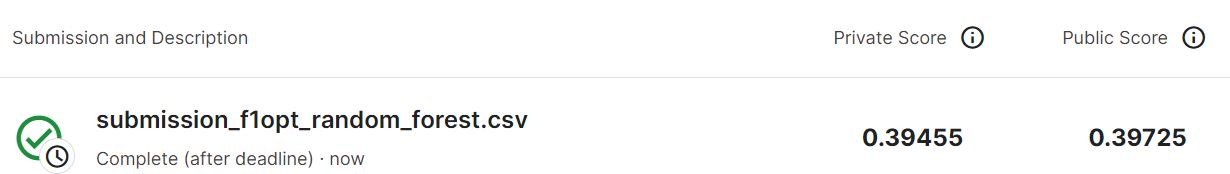

## **5.5 XgBoost**

***Training***

*Hyperparameter tuning*

In [ ]:
clf=XGBClassifier(eval_metric='logloss',objective='binary:logistic',
               tree_method='gpu_hist')
prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,110,120,130,140,150],
     'max_depth':[3,4,5,6,7,8,9,10],
}
xgb_random=RandomizedSearchCV(clf,param_distributions=prams,cv=2,scoring='neg_log_loss')
xgb_random.fit(X_train,y_train)
print(xgb_random.best_params_)

{'n_estimators': 130, 'max_depth': 6, 'learning_rate': 0.1}


*Training with best parameters*

In [ ]:
clf = XGBClassifier(eval_metric='logloss',objective='binary:logistic', n_estimators = 130, max_depth = 6 , learning_rate = 0.1,
               tree_method='gpu_hist')
clf.fit(X_train,y_train)

XGBClassifier(eval_metric='logloss', max_depth=6, n_estimators=130,
              tree_method='gpu_hist')

***Validation***

In [ ]:
y_val_pred = clf.predict_proba(X_val)
print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.24421497710261883


***Feature Importance - Top 20 Features***

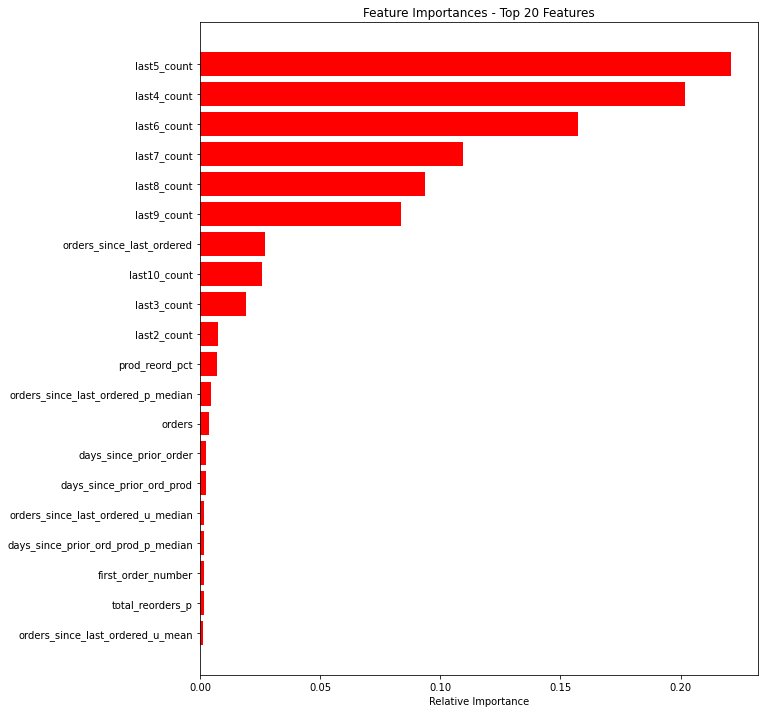

In [ ]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - Top 20 Features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

***Test Submission***

*Using fixed threshold of 0.2*

In [ ]:
y_test_pred = clf.predict_proba(X_test)
test_data['in_last_order'] = (y_test_pred[:,1]>= 0.2).astype(int)
create_submission_file_threshold(test_data,test_orders,model= 'xgboost')

<u>kaggle score

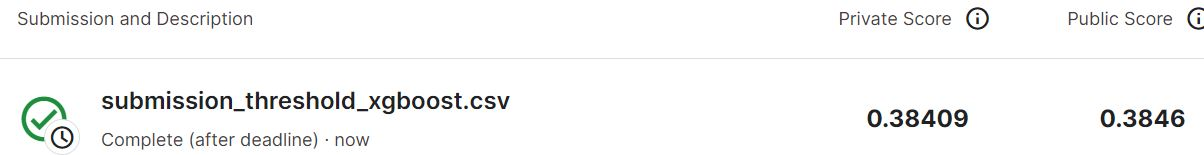

*using f1 optimization script*

In [ ]:
test_data['y_prob'] = clf.predict_proba(X_test)[:,1]
total_proc = 60
orders = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
def multi(i):
  prod = get_best_prediction(orders.iloc[i]['product_id'], orders.iloc[i]['y_prob'], None)
  return prod
pool = mp.Pool(total_proc)
best_products = pool.map(multi, range(orders.shape[0]))
create_submission_f1_optimized(orders,best_products,model = 'xgboost')

<u>kaggle score 

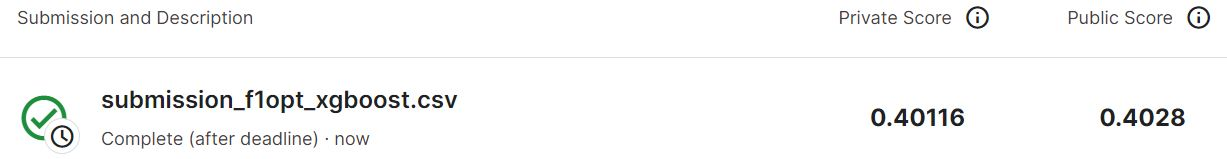

## **5.6 Catoost**

***Training***

*Hyperparameter tuning*

In [ ]:
clf=CatBoostClassifier(task_type = "GPU", silent = True,subsample = 0.85,boosting_type = 'Plain',bootstrap_type = 'Bernoulli' )
prams={
    'learning_rate':[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],
     'n_estimators':[3000,3100,3200,3300,3400,3500],
     'max_depth':[3,4,5,6,7,8,9,10],
}
cat_random=RandomizedSearchCV(clf,param_distributions=prams,cv=2,scoring='neg_log_loss')
cat_random.fit(X_train,y_train)
print(cat_random.best_params_)

{'n_estimators': 3300, 'max_depth': 3, 'learning_rate': 0.04}


*Training with best parameters*

In [ ]:
clf=CatBoostClassifier(task_type = "GPU", silent = True,subsample = 0.85,boosting_type = 'Plain',bootstrap_type = 'Bernoulli',max_depth = 3, n_estimators = 3000, learning_rate = 0.04 )
clf.fit(X_train,y_train)

***Validation***

In [ ]:
y_val_pred = clf.predict_proba(X_val)
print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.24457983484902399


***Feature Importance - Top 20 Features***

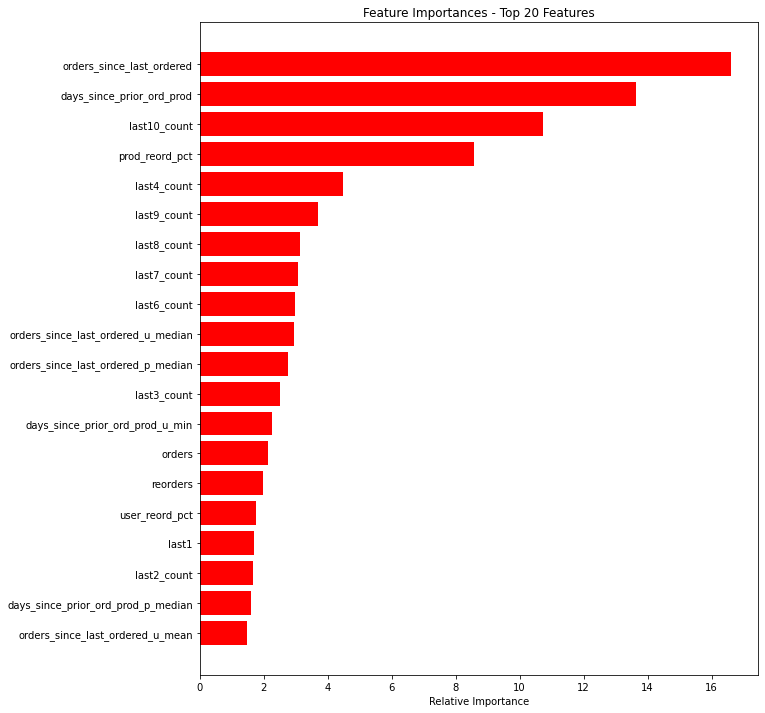

In [ ]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - Top 20 Features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

*Using fixed threshold of 0.2*

In [ ]:
y_test_pred = clf.predict_proba(X_test)
test_data['in_last_order'] = (y_test_pred[:,1]>= 0.2).astype(int)
create_submission_file_threshold(test_data,test_orders,model= 'catboost')

<u>kaggle score

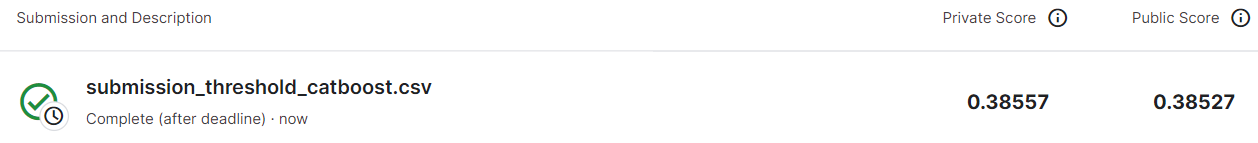

*using f1 optimization script*

In [ ]:
test_data['y_prob'] = clf.predict_proba(X_test)[:,1]
total_proc = 60
orders = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
def multi(i):
  prod = get_best_prediction(orders.iloc[i]['product_id'], orders.iloc[i]['y_prob'], None)
  return prod
pool = mp.Pool(total_proc)
best_products = pool.map(multi, range(orders.shape[0]))
create_submission_f1_optimized(orders,best_products,model = 'catboost')

<u>kaggle score

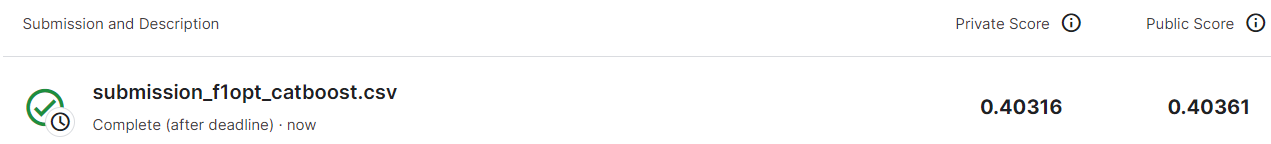

***Saving best model***

In [ ]:
clf.save_model('/content/drive/MyDrive/Instacart/catboost_model') 

## **5.6 Results**

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names  = ['Model' , 'Validation Log Loss',  'F1 Score - Fixed threshold(0.2)', 'F1 Score - Optimized']

table.add_row(['Baseline Model', 0.698,	0.31202,0.31202])
table.add_row(['Logistic Regression', 0.2477,	0.37547	,0.38996])
table.add_row(['Decision Tree', 0.2476,	0.37582	,0.38588])
table.add_row(['Random Forest', 0.2454,	0.38266,	0.39455])
table.add_row(['XgBoost',0.2442,	0.38409	,0.40116])
table.add_row(['Catboost', 0.2445,	0.38527,0.40316])

print(table)



+---------------------+---------------------+---------------------------------+----------------------+
|        Model        | Validation Log Loss | F1 Score - Fixed threshold(0.2) | F1 Score - Optimized |
+---------------------+---------------------+---------------------------------+----------------------+
|    Baseline Model   |        0.698        |             0.31202             |       0.31202        |
| Logistic Regression |        0.2477       |             0.37547             |       0.38996        |
|    Decision Tree    |        0.2476       |             0.37582             |       0.38588        |
|    Random Forest    |        0.2454       |             0.38266             |       0.39455        |
|       XgBoost       |        0.2442       |             0.38409             |       0.40116        |
|       Catboost      |        0.2445       |             0.38527             |       0.40316        |
+---------------------+---------------------+----------------------------

> Kaggle private results are listed above, the best score is in the 10th percentile of all submissions.<br>
> Catboost with F1 - optimization gives the best F1 score(0.40316)

<u>***Prediction for single user***



In [ ]:
test_orders = orders[orders['eval_set']=='test'][['order_id','user_id']]

*Loading best model*

In [ ]:
clf = CatBoostClassifier()      
clf.load_model('/content/drive/MyDrive/Instacart/catboost_model')

In [ ]:
clf=CatBoostClassifier(task_type = "GPU", silent = True,subsample = 0.85,boosting_type = 'Plain',bootstrap_type = 'Bernoulli',max_depth = 3, n_estimators = 3000, learning_rate = 0.04 )
clf.fit(X_train,y_train)

In [ ]:
idx = test_data[test_data['user_id']==100].index.tolist()
X_test_user = X_test[idx]
test_data_user = test_data.iloc[idx]

test_data_user['y_prob'] = clf.predict_proba(X_test_user)[:,1]
orders = test_data_user.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data_user.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
prod = get_best_prediction(orders.iloc[0]['product_id'], orders.iloc[0]['y_prob'], None)

prods =[]
for i in prod.split() :
  prods.append(i)
prods = list(map(int,prods))

***Products in the prior order for User = 100***

In [ ]:
for i in test_data[test_data['user_id']==100].product_name :
  print(i)

Double Chocolate Chip Cookies
Bubblegum Flavor Natural Chewing Gum
Fat Free Milk
Organic Reduced Fat Milk
Organic Strawberries
Banana
Organic Red Grapes
Organic Baby Arugula
Organic Roma Tomato
Roma Tomato
Sesame Seaweed Salad
Uncured Genoa Salami
Chicken Nuggets
Whole Strawberries
World Cuisine Certified Halal Chicken Tikka Masala With Basmati Rice
Organic Whole Wheat Bread
Chocolate Miracle Tart
Low Sodium Bacon
Boneless Skinless Chicken Breasts
Smoked Salmon


***Most probable products in user_id 100 latest order***







From all the products that were ordered by the user , below are the most probable products in their latest order

In [ ]:
for i in products[products.product_id.isin(prods)].product_name:
  print(i)

Organic Strawberries
Organic Baby Arugula
Banana
Uncured Genoa Salami
Organic Reduced Fat Milk
